# **CS3244 Group Project: Understanding Sarcasm on Reddit**

---

Team Members: Chong Kha Lek, Daniel Png, Fong Kai Jun, Ramanen Bharatwa, Jeron Liaw


---

Project Description:
The project aims to develop a binary classification model to identify sarcastic comments on Reddit accurately. Utilizing the Self-Annotated Reddit Sarcasm Dataset (SARC), which spans comments from January 2009 to April 2017. This project seeks to explore linguistic patterns distinguishing sarcastic from non-sarcastic comments. The project encompasses an exploratory data analysis (EDA) to uncover underlying patterns and employs machine learning techniques for model building, aiming for an optimal balance between accuracy and interpretability.



#  1 Data exploration and cleaning

### 1.1 Importing libraries and dataset

In [ ]:
# Standard libraries and general utilities
import os
import json
import re

# Data manipulation and analysis
import pandas as pd
import numpy as np
import gdown

# Plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# HTML processing
from bs4 import BeautifulSoup

# Natural Language Processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
import spacy

# Machine Learning and Deep Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

# Warnings
import warnings

In [ ]:
import pandas as pd# Read the CSV file
!gdown "https://drive.google.com/uc?id=1JLVbEiZCN4wqokZj8WNzQqFd9Y4yCjDT"

df = pd.read_csv("train-balanced-sarcasm.csv")
print(f'The length of the dataframe is {len(df)}')

# Display the first few rows of the DataFrame
print(df.head())
print("Dataframe Shape:", df.shape)


Downloading...
From (original): https://drive.google.com/uc?id=1JLVbEiZCN4wqokZj8WNzQqFd9Y4yCjDT
From (redirected): https://drive.google.com/uc?id=1JLVbEiZCN4wqokZj8WNzQqFd9Y4yCjDT&confirm=t&uuid=3f671486-247e-4640-b841-e9cc4463c5d2
To: /content/train-balanced-sarcasm.csv
100% 255M/255M [00:02<00:00, 124MB/s]
The length of the dataframe is 1010826
   label                                            comment     author  \
0      0                                         NC and NH.  Trumpbart   
1      0  You do know west teams play against west teams...  Shbshb906   
2      0  They were underdogs earlier today, but since G...   Creepeth   
3      0  This meme isn't funny none of the "new york ni...  icebrotha   
4      0                    I could use one of those tools.  cush2push   

            subreddit  score  ups  downs     date          created_utc  \
0            politics      2   -1     -1  2016-10  2016-10-16 23:55:23   
1                 nba     -4   -1     -1  2016-11  2016-1

In [ ]:
df.columns

Index(['label', 'comment', 'author', 'subreddit', 'score', 'ups', 'downs',
       'date', 'created_utc', 'parent_comment'],
      dtype='object')

### 1.2 Remove Duplicate Rows

We will first remove all duplicate rows.

In [ ]:
comments_df = df.drop_duplicates().reset_index(drop=True)
print(len(comments_df))

1010798


In [ ]:
1010826 - 1010798

28

There are 1010826 - 1010798 = 28 duplicated rows.

We should also remove duplicates whose comments are simply a copy of the parent's comments. This would allow us to perform better feature engineering later in the project.

In [ ]:
len_duplicates = comments_df.duplicated(subset=['comment', 'parent_comment'], keep=False).sum()
print(f'There are {len_duplicates} duplicates with the same parent and root comments')
comments_df = comments_df.drop_duplicates(subset=['comment', 'parent_comment'], keep='first')

There are 1232 duplicates with the same parent and root comments


We next focus our dataframe to only the 'label', 'comment', 'subreddit', 'score', 'ups' and 'downs' columns.

In [ ]:
comments_df = comments_df[ ['label', 'comment', 'subreddit', 'score', 'ups', 'downs', 'parent_comment']]
print(comments_df.head())
print("Dataframe Shape:", comments_df.shape)

   label                                            comment  \
0      0                                         NC and NH.   
1      0  You do know west teams play against west teams...   
2      0  They were underdogs earlier today, but since G...   
3      0  This meme isn't funny none of the "new york ni...   
4      0                    I could use one of those tools.   

            subreddit  score  ups  downs  \
0            politics      2   -1     -1   
1                 nba     -4   -1     -1   
2                 nfl      3    3      0   
3  BlackPeopleTwitter     -8   -1     -1   
4  MaddenUltimateTeam      6   -1     -1   

                                      parent_comment  
0  Yeah, I get that argument. At this point, I'd ...  
1  The blazers and Mavericks (The wests 5 and 6 s...  
2                            They're favored to win.  
3                         deadass don't kill my buzz  
4  Yep can confirm I saw the tool they use for th...  
Dataframe Shape: (1010017,

### 1.3 Remove Null comments

In [ ]:
print(f'There are {sum(comments_df["comment"].isna())} null comments in the dataset')


There are 55 null comments in the dataset


We will proceed to remove the null comments.

In [ ]:
comments_df = comments_df.dropna(subset = ["comment"])
# print(sum(comments_df["comment"].isna())) # 0

### 1.4 Data processing using Feature Engineering: Comment length
We then create a new column comment length, and study the descriptive statistics.

In [ ]:
comments_df['comment_length'] = comments_df['comment'].apply(lambda x: len(x.split(" ")))
print(comments_df['comment_length'].describe())


count    1.009962e+06
mean     1.046403e+01
std      1.034878e+01
min      1.000000e+00
25%      5.000000e+00
50%      9.000000e+00
75%      1.400000e+01
max      2.222000e+03
Name: comment_length, dtype: float64


We can visualise the spread of comment length data points using a boxplot.

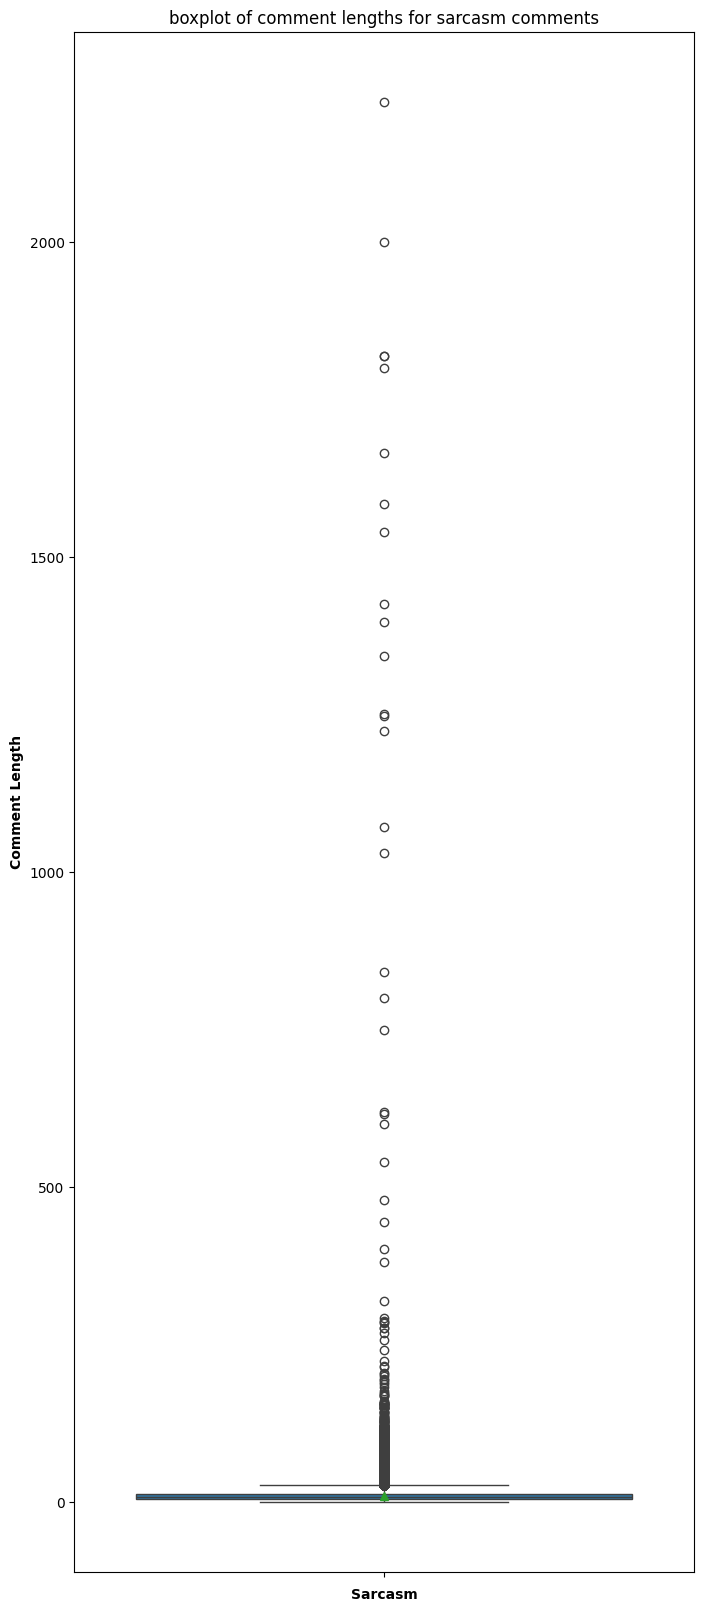

In [ ]:
plt.figure(figsize=(8, 20))
sns.boxplot(y = 'comment_length', data = comments_df, showmeans = True)

plt.xlabel('Sarcasm', fontweight='bold')
plt.ylabel('Comment Length', fontweight='bold')
plt.title('boxplot of comment lengths for sarcasm comments')
plt.show()

As seen above, the data is very right skewed. We can identify how many long comments are there and remove the outliers using the interquartile range.

In [ ]:
q3, q1 = np.percentile(comments_df['comment_length'], [75 ,25])
iqr = q3 - q1

outliers = comments_df[((comments_df['comment_length']<(q1-1.5*iqr)) | (comments_df['comment_length']>(q3+1.5*iqr)))]
print(f'There are {len(outliers)} outlier comment lengths which is around {len(outliers)/len(comments_df)} of all comments')

There are 36272 outlier comment lengths which is around 0.03591422251530255 of all comments


As suggested by our TA Chad, we should explore the reasons for these outliers. A sample of the top 10 longest comments without profanities shows that only 1 out of 10 is a copy of some patch notes, the rest is a series of repeated words or phrases (also known as copy pasta). Since these outliers only take up 3% of the entire data, it is safe to assume that we can afford to filter out these data points to reduce the overall noise and to potentially reduce the computational power of our ML methods.

In [ ]:
for comment in comments_df.sort_values(by='comment_length', ascending=False).iloc[[0, 3, 4, 5, 6, 7, 8, 9, 10, 11]]['comment']:
    display(comment)

'iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 iPhone 7 

'***a mac is a PC*** ***a mac is a PC*** ***a mac is a PC*** ***a mac is a PC*** ***a mac is a PC*** ***a mac is a PC*** ***a mac is a PC*** ***a mac is a PC*** ***a mac is a PC*** ***a mac is a PC*** ***a mac is a PC*** ***a mac is a PC*** ***a mac is a PC*** ***a mac is a PC*** ***a mac is a PC*** ***a mac is a PC*** ***a mac is a PC*** ***a mac is a PC*** ***a mac is a PC*** ***a mac is a PC*** ***a mac is a PC*** ***a mac is a PC*** ***a mac is a PC*** ***a mac is a PC*** ***a mac is a PC*** ***a mac is a PC*** ***a mac is a PC*** ***a mac is a PC*** ***a mac is a PC*** ***a mac is a PC*** ***a mac is a PC*** ***a mac is a PC*** ***a mac is a PC*** ***a mac is a PC*** ***a mac is a PC*** ***a mac is a PC*** ***a mac is a PC*** ***a mac is a PC*** ***a mac is a PC*** ***a mac is a PC*** ***a mac is a PC*** ***a mac is a PC*** ***a mac is a PC*** ***a mac is a PC*** ***a mac is a PC*** ***a mac is a PC*** ***a mac is a PC*** ***a mac is a PC*** ***a mac is a PC*** ***a mac is a PC***

'Fake news fake news Fake news fake news Fake news fake news Fake news fake news Fake news fake news Fake news fake news Fake news fake news Fake news fake news Fake news fake news Fake news fake news Fake news fake news Fake news fake news Fake news fake news Fake news fake news Fake news fake news Fake news fake news Fake news fake news Fake news fake news Fake news fake news Fake news fake news Fake news fake news Fake news fake news Fake news fake news Fake news fake news Fake news fake news Fake news fake news Fake news fake news Fake news fake news Fake news fake news Fake news fake news Fake news fake news Fake news fake news Fake news fake news Fake news fake news Fake news fake news Fake news fake news Fake news fake news Fake news fake news Fake news fake news Fake news fake news Fake news fake news Fake news fake news Fake news fake news Fake news fake news Fake news fake news Fake news fake news Fake news fake news Fake news fake news Fake news fake news Fake news fake news

'#[MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY MONEY M

'LOVE TRUMPS HATE LOVE TRUMPS HATE LOVE TRUMPS HATE LOVE TRUMPS HATE LOVE TRUMPS HATE LOVE TRUMPS HATE LOVE TRUMPS HATE LOVE TRUMPS HATE LOVE TRUMPS HATE LOVE TRUMPS HATE LOVE TRUMPS HATE LOVE TRUMPS HATE LOVE TRUMPS HATE LOVE TRUMPS HATE LOVE TRUMPS HATE LOVE TRUMPS HATE LOVE TRUMPS HATE LOVE TRUMPS HATE LOVE TRUMPS HATE LOVE TRUMPS HATE LOVE TRUMPS HATE LOVE TRUMPS HATE LOVE TRUMPS HATE LOVE TRUMPS HATE LOVE TRUMPS HATE LOVE TRUMPS HATE LOVE TRUMPS HATE LOVE TRUMPS HATE LOVE TRUMPS HATE LOVE TRUMPS HATE LOVE TRUMPS HATE LOVE TRUMPS HATE LOVE TRUMPS HATE LOVE TRUMPS HATE LOVE TRUMPS HATE LOVE TRUMPS HATE LOVE TRUMPS HATE LOVE TRUMPS HATE LOVE TRUMPS HATE LOVE TRUMPS HATE LOVE TRUMPS HATE LOVE TRUMPS HATE LOVE TRUMPS HATE LOVE TRUMPS HATE LOVE TRUMPS HATE LOVE TRUMPS HATE LOVE TRUMPS HATE LOVE TRUMPS HATE LOVE TRUMPS HATE LOVE TRUMPS HATE LOVE TRUMPS HATE LOVE TRUMPS HATE LOVE TRUMPS HATE LOVE TRUMPS HATE LOVE TRUMPS HATE LOVE TRUMPS HATE LOVE TRUMPS HATE LOVE TRUMPS HATE LOVE TRUMPS H

'DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD TRUMP DONALD TRUM

'PATCH NOTES General Gameplay Fixed technology becoming instantly fully charged when repaired Fixed ship appearing on incorrect pad in space station after loading Added interactable objects that required certain tech to collect Added shootable objects that require certain tech to mine Rebalanced resource availability and technology charge requirements Fixed initial game flow - where travelling to space too quickly after visiting the monolith could prevent the first atlas station notification appearing Prevented player being prompted to scan for buildings before leaving the system after visiting the monolith Prevented laser and melee attacks while in space from attempting to edit terrain Improved calculation of resources received when mining terrain Renamed Signal Scanners to Signal Boosters Signal booster objects updated to search for playable bases, suit upgrade pods, and mineable resources Removed signal booster from being distributed on terrain, as player can now build them Improved

'Nvidia GTX 1080 1070 1060 1050 Founders Edition SLI SMP Nvidia GTX 1080 1070 1060 1050 Founders Edition SLI SMP Nvidia GTX 1080 1070 1060 1050 Founders Edition SLI SMP Nvidia GTX 1080 1070 1060 1050 Founders Edition SLI SMP Nvidia GTX 1080 1070 1060 1050 Founders Edition S ayy LI SMP Nvidia GTX 1080 1070 1060 1050 Founders Edition SLI SMP Nvidia GTX 1080 1070 1060 1050 Founders Edition SLI SMP Nvidia GTX 1080 1070 1060 1050 Founders Edition SLI SMP Nvidia GTX 1080 1070 1060 1050 Founders Edition SLI SMP Nvidia GTX 1080 1070 1060 1050 Founders Edition SLI SMP Nvidia GTX 1080 1070 1060 1050 Founders Edition SLI SMP Nvidia GTX 1080 1070 1060 1050 Founders Edition SLI SMP Nvidia GTX 1080 1070 1060 1050 Founders Edition SLI SMP Nvidia GTX 1080 1070 1060 1050 Founders Edition SLI SMP Nvidia GTX 1080 1070 1060 1050 Founders Edition SLI SMP Nvidia GTX 1080 1070 1060 1050 Founders Edition SLI SMP Nvidia GTX 1080 1070 1060 1050 Founders Edition SLI SMP Nvidia GTX 1080 1070 1060 1050 Founders Ed

'JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JERRY JER

'Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast Comcast

As mentioned, since these outliers only make up 3% of the comments, we can remove them without affecting the dataset too much

In [ ]:
print(f'Previous length of dataset {len(comments_df)}')
comments_df = comments_df[
    (comments_df['comment_length'] > (q1 - 1.5 * iqr)) &
    (comments_df['comment_length'] < (q3 + 1.5 * iqr))
]

print(f'New length of dataset {len(comments_df)}')

Previous length of dataset 1009962
New length of dataset 973690


In [ ]:
1009962 - 36272

973690

In [ ]:
print(comments_df['comment_length'].describe())

count    973690.000000
mean          9.460662
std           5.961972
min           1.000000
25%           5.000000
50%           8.000000
75%          13.000000
max          27.000000
Name: comment_length, dtype: float64


In [ ]:
# We will now split the dataframe into 2 parts, sarcasm and no sarcasm
no_sarcasm_df = comments_df[comments_df['label'] == 0]
sarcasm_df = comments_df[comments_df['label'] == 1]
print(f'The length of the entire dataset is {len(comments_df)}')
print(f'The length of the no sarcasm dataset is {len(no_sarcasm_df)}')
print(f'The length of the sarcasm dataset is {len(sarcasm_df)}')


The length of the entire dataset is 973690
The length of the no sarcasm dataset is 481206
The length of the sarcasm dataset is 492484


The dataset is relatively balanced.

We can now investigate any patterns in sarcastic comments. We first extract the top 10 sarcastic comments by upvotes.

In [ ]:
for comment in sarcasm_df.sort_values(by='score', ascending=False).head(10)['comment']:
    display(comment)

"That's exactly what a country who made up a hoax about climate change would say!"

'but it still snows'

'Maybe you should stop being a man?'

'I think he was really referring to the vuvuzela'

"Huh, I wonder why he's so shy."

"Jesus, and you wonder why you're still single!"

'Yet another thing that men are better at doing'

"It's only racist if a white person says it."

"I'm sure they will now optimize that app to be faster, work smoother and waste less battery and RAM in order to please their faithful users."

'A foreigner taking another american job...'

Compare this to non-sarcastic comments.

In [ ]:
for comment in no_sarcasm_df.sort_values(by='score', ascending=False).head(10)['comment']:
    display(comment)

"lol, you can't make this stuff up."

"He didn't drink the compliance"

"In the Half Life series, the reason Gordon Freeman doesn't talk is because he keeps all his weapons in his mouth."

'Getting pushed back by the impact of a bullet.'

'Ah, a nice guy.'

"So you're telling me that without motivation to hit a fly people would just piss on the floor?"

'Vet here, most cats have 4'

'Does anyone know if Flint has clean water yet?'

'Prion diseases are always fatal'

'We only use the best bits and bytes crafted by artisan data makers in the hills of Tuscany.'

By using a sample size of just 10 data points, we have the following insights:

1. Punctuation. It appears that sarcastic comments tend to end with ? ! or ... we can generalise it to check if the comment ends with 1. full stop/ no punctuation or 2. separate punctuation.

2. Use of words: Sarcastic comments tend to use more Negations and hypothetical words, adverbs, conjunctions and interrogatives. We will explore more of that in the part of speech tagging.


Punctuation

In [ ]:
def check_special_punctuation(comment):
    pattern = r"(\?|!|\.\.\.)$"
    if re.search(pattern, comment):
        return 1
    else:
        return 0


In [ ]:
sarcasm_df['end_with_special_punctuation'] = sarcasm_df['comment'].apply(check_special_punctuation)
no_sarcasm_df['end_with_special_punctuation'] = no_sarcasm_df['comment'].apply(check_special_punctuation)
# print(no_sarcasm_df.head(3))
# for comment in no_sarcasm_df.head(3)['comment']:
#     display(comment)


<ipython-input-27-5dfe76849983>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sarcasm_df['end_with_special_punctuation'] = sarcasm_df['comment'].apply(check_special_punctuation)
<ipython-input-27-5dfe76849983>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_sarcasm_df['end_with_special_punctuation'] = no_sarcasm_df['comment'].apply(check_special_punctuation)


In [ ]:
print(f"The number of comments that end with special punctuation for sarcastic comments is {sum(sarcasm_df['end_with_special_punctuation'])}")
print(f"The number of comments that end with special punctuation for non-sarcastic comments is {sum(no_sarcasm_df['end_with_special_punctuation'])}")

The number of comments that end with special punctuation for sarcastic comments are 139286
The number of comments that end with special punctuation for non sarcastic comments are 101685


We can also visualise the above using a bar chart.

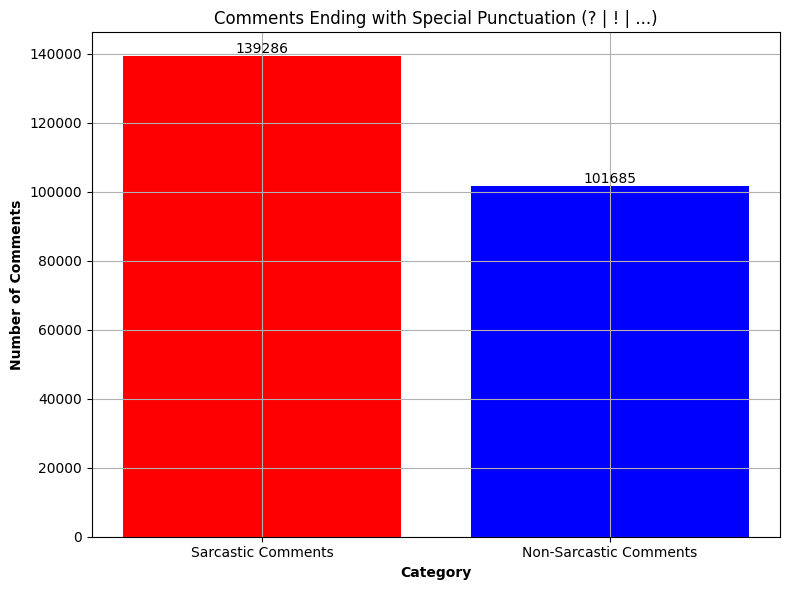

In [ ]:
categories = ['Sarcastic Comments', 'Non-Sarcastic Comments']
counts = [sum(sarcasm_df['end_with_special_punctuation']), sum(no_sarcasm_df['end_with_special_punctuation'])]

plt.figure(figsize=(8, 6))
bars = plt.bar(categories, counts, color=['Red', 'Blue'])

# Add labels above each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

plt.title('Comments Ending with Special Punctuation (? | ! | ...)')
plt.xlabel('Category', fontweight='bold')
plt.ylabel('Number of Comments', fontweight='bold')

plt.grid(True)
plt.tight_layout()
plt.show()

This shows that special punctuation such as "?", "!" and "..." could be possible indicators of sarcastic comments. We can make use of this for feature engineering later on.

### 1.5 Data Exploration: POS Tagging
We now move on to the part of speech (POS) tagging, and from there we can generate word clouds.

In [ ]:
# Download NLTK resources for part-of-speech tagging
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
def pos_counter_nltk(text):
    verb_count = 0
    adj_count = 0
    pron_count = 0
    noun_count = 0
    adverb_count = 0
    conjunction_count = 0

    tokens = word_tokenize(text)
    tagged_tokens = pos_tag(tokens)

    for word, tag in tagged_tokens:
        if tag in ['VB', 'VBD', 'VBN','VBG', 'VBP', 'VBZ']:  # verbs
            verb_count += 1
        elif tag in ['JJ', 'JJR', 'JJS']:  # Adjectives
            adj_count += 1
        elif tag in ['PRP', 'PRP$', 'WP', 'WP$']:  # Pronouns
            pron_count += 1
        elif tag in ['NN', 'NNP', 'NNS', 'NNPS']: # noun
            noun_count += 1
        elif tag in ['WRB', 'RB', 'RBR', 'RBS']: # adverb
            adverb_count += 1
        elif tag in ['CC', 'IN']: # conjunction
            conjunction_count += 1

    return (verb_count, adj_count, pron_count, noun_count, adverb_count, conjunction_count)

In [ ]:
verb_total_sarcasm = 0
adj_total_sarcasm = 0
pron_total_sarcasm = 0
noun_total_sarcasm = 0
adverb_total_sarcasm = 0
conjunction_total_sarcasm = 0
for comment in sarcasm_df['comment']:
  verb_count, adj_count, pron_count, noun_count, adverb_count, conjunction_count = pos_counter_nltk(comment)
  verb_total_sarcasm += verb_count
  adj_total_sarcasm += adj_count
  pron_total_sarcasm += pron_count
  noun_total_sarcasm += noun_count
  adverb_total_sarcasm += adverb_count
  conjunction_total_sarcasm += conjunction_count

In [ ]:
verb_total_no_sarcasm = 0
adj_total_no_sarcasm = 0
pron_total_no_sarcasm = 0
noun_total_no_sarcasm = 0
adverb_total_no_sarcasm = 0
conjunction_total_no_sarcasm = 0
for comment in no_sarcasm_df['comment']:
  verb_count, adj_count, pron_count, noun_count, adverb_count, conjunction_count = pos_counter_nltk(comment)
  verb_total_no_sarcasm += verb_count
  adj_total_no_sarcasm += adj_count
  pron_total_no_sarcasm += pron_count
  noun_total_no_sarcasm += noun_count
  adverb_total_no_sarcasm += adverb_count
  conjunction_total_no_sarcasm += conjunction_count

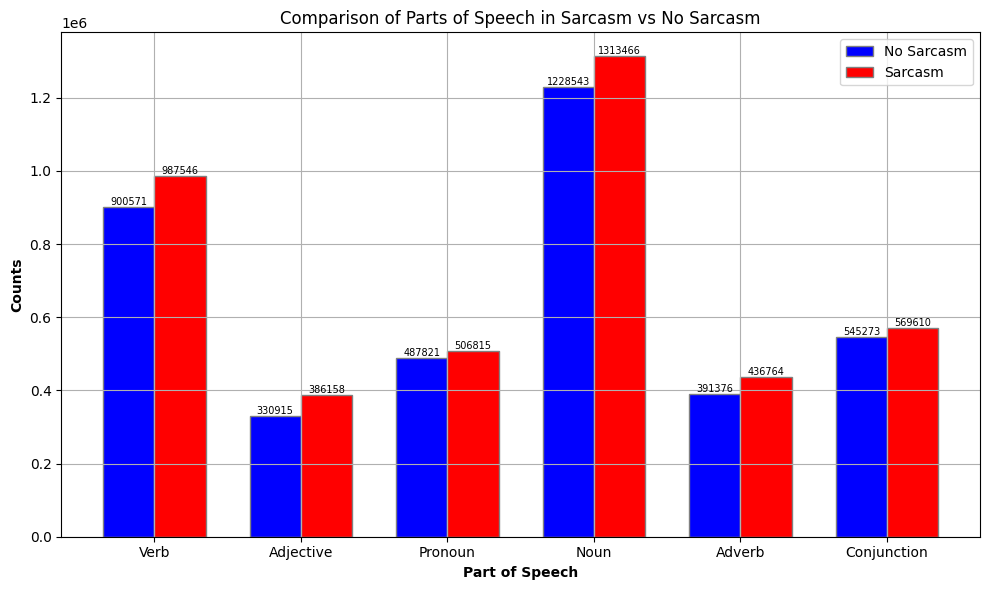

In [ ]:
pos_categories = ['Verb', 'Adjective', 'Pronoun', 'Noun', 'Adverb', 'Conjunction']
no_sarcasm_counts = [verb_total_no_sarcasm, adj_total_no_sarcasm, pron_total_no_sarcasm,
                     noun_total_no_sarcasm, adverb_total_no_sarcasm, conjunction_total_no_sarcasm]
sarcasm_counts = [verb_total_sarcasm, adj_total_sarcasm, pron_total_sarcasm,
                  noun_total_sarcasm, adverb_total_sarcasm, conjunction_total_sarcasm]

barWidth = 0.35
r1 = np.arange(len(no_sarcasm_counts))
r2 = [x + barWidth for x in r1]

plt.figure(figsize=(10, 6))
bars1 = plt.bar(r1, no_sarcasm_counts, color='blue', width=barWidth, edgecolor='grey', label='No Sarcasm')
bars2 = plt.bar(r2, sarcasm_counts, color='red', width=barWidth, edgecolor='grey', label='Sarcasm')

# Add labels above each bar
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}', ha='center', va='bottom', fontsize = 7)

add_labels(bars1)
add_labels(bars2)

plt.xlabel('Part of Speech', fontweight='bold')
plt.xticks([r + barWidth / 2 for r in range(len(no_sarcasm_counts))], pos_categories)
plt.ylabel('Counts', fontweight='bold')
plt.title('Comparison of Parts of Speech in Sarcasm vs No Sarcasm')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


We will now focus on creating a word cloud for verbs and nouns. To better prepare for the word cloud, we can process the comment to remove stop words. There is no need to initialise a not_stopwords list as the list form nltk contains mainly pronouns, prepositions, conjunctions, and auxiliary verbs.

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
display(stopwords.words('english'))

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [ ]:
### Define function to process text
def process_text(text):
    processed_text = ""
    text = text.lower()
    tokens = word_tokenize(text)
    alphabetic_tokens = []
    for token in tokens:
        if re.match("^[a-zA-Z]+$", token):
            alphabetic_tokens.append(token)
    # print(alphabetic_tokens)
    stopwords = nltk.corpus.stopwords.words('english')
    not_stopwords = []
    vulgarities = ['fuck', 'fucking']
    stopwords = [word for word in stopwords if word not in not_stopwords]
    stopwords.extend(vulgarities)
    alphabetic_tokens = [word for word in alphabetic_tokens if word not in stopwords]
    # print(alphabetic_tokens)
    lemmatizer = WordNetLemmatizer()
    alphabetic_tokens = [lemmatizer.lemmatize(word) for word in alphabetic_tokens]
    # print(alphabetic_tokens)
    processed_text = ' '.join(alphabetic_tokens)
    return processed_text

In [ ]:
sarcasm_df['processed_comment'] = sarcasm_df['comment'].apply(lambda x: process_text(x))
print(sarcasm_df.head(3))

    label                                            comment       subreddit  \
33      1                But they'll have all those reviews!  ProductTesting   
44      1  wow it is totally unreasonable to assume that ...        politics   
45      1  Ho ho ho... But Melania said that there is no ...        politics   

    score  ups  downs                                     parent_comment  \
33      0   -1     -1  The dumb thing is, they are risking their sell...   
44      2   -1     -1  Clinton campaign accuses FBI of 'blatant doubl...   
45      8   -1     -1  Anyone else think that it was interesting the ...   

    comment_length  end_with_special_punctuation  \
33               6                             1   
44              25                             0   
45              21                             1   

                                    processed_comment  
33                                             review  
44  wow totally unreasonable assume agency covered...

<ipython-input-48-f9626280820d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sarcasm_df['processed_comment'] = sarcasm_df['comment'].apply(lambda x: process_text(x))


In [ ]:
no_sarcasm_df['processed_comment'] = no_sarcasm_df['comment'].apply(lambda x: process_text(x))
print(no_sarcasm_df.head(3))

   label                                            comment subreddit  score  \
0      0                                         NC and NH.  politics      2   
1      0  You do know west teams play against west teams...       nba     -4   
2      0  They were underdogs earlier today, but since G...       nfl      3   

   ups  downs                                     parent_comment  \
0   -1     -1  Yeah, I get that argument. At this point, I'd ...   
1   -1     -1  The blazers and Mavericks (The wests 5 and 6 s...   
2    3      0                            They're favored to win.   

   comment_length  end_with_special_punctuation  \
0               3                             0   
1              14                             1   
2              19                             0   

                                   processed_comment  
0                                              nc nh  
1      know west team play west team east team right  
2  underdog earlier today since gron

<ipython-input-50-ba65cb073e74>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_sarcasm_df['processed_comment'] = no_sarcasm_df['comment'].apply(lambda x: process_text(x))


In [ ]:
### Define function to extract verbs
def extract_verbs(text):
    verbs = []
    tokens = word_tokenize(text.lower())
    tags = nltk.pos_tag(tokens)
    for word, tag in tags:
        if tag.startswith('VB'):
            verbs.append(word)
    return verbs


In [ ]:
from collections import Counter

def count_verbs(texts):
    all_verbs = []
    for text in texts:
        verbs = extract_verbs(text)
        all_verbs.extend(verbs)
    return Counter(all_verbs)

sarcasm_verbs_count = count_verbs(sarcasm_df['processed_comment'] )
no_sarcasm_verbs_count = count_verbs(no_sarcasm_df['processed_comment'] )

top_10_sarcastic_verbs = sarcasm_verbs_count.most_common(10)
top_10_non_sarcastic_verbs = no_sarcasm_verbs_count.most_common(10)

print("Top 10 Verbs in Sarcastic Comments:", top_10_sarcastic_verbs)
print("Top 10 Verbs in Non-Sarcastic Comments:", top_10_non_sarcastic_verbs)


Top 10 Verbs in Sarcastic Comments: [('get', 13135), ('know', 12777), ('make', 10975), ('go', 6833), ('got', 6675), ('see', 6154), ('think', 5709), ('say', 5630), ('going', 5571), ('want', 5523)]
Top 10 Verbs in Non-Sarcastic Comments: [('get', 11963), ('think', 9084), ('make', 8801), ('know', 8173), ('go', 7205), ('got', 7167), ('say', 7013), ('going', 5649), ('see', 5290), ('want', 4341)]


In [ ]:
### Define function to extract nouns
def extract_nouns(text):
    nouns = []
    tokens = word_tokenize(text.lower())
    tags = nltk.pos_tag(tokens)
    for word, tag in tags:
        if tag.startswith('NN'):
            nouns.append(word)
    return nouns


In [ ]:
def count_nouns(texts):
    all_nouns = []
    for text in texts:
        nouns = extract_nouns(text)
        all_nouns.extend(nouns)
    return Counter(all_nouns)

sarcasm_nouns_count = count_nouns(sarcasm_df['processed_comment'] )
no_sarcasm_nouns_count = count_nouns(no_sarcasm_df['processed_comment'] )

top_10_sarcastic_nouns = sarcasm_nouns_count.most_common(10)
top_10_non_sarcastic_nouns = no_sarcasm_nouns_count.most_common(10)

print("Top 10 Nouns in Sarcastic Comments:", top_10_sarcastic_nouns)
print("Top 10 Nouns in Non-Sarcastic Comments:", top_10_non_sarcastic_nouns)


Top 10 Nouns in Sarcastic Comments: [('yeah', 19462), ('people', 19330), ('game', 10094), ('thing', 8870), ('time', 8796), ('guy', 8578), ('man', 8501), ('way', 7233), ('woman', 6590), ('everyone', 6278)]
Top 10 Verbs in Non-Sarcastic Comments: [('people', 12496), ('time', 9937), ('game', 8182), ('thing', 7368), ('year', 6240), ('look', 6237), ('way', 5776), ('guy', 5438), ('yeah', 5248), ('something', 5183)]


In [ ]:
### Define function to generate Word Cloud for a given function
def generate_word_cloud(text, title, extract_function):
    wordcloud = None
    target = ' '.join(extract_function(text))
    wordcloud = WordCloud(width = 800, height = 400, background_color="white").generate(target)
    # Plot the Word Cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

In [ ]:
### Generate a long string of all processed comments for sarcasm and no_scacasm
sarcasm_processed = ' '.join(sarcasm_df['processed_comment'])

no_sarcasm_processed = ' '.join(no_sarcasm_df['processed_comment'])

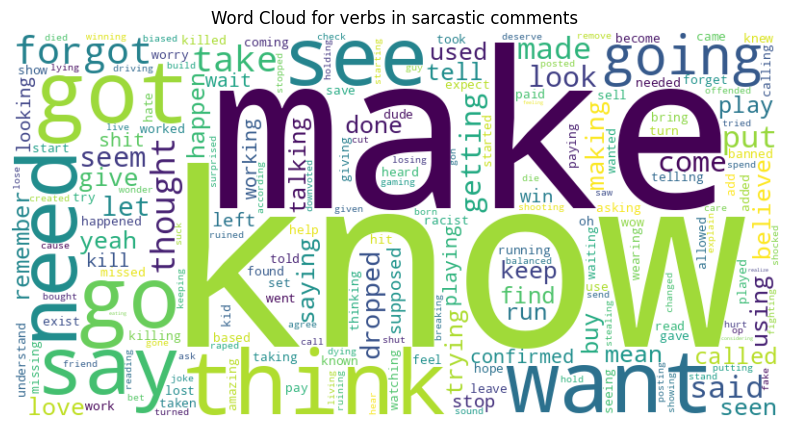

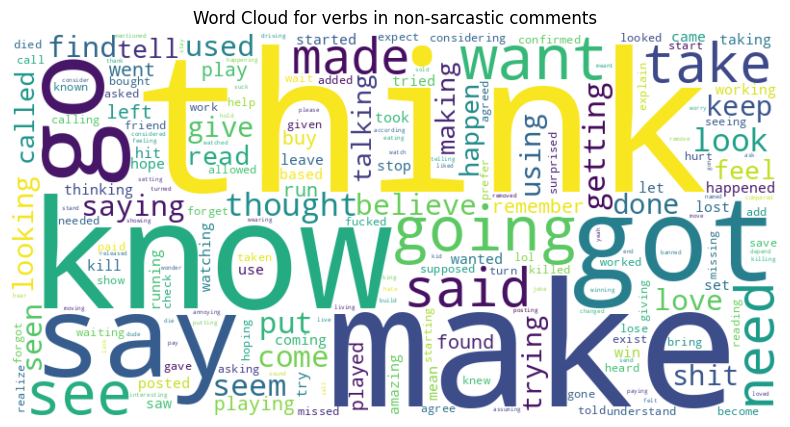

In [ ]:
### Generate Verb Word Clouds

generate_word_cloud(sarcasm_processed, 'Word Cloud for verbs in sarcastic comments', extract_verbs)
generate_word_cloud(no_sarcasm_processed, 'Word Cloud for verbs in non-sarcastic comments', extract_verbs)

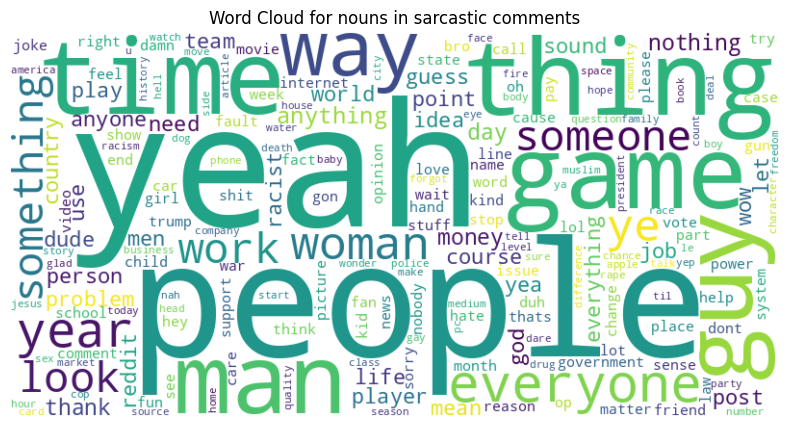

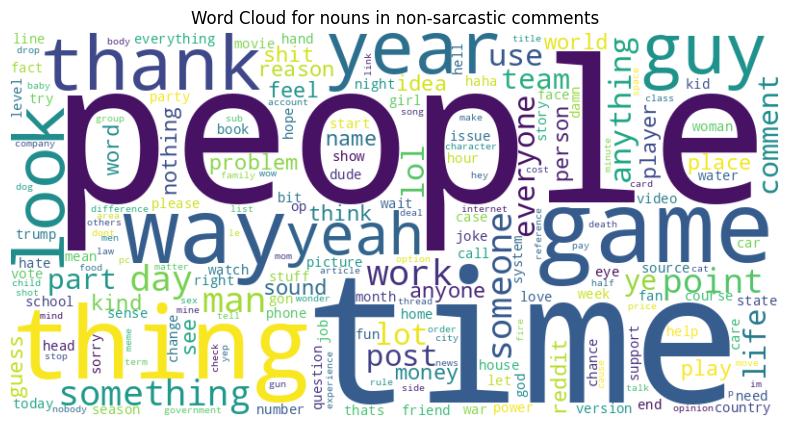

In [ ]:
### Generate noun Word Clouds

generate_word_cloud(sarcasm_processed, 'Word Cloud for nouns in sarcastic comments', extract_nouns)
generate_word_cloud(no_sarcasm_processed, 'Word Cloud for nouns in non-sarcastic comments', extract_nouns)

**Conclusion**: Based on our analysis of the most frequently used nouns and verbs in sarcastic versus non-sarcastic comments, it appears that no single word serves as a reliable indicator to distinctly differentiate between the two. This complexity arises from the inherent nuances of the English language, where numerous content-rich words carry significant meanings and thus, are integral to understanding the context of statements.

A notable observation from our study is the prevalent use of the word "yeah" in sarcastic comments, which may suggest a pattern of usage that warrants further investigation. However, this alone is insufficient to accurately classify a comment's intent due to the complexities involved in how sarcasm is typically conveyed.

These findings underscore the limitations of simple word frequency analysis for detecting sarcasm, highlighting the need for more sophisticated approaches. ML models that analyze the sequential order and contextual relationships within text may offer a more effective solution for identifying sarcasm accurately.

### 1.6 Data Exploration: Scores, upvotes and downvotes of sarcasm vs no sarcasm
We can also look at the columns beyond comments to identify possible relationships between the score, and post upvotes and downvotes

In [ ]:
sarcasm_descriptive_stats = sarcasm_df['score'].agg(['mean', 'median', lambda x: x.mode()[0]]).rename({'<lambda>': 'mode'})
no_sarcasm_descriptive_stats = no_sarcasm_df['score'].agg(['mean', 'median', lambda x: x.mode()[0]]).rename({'<lambda>': 'mode'})

combined_stats = pd.DataFrame({'Sarcasm': sarcasm_descriptive_stats, 'No Sarcasm': no_sarcasm_descriptive_stats})

print(combined_stats)

         Sarcasm  No Sarcasm
mean    6.362889    7.429384
median  2.000000    2.000000
mode    1.000000    1.000000


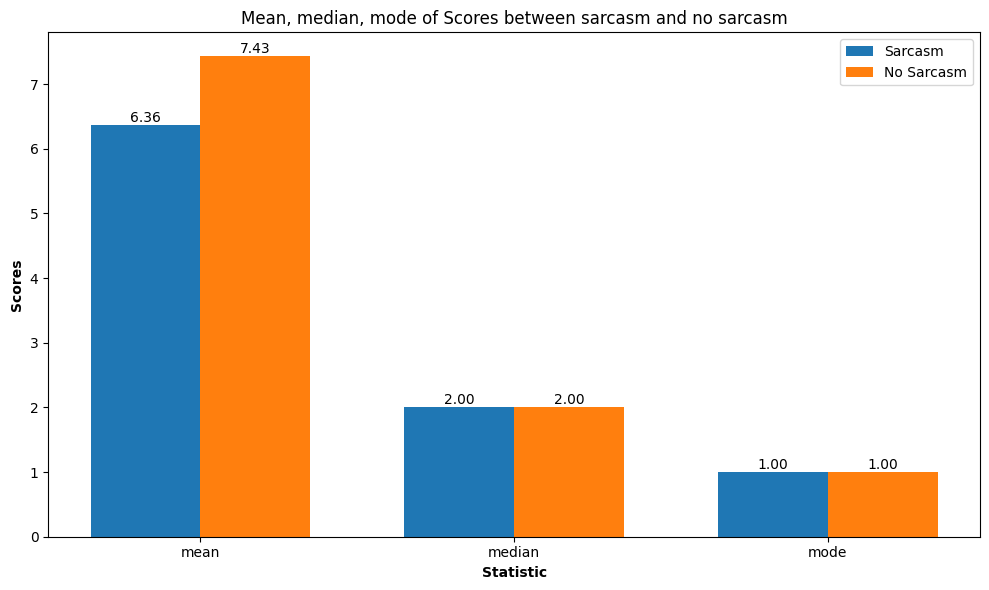

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(combined_stats))

bar1 = ax.bar(index, combined_stats['Sarcasm'], bar_width, label='Sarcasm')
bar2 = ax.bar(index + bar_width, combined_stats['No Sarcasm'], bar_width, label='No Sarcasm')

# Add labels
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

add_labels(bar1)
add_labels(bar2)

ax.set_xlabel('Statistic', fontweight='bold')
ax.set_ylabel('Scores', fontweight='bold')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(combined_stats.index)
ax.legend()

plt.title('Mean, median, mode of Scores between sarcasm and no sarcasm')
plt.tight_layout()
plt.show()


In [ ]:
sarcasm_descriptive_stats = sarcasm_df['ups'].agg(['mean', 'median', lambda x: x.mode()[0]]).rename({'<lambda>': 'mode'})
no_sarcasm_descriptive_stats = no_sarcasm_df['ups'].agg(['mean', 'median', lambda x: x.mode()[0]]).rename({'<lambda>': 'mode'})

combined_stats = pd.DataFrame({'Sarcasm': sarcasm_descriptive_stats, 'No Sarcasm': no_sarcasm_descriptive_stats})

print(combined_stats)

         Sarcasm  No Sarcasm
mean    5.187448     5.81813
median  1.000000     1.00000
mode    1.000000     1.00000


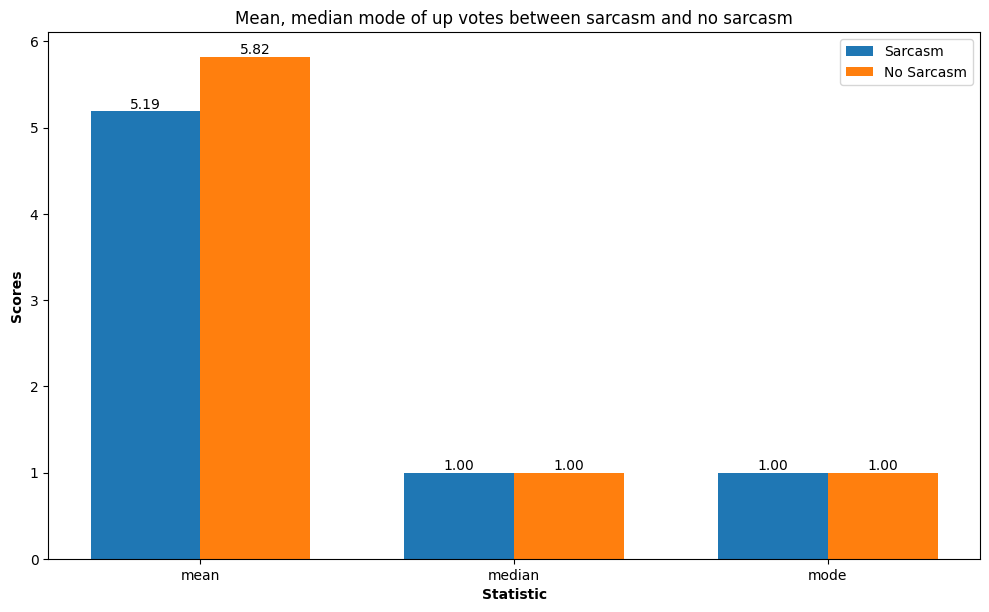

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(combined_stats))

bar1 = ax.bar(index, combined_stats['Sarcasm'], bar_width, label='Sarcasm')
bar2 = ax.bar(index + bar_width, combined_stats['No Sarcasm'], bar_width, label='No Sarcasm')

# Add labels
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

add_labels(bar1)
add_labels(bar2)

ax.set_xlabel('Statistic', fontweight='bold')
ax.set_ylabel('Scores', fontweight='bold')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(combined_stats.index)
ax.legend()

plt.tight_layout()
plt.title('Mean, median mode of up votes between sarcasm and no sarcasm')
plt.show()

In [ ]:
sarcasm_descriptive_stats = sarcasm_df['downs'].agg(['mean', 'median', lambda x: x.mode()[0]]).rename({'<lambda>': 'mode'})
no_sarcasm_descriptive_stats = no_sarcasm_df['downs'].agg(['mean', 'median', lambda x: x.mode()[0]]).rename({'<lambda>': 'mode'})

combined_stats = pd.DataFrame({'Sarcasm': sarcasm_descriptive_stats, 'No Sarcasm': no_sarcasm_descriptive_stats})

print(combined_stats)

         Sarcasm  No Sarcasm
mean   -0.125872   -0.166351
median  0.000000    0.000000
mode    0.000000    0.000000


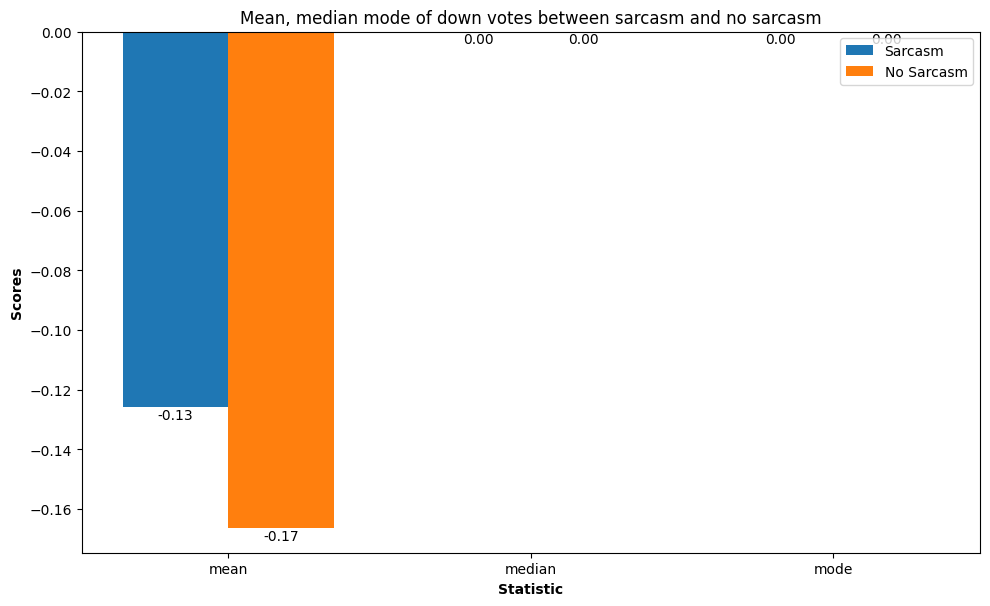

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(combined_stats))

bar1 = ax.bar(index, combined_stats['Sarcasm'], bar_width, label='Sarcasm')
bar2 = ax.bar(index + bar_width, combined_stats['No Sarcasm'], bar_width, label='No Sarcasm')

# Add labels
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height - 0.005, f'{height:.2f}', ha='center', va='bottom')

add_labels(bar1)
add_labels(bar2)

ax.set_xlabel('Statistic', fontweight='bold')
ax.set_ylabel('Scores', fontweight='bold')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(combined_stats.index)
ax.legend()

plt.tight_layout()
plt.title('Mean, median mode of down votes between sarcasm and no sarcasm')
plt.show()

**Conclusion**: Turns out that being sarcastic does not translate very well to upvotes and scores, as the means of no sarcasm is higher than that of sarcasm. While the mean downvote of sarcastic comments is slightly less (less negative) than no sarcasm, the difference seems minimal compared to scores and upvotes.

### 1.7 Data Exploration: Subreddit column of sarcasm vs no sarcasm
Lastly, we can also look into the subreddits and identify any relationships in the proportion of sarcastic comments.

In [ ]:
print(comments_df['subreddit'].value_counts())
print(comments_df['subreddit'].value_counts().describe())

subreddit
AskReddit              63740
politics               37826
worldnews              25311
leagueoflegends        20062
pcmasterrace           18374
                       ...  
GeoLibertarianism          1
prograrticles              1
StopBullyingComics         1
Homefront                  1
IdBuyThatForADollar        1
Name: count, Length: 14663, dtype: int64
count    14663.000000
mean        66.404556
std        830.718580
min          1.000000
25%          1.000000
50%          2.000000
75%          9.000000
max      63740.000000
Name: count, dtype: float64


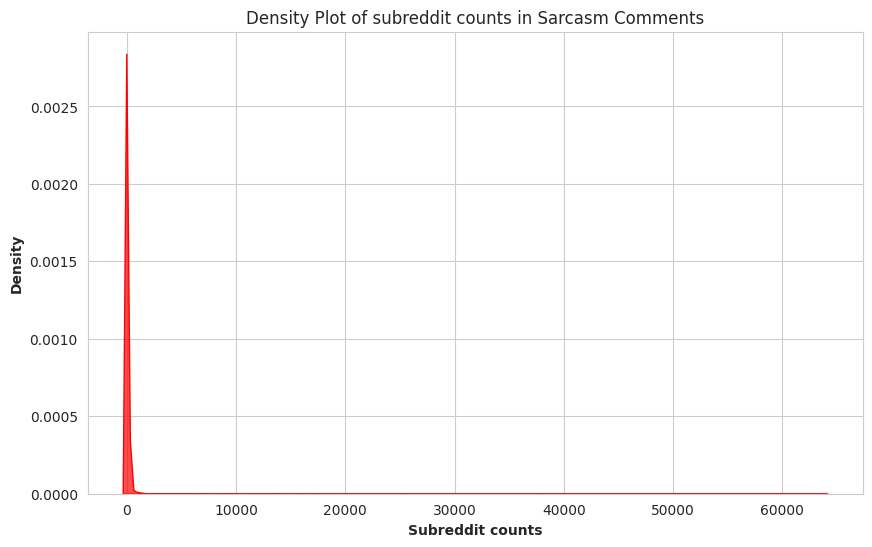

In [ ]:
sns.set_style("whitegrid")

plt.figure(figsize=(10, 6))
sns.kdeplot(comments_df['subreddit'].value_counts(), fill=True, color="r", alpha=0.7)

plt.title('Density Plot of subreddit counts in Sarcasm Comments')
plt.xlabel('Subreddit counts', fontweight='bold')
plt.ylabel('Density', fontweight='bold')

plt.show()


As seen, the data is very right skewed, and hence we can filter for subreddits above the count of the mean, 66.439285, to do an analysis.

In [ ]:
subreddit_counts = comments_df.groupby('subreddit').size().sort_values()
print(len(subreddit_counts))
filtered_subreddit_counts = subreddit_counts[subreddit_counts > 66.439285]
print(f'There are {len(filtered_subreddit_counts)} subreddits above the mean')

14663
There are 1227 subreddits above the mean


In [ ]:
print(filtered_subreddit_counts)
# print(filtered_subreddit_counts.index)
# print('canadients' in filtered_subreddit_counts.index)

subreddit
gainit                67
madlads               67
bonnaroo              67
VictoriaBC            67
watch_dogs            67
                   ...  
pcmasterrace       18374
leagueoflegends    20062
worldnews          25311
politics           37826
AskReddit          63740
Length: 1227, dtype: int64


In [ ]:
subreddit_df = comments_df[comments_df['subreddit'].isin(filtered_subreddit_counts.index)]
# print(len(subreddit_df)) #887560
print(subreddit_df['subreddit'].value_counts()) #Length: 1228

subreddit
AskReddit          63740
politics           37826
worldnews          25311
leagueoflegends    20062
pcmasterrace       18374
                   ...  
ArcherFX              67
altright              67
bonnaroo              67
VictoriaBC            67
gainit                67
Name: count, Length: 1227, dtype: int64


In [ ]:
total_comments_per_subreddit = subreddit_df.groupby('subreddit').size().reset_index(name='total_comments')

sarcasm_subreddit = subreddit_df[subreddit_df['label'] == 1].groupby('subreddit').size().reset_index(name='sarcasm_comments')
no_sarcasm_subreddit = subreddit_df[subreddit_df['label'] == 0].groupby('subreddit').size().reset_index(name='no_sarcasm_comments')

# megre total_comments_per_subreddit and sarcasm_subreddit
subreddit_label_proportions = pd.merge(total_comments_per_subreddit, sarcasm_subreddit, on='subreddit')

# merge exisitng df with no_sarcasm_subreddit
subreddit_label_proportions = pd.merge(subreddit_label_proportions, no_sarcasm_subreddit, on='subreddit')
# print(subreddit_label_proportions)

# Calculate and add new columns
subreddit_label_proportions['sarcasm_prop'] = subreddit_label_proportions['sarcasm_comments'] / subreddit_label_proportions['total_comments']
subreddit_label_proportions['no_sarcasm_prop'] = subreddit_label_proportions['no_sarcasm_comments'] / subreddit_label_proportions['total_comments']
subreddit_label_proportions = subreddit_label_proportions.sort_values(by='sarcasm_prop', ascending=False)

print(subreddit_label_proportions.head(6))

             subreddit  total_comments  sarcasm_comments  no_sarcasm_comments  \
692          creepyPMs            5296              4170                 1126   
409          PussyPass              81                60                   21   
890    libertarianmeme              98                71                   27   
451   ShitPoliticsSays             271               196                   75   
670        circlebroke             164               118                   46   
1027            progun             503               360                  143   

      sarcasm_prop  no_sarcasm_prop  
692       0.787387         0.212613  
409       0.740741         0.259259  
890       0.724490         0.275510  
451       0.723247         0.276753  
670       0.719512         0.280488  
1027      0.715706         0.284294  


Based on the descriptions

* creepyPMs: A place for people to share the strange and disturbing PMs they get from all over the internet. We encourage all kinds of posts from mildly off-putting to slightly weird to downright scary.

* libertarianmeme: The best libertarian memes, macros, photos, jokes, and conversations on Reddit.

* ShitPoliticsSays: The Worst Political Commentary on Reddit - Boldly Chronicling the Decline of Humanity Since 2013

* circlebroke: the complainingest place on earth burn it all down

* progun: Posts must be related to Firearms & Second Amendment Politics. Please engage in Civil Discussion. This is a place for discussion and debate of Second Amendment related topics, with a Pro-2A emphasis. Civil debate is welcome and encouraged. Even if you're completely opposed to 2A, you're welcome to share your thoughts here, as long as you maintain civility.

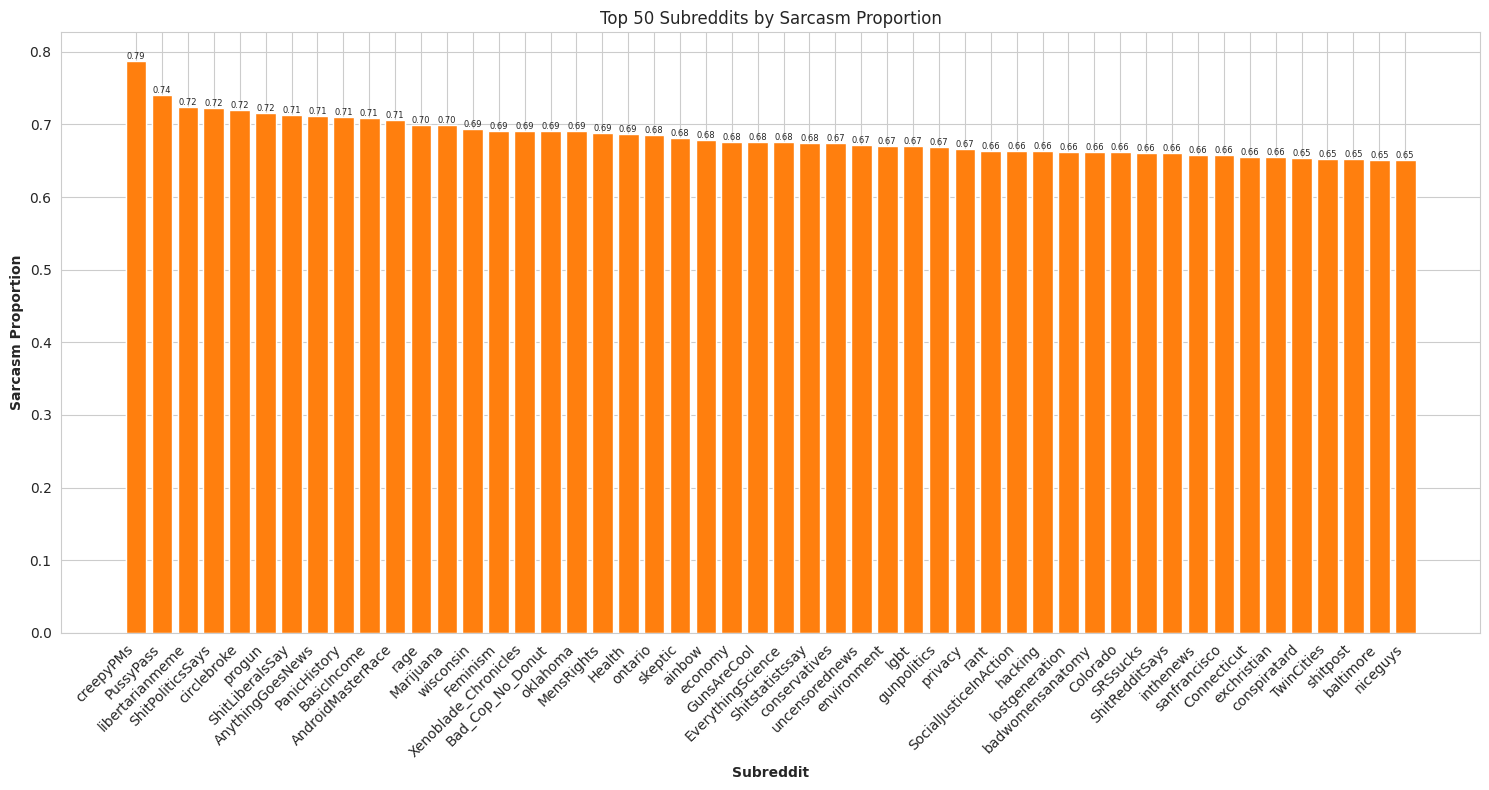

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.bar(subreddit_label_proportions['subreddit'].head(50), subreddit_label_proportions['sarcasm_prop'].head(50))

bars = ax.bar(subreddit_label_proportions['subreddit'].head(50), subreddit_label_proportions['sarcasm_prop'].head(50))

ax.set_xticks(range(50))
ax.set_xticklabels(subreddit_label_proportions['subreddit'].head(50), rotation=45, ha='right')
ax.set_ylabel('Sarcasm Proportion', fontweight='bold')
ax.set_xlabel('Subreddit', fontweight='bold')
ax.set_title('Top 50 Subreddits by Sarcasm Proportion')

# Add labels
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom', fontsize=6)

plt.tight_layout()
plt.show()

# 2 Additional EDA & Final Feature Extraction

We will continue to develop the EDA here, and then proceed to alter our original dataframe with new features so that it's ready for modelling.

At the end of this section, we will have : a finalized dataframe that is ready for word embedding / modelling without word embeddings or vector representations of comments

## 2.1 Basic Preprocessing

In [ ]:
# Numpy and Pandas
import numpy as np
import pandas as pd

# Spacy, Nltk, Textblob, regex
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
import re

# visualizations : seaborn, matplotlib, wordcloud
import seaborn as sns
import matplotlib.style as style
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn import set_config
set_config(display="diagram")

# Scipy Stats
from scipy.stats import ttest_ind

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/CS3244/train-balanced-sarcasm.csv')

# Remove Duplicate
comments_df = df.drop_duplicates().reset_index(drop=True)

# Keep a certain subset
comments_df = comments_df[ ['label', 'comment', 'subreddit',
                            'score', 'ups', 'downs', 'parent_comment']]
# drop null observations
comments_df = comments_df.dropna(subset = ["comment"])

# Need to further drop more duplicates
len_duplicates = comments_df.duplicated(subset=['comment', 'parent_comment'], keep=False).sum()
print(f'there were {len_duplicates} more duplicates that were not caught in the previous EDA')
comments_df = comments_df.drop_duplicates(subset=['comment', 'parent_comment'], keep='first')

there were 1232 more duplicates that were not caught in the previous EDA


In [ ]:
#Outlier removal using comment_length
comments_df['comment_length'] = comments_df['comment'].apply(lambda x: len(x.split(" ")))
q3, q1 = np.percentile(comments_df['comment_length'], [75 ,25])
iqr = q3 - q1
print(f'Previous length of dataset {len(comments_df)}')
comments_df = comments_df[
    (comments_df['comment_length'] > (q1 - 1.5 * iqr)) &
    (comments_df['comment_length'] < (q3 + 1.5 * iqr))
]
print(f'New length of dataset {len(comments_df)}')

Previous length of dataset 1009964
New length of dataset 973692


In [ ]:
# Checking to see balance
sarcasm_df = comments_df[comments_df['label'] == 1].copy().reset_index(drop=True)
no_sarcasm_df = comments_df[comments_df['label'] == 0].copy().reset_index(drop=True)
print(f'The length of the entire dataset is {len(comments_df)}')
print(f'The length of the no sarcasm dataset is {len(no_sarcasm_df)}')
print(f'The length of the sarcasm dataset is {len(sarcasm_df)}')

The length of the entire dataset is 973692
The length of the no sarcasm dataset is 481208
The length of the sarcasm dataset is 492484


 ## 2.2 Feature 1: Number of Special Characters**

  * This was previously covered by Kai Jun so we will not do plots here
  * His finding was that sarcastic comments tended to have more special characters

In [ ]:
# Create function to check for special punctuation
def check_special_punctuation(comment):
    pattern = r"(\?|!|\.\.\.)$"
    if re.search(pattern, comment):
        return 1
    else:
        return 0

# check to see the results
sarcasm_df['end_with_special_punctuation'] = sarcasm_df['comment'].apply(check_special_punctuation)
no_sarcasm_df['end_with_special_punctuation'] = no_sarcasm_df['comment'].apply(check_special_punctuation)

# Display the results
print(f"The number of comments that end with special punctuation for sarcastic comments are {sum(sarcasm_df['end_with_special_punctuation'])}")
print(f"The number of comments that end with special punctuation for non sarcastic comments are {sum(no_sarcasm_df['end_with_special_punctuation'])}")

# Add the feature to the dataframe
comments_df['end_with_special_punctuation'] = comments_df['comment'].apply(lambda x : check_special_punctuation(x))
comments_df.head(3)

The number of comments that end with special punctuation for sarcastic comments are 139286
The number of comments that end with special punctuation for non sarcastic comments are 101685


label                                            comment subreddit  score  \
0      0                                         NC and NH.  politics      2   
1      0  You do know west teams play against west teams...       nba     -4   
2      0  They were underdogs earlier today, but since G...       nfl      3   

   ups  downs                                     parent_comment  \
0   -1     -1  Yeah, I get that argument. At this point, I'd ...   
1   -1     -1  The blazers and Mavericks (The wests 5 and 6 s...   
2    3      0                            They're favored to win.   

   comment_length  end_with_special_punctuation  
0               3                             0  
1              14                             1  
2              19                             0

## 2.3 Feature 2: Sarcasm Proportion
* Proportion of sarcastic comments to non-sarcastic comments serve as a useful proxy for how politically charged a subreddit is
* This is a useful feature


### 2.3.1 MOTIVATION
  * Initially, we had calculated the sarcasm comment proportions within subreddits
  * We further extend the analysis to cover not just subreddits with the highest sarcasm proportion, but also subreddits with the lowest sarcasm proportion

### CONCLUSION
  * We find that the sarcasm proportions actually give rise to an observable trend in the subreddits - subreddits with high proportions of sarcastic comments tend to center around topics that are political / right wing / left wing / gendered in nature
  * However, we find that subreddits with low proportions of sarcastic comments are directly politically neutral - the top 50 subreddits have almost no notion of political influence / ideology / have no "gender nuances"
  * Hence, we use the sarcasm proportion as a numerical measure of a subreddit's political nature
  * Additionally, we find that this feature is actually - Gaussian. This makes is very compatible with Linear Models that might assume the underlying predictors are Gaussian

In [ ]:
# We find that some subreddits have low subreddit count
subreddit_counts = comments_df.groupby('subreddit').size().sort_values()
print(len(subreddit_counts))

# so we remove them for analysis
filtered_subreddit_counts = subreddit_counts[subreddit_counts > 66.439285]
print(len(filtered_subreddit_counts))

# filter
subreddit_df = comments_df[comments_df['subreddit'].isin(filtered_subreddit_counts.index)]

14663
1227


In [ ]:
# Gives you the number of observations for each subreddit
total_comments_per_subreddit = (subreddit_df.groupby('subreddit').size().reset_index(name='total_comments'))

# Gives you the number of observations with label = 1 for each subreddit
sarcasm_subreddit = (subreddit_df[subreddit_df['label'] == 1].groupby('subreddit').size().reset_index(name='sarcasm_comments'))

# Gives you the number of observations with label = 0 for each subreddit
no_sarcasm_subreddit = (subreddit_df[subreddit_df['label'] == 0].groupby('subreddit').size().reset_index(name='no_sarcasm_comments'))

In [ ]:
# ALL MERGE CELLS SHOULD BE IN SEPERATE BLOCKS
# this gives you : for each distinct subreddit, the count of comments, the count of label = 0, the count of label = 1
subreddit_label_proportions = pd.merge(total_comments_per_subreddit, sarcasm_subreddit, on='subreddit')
subreddit_label_proportions = pd.merge(subreddit_label_proportions, no_sarcasm_subreddit, on='subreddit')

In [ ]:
# Compute the proportion statistics
subreddit_label_proportions['sarcasm_prop'] = subreddit_label_proportions['sarcasm_comments'] / subreddit_label_proportions['total_comments']
subreddit_label_proportions['no_sarcasm_prop'] = subreddit_label_proportions['no_sarcasm_comments'] / subreddit_label_proportions['total_comments']

### 2.3.2 The Top 50 most Sarcastic Subreddits plot.
  * Most are gendered / political topics (left wing, right wing, republican opinions on guns

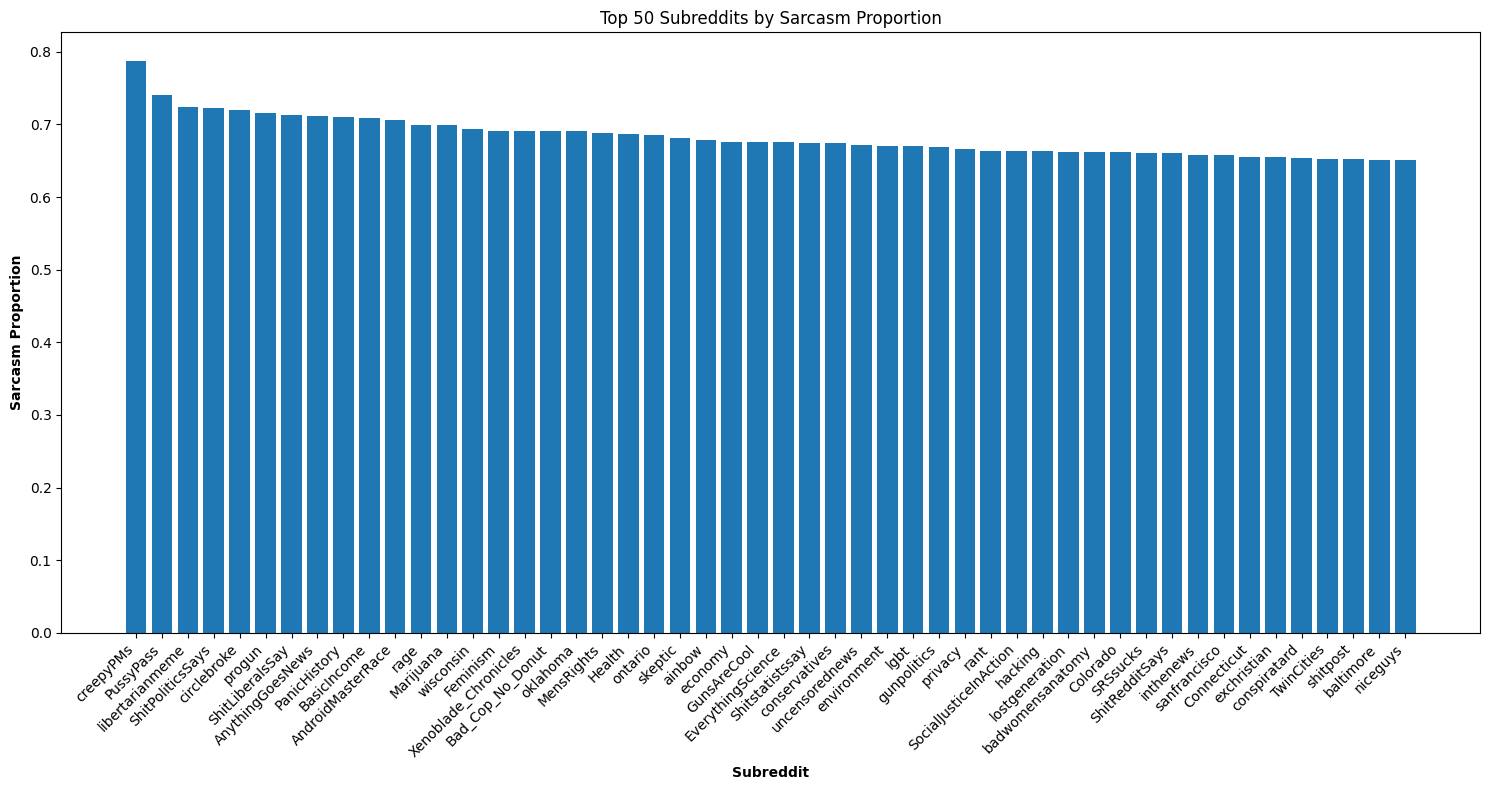

In [ ]:
# Get the top 50 most sarcastic subreddits
subreddit_label_proportions = subreddit_label_proportions.sort_values(by='sarcasm_prop', ascending=False)

# Plot the results
fig, ax = plt.subplots(figsize=(15, 8))
ax.bar(subreddit_label_proportions['subreddit'].head(50), subreddit_label_proportions['sarcasm_prop'].head(50))

ax.set_xticks(range(50))
ax.set_xticklabels(subreddit_label_proportions['subreddit'].head(50), rotation=45, ha='right')
ax.set_ylabel('Sarcasm Proportion', fontweight='bold')
ax.set_xlabel('Subreddit', fontweight='bold')
ax.set_title('Top 50 Subreddits by Sarcasm Proportion')

plt.tight_layout()
plt.show()

### 2.3.3  Top 50 least sarcastic subreddit plot
  * Most subreddits are a-political in nature / gender neutral (i.e. not bias towards men or women)

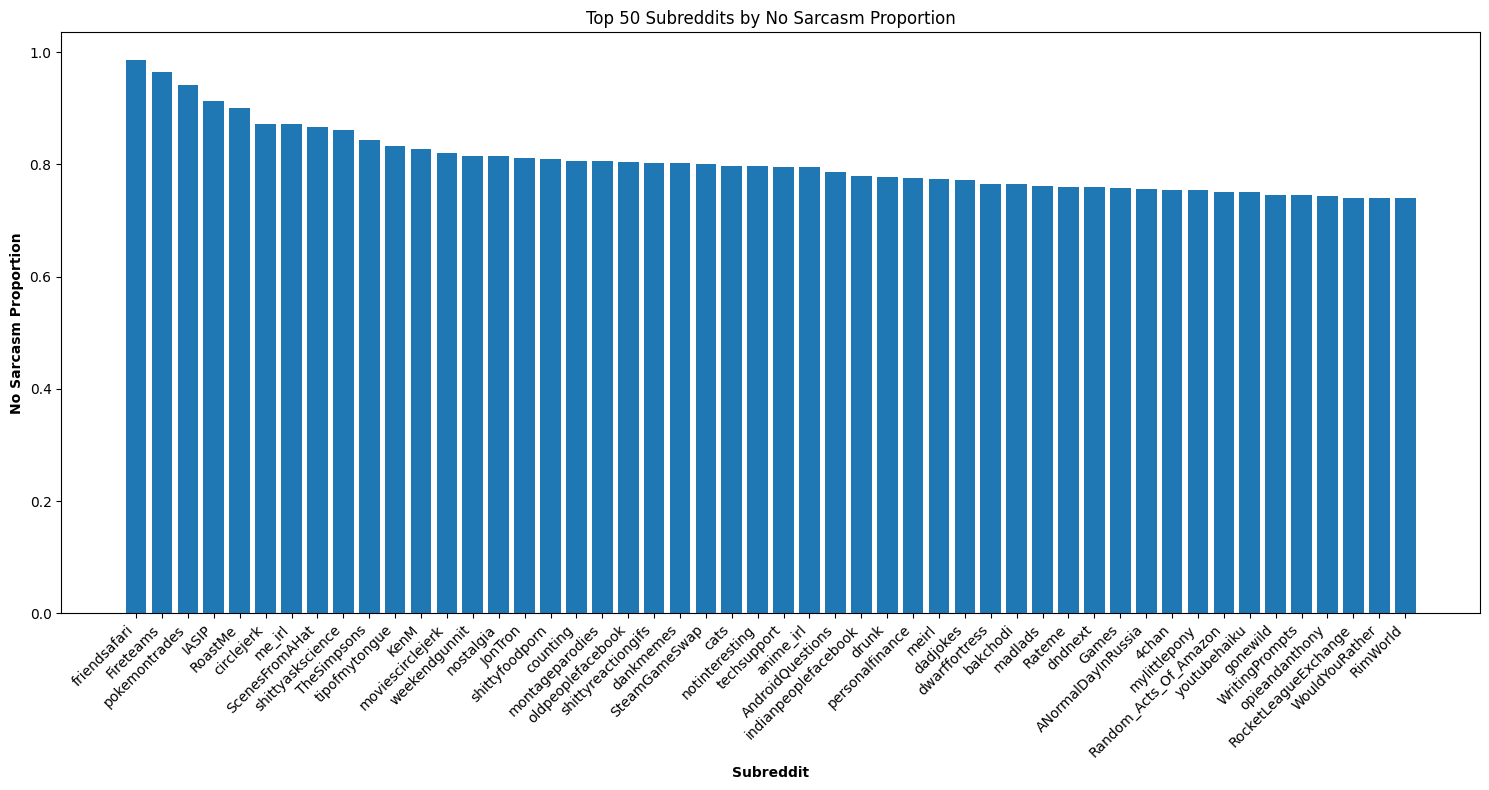

In [ ]:
# Get the 50 least sarcastic subreddits
subreddit_label_proportions_2 = subreddit_label_proportions.sort_values(by='no_sarcasm_prop', ascending=False).copy()

# Plot the results
fig, ax = plt.subplots(figsize=(15, 8))
ax.bar(subreddit_label_proportions_2['subreddit'].head(50), subreddit_label_proportions_2['no_sarcasm_prop'].head(50))

ax.set_xticks(range(50))
ax.set_xticklabels(subreddit_label_proportions_2['subreddit'].head(50), rotation=45, ha='right')
ax.set_ylabel('No Sarcasm Proportion', fontweight='bold')
ax.set_xlabel('Subreddit', fontweight='bold')
ax.set_title('Top 50 Subreddits by No Sarcasm Proportion')

plt.tight_layout()
plt.show()

### 2.3.4 Gaussian Nature of subreddit sarcasm proportion

  * This Gaussian distribution might lend itself well to linear models

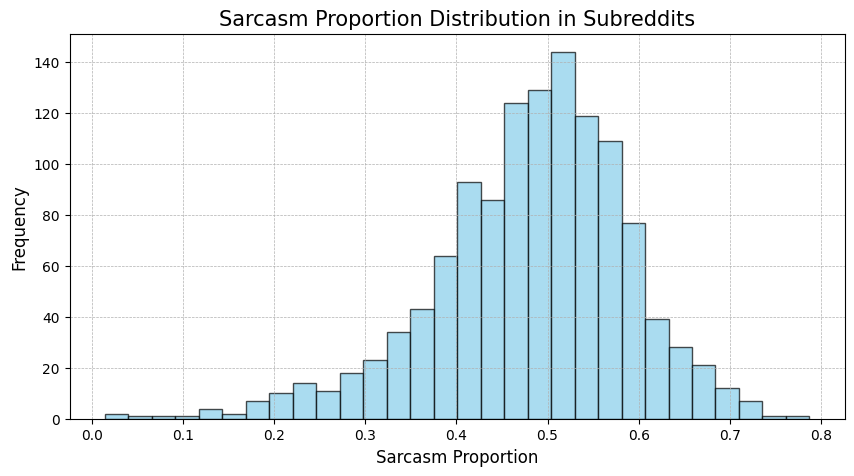

In [ ]:
plt.figure(figsize=(10, 5))  # Sets the figure size
plt.hist(subreddit_label_proportions['sarcasm_prop'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)

# Adding aesthetics
plt.title('Sarcasm Proportion Distribution in Subreddits', fontsize=15)
plt.xlabel('Sarcasm Proportion', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Optional: Add a grid for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show the plot
plt.show()

### 2.3.5 Creating the Feature

In [ ]:
# Create the feature
# THIS IS A MERGE CELL. RUN ONLY ONCE
subreddit_label_proportions = subreddit_label_proportions[['subreddit', 'sarcasm_prop']]
comments_df = pd.merge(comments_df, subreddit_label_proportions, how='left', on='subreddit')

In [ ]:
# Mean imputation for observations where sarcasm_prop was not appropriate
comments_df['sarcasm_prop'] = comments_df['sarcasm_prop'].fillna(comments_df['sarcasm_prop'].mean())
comments_df.head(3)

label                                            comment subreddit  score  \
0      0                                         NC and NH.  politics      2   
1      0  You do know west teams play against west teams...       nba     -4   
2      0  They were underdogs earlier today, but since G...       nfl      3   

   ups  downs                                     parent_comment  \
0   -1     -1  Yeah, I get that argument. At this point, I'd ...   
1   -1     -1  The blazers and Mavericks (The wests 5 and 6 s...   
2    3      0                            They're favored to win.   

   comment_length  end_with_special_punctuation  sarcasm_prop  
0               3                             0      0.612595  
1              14                             1      0.530739  
2              19                             0      0.513177

## 2.4 Feature 3: comments length vs parents comment length
  * this feature is created by taking the natural log of comments length / parent comments' length
  * the feature follows a gaussian distribution (approximately) once outliers are removed

In [ ]:
# Create the feature first
df2 = comments_df.copy()
df2['parent_length'] = df2['parent_comment'].apply(lambda x : len(x.split(" ")))
df2['comment_parent_ratio'] = df2['comment_length'] / df2['parent_length']

print(df2[df2['label'] == 1]['comment_parent_ratio'].mean())
print(df2[df2['label'] == 0]['comment_parent_ratio'].mean())

0.9687527021989001
0.9714824897070276


In [ ]:
# Functions that made investigating outliers simpler
def iqr_analysis(series, iqr_tries, series_name):
    for i in iqr_tries:
        # First, calculate IQR and identify outliers for sarcastic comments
        q25, q75 = np.percentile(series, 25), np.percentile(series, 75)
        iqr = q75 - q25

        # Adjusting the series by removing outliers
        outlier_low = q25 - i * iqr
        outlier_high = q75 + i * iqr
        series_adj = series[(series > outlier_low) & (series < outlier_high)]

        # Outlier scores for statistics (using the correct bounds as used for filtering)
        outlier_scores = pd.Series([x for x in series if x < outlier_low or x > outlier_high])

        # Histogram of adjusted scores
        series_adj.hist()
        plt.show()

        # Printing Statistics
        print(f'after removing {outlier_scores.shape[0]} outliers, which is {round(outlier_scores.shape[0]/series.shape[0],2)*100}% original')
        print(f'which have a mean of {outlier_scores.mean()} & median of {outlier_scores.median()}')
        print(f'the mean score of {series_name} is {series_adj.mean()} & median is {series_adj.median()}')

def remove_outliers(series, multiplier):
    q25, q75 = np.percentile(series, 25), np.percentile(series, 75)
    iqr = q75 - q25

    # Adjusting the series by removing outliers
    outlier_low = q25 - multiplier * iqr
    outlier_high = q75 + multiplier * iqr
    series_adj = series[(series > outlier_low) & (series < outlier_high)]
    return series_adj

#### 2.4.1 Plot of the Gaussian Distribution of the feature

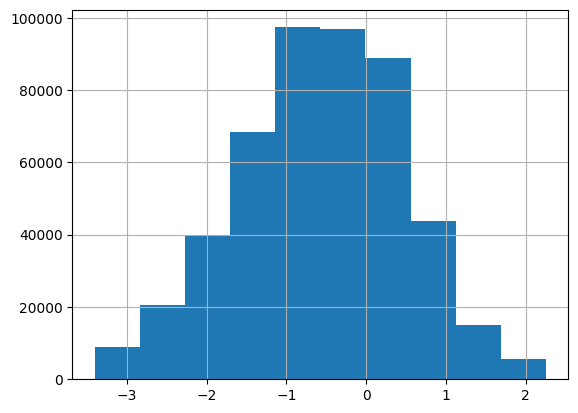

after removing 7639 outliers, which is 2.0% original
which have a mean of -2.0793004570502567 & median of -3.6109179126442243
the mean score of sarcastic c/p/r is -0.5781733644072695 & median is -0.5306282510621704


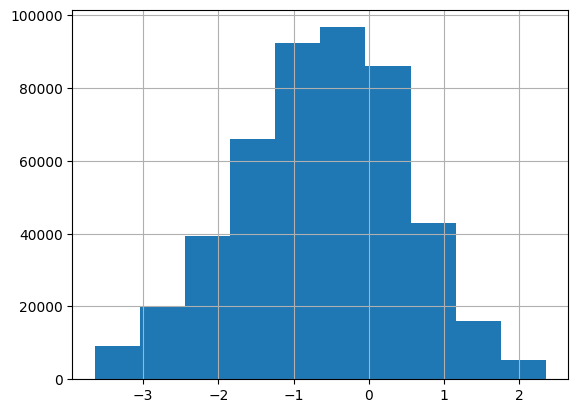

after removing 7413 outliers, which is 2.0% original
which have a mean of -2.395966830290304 & median of -3.8712010109078907
the mean score of non-sarcastic c/p/r is -0.635576835673759 & median is -0.5753641449035618


In [ ]:
iqr_analysis(np.log(df2[df2['label'] == 1]['comment_parent_ratio']), [1.5], 'sarcastic c/p/r')
iqr_analysis(np.log(df2[df2['label'] == 0]['comment_parent_ratio']), [1.5], 'non-sarcastic c/p/r')

In [ ]:
t_stat, p_value = ttest_ind(remove_outliers(np.log(df2[df2['label'] == 1]['comment_parent_ratio']), 1.5),
                            remove_outliers(np.log(df2[df2['label'] == 0]['comment_parent_ratio']), 1.5))
print(f'p-value: {p_value}')
print('we have evidence to suggest the means are statistically different')

#### 2.4.2 Create the feature

In [ ]:
comments_df['comment_length'] = comments_df['comment'].apply(lambda x : len(x.split(" ")))
comments_df['parent_length'] = comments_df['parent_comment'].apply(lambda x : len(x.split(" ")))
comments_df['comment_parent_ratio'] = comments_df['comment_length'] / comments_df['parent_length']
comments_df['ln_comment_parent_ratio'] = np.log(comments_df['comment_parent_ratio'])

comments_df = comments_df.drop('parent_length', axis=1)
comments_df = comments_df.drop('comment_length', axis=1)
comments_df = comments_df.drop('comment_parent_ratio', axis=1)

In [ ]:
comments_df.head(3)

label                                            comment subreddit  score  \
0      0                                         NC and NH.  politics      2   
1      0  You do know west teams play against west teams...       nba     -4   
2      0  They were underdogs earlier today, but since G...       nfl      3   

   ups  downs                                     parent_comment  \
0   -1     -1  Yeah, I get that argument. At this point, I'd ...   
1   -1     -1  The blazers and Mavericks (The wests 5 and 6 s...   
2    3      0                            They're favored to win.   

   end_with_special_punctuation  sarcasm_prop  ln_comment_parent_ratio  
0                             0      0.612595                -1.734601  
1                             1      0.530739                -0.656780  
2                             0      0.513177                 1.558145

## 2.5 Feature 4 Subjectivity of Comment and Parent

* To a very limited extent - this feature tells us about sarcasm. However, splitting the data into therciles reveals a specific trend after removing outliers
* We still incorporate this feature into our model

### 2.5.1 MOTIVATION
  * Sarcastic comments typically aim to offend a target in response to that said target's actions or reponses
  * Sarcastic comments also tend to highlight the stupidity of the said target
  * If that is the case, we might not be unreasonable in assuming that subjective comments create more room for sarcastic replies

### CONCLUSION
  * We find that, when grouping observations based on the subjectiveness of the comments themselves and the parent comment, we can see trends that help us differentiate between sarcastic and non-sarcastic comments
  * However, the patterns we observe do not match our prior suspicions that subjective parent comments breed sarcastic comments
  * Despite this fact, we will used the discovered patterns in our prediction task.
  * We run the risk of fitting a pattern that does not generalize well to future comments, but we will observe what results this feature brings us

In [ ]:
# Create a function to compute subjectivity
def calculate_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# calculate subjectivity
comments_df['subjectivity_comment'] = comments_df['comment'].apply(lambda x : calculate_subjectivity(x))
comments_df['subjectivity_parent'] = comments_df['parent_comment'].apply(lambda x : calculate_subjectivity(x))

### 2.5.2 Plot of Distribution of subjectivity of comments / parent comments

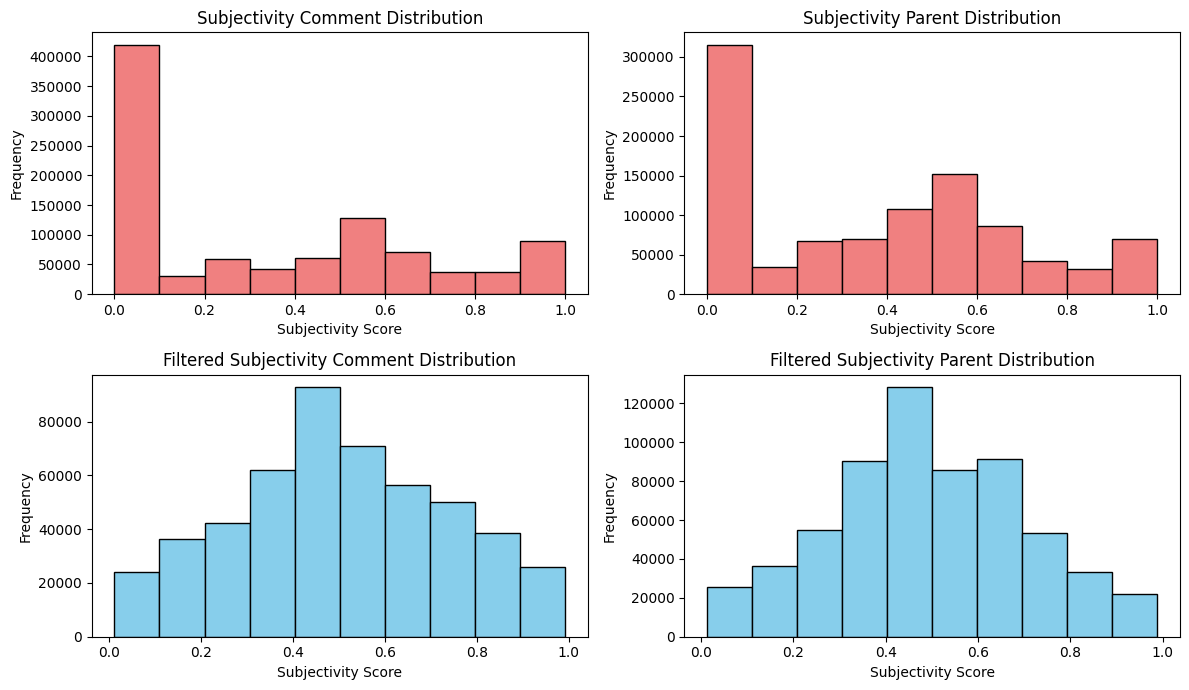

In [ ]:
# Make a copy to make modifications on
df2 = comments_df.copy()

# Create a 2x2 subplot layout
fig, axs = plt.subplots(2, 2, figsize=(12, 7))

# Plotting the first histogram (full data for subjectivity_comment)
axs[0, 0].hist(df2['subjectivity_comment'], color="lightcoral", edgecolor='black')
axs[0, 0].set_title('Subjectivity Comment Distribution')
axs[0, 0].set_xlabel('Subjectivity Score')
axs[0, 0].set_ylabel('Frequency')

# Plotting the second histogram (full data for subjectivity_parent)
axs[0, 1].hist(df2['subjectivity_parent'], color="lightcoral", edgecolor='black')
axs[0, 1].set_title('Subjectivity Parent Distribution')
axs[0, 1].set_xlabel('Subjectivity Score')
axs[0, 1].set_ylabel('Frequency')

# Filtering comments != 0 and != 1
comments = df2['subjectivity_comment'][(df2['subjectivity_comment'] != 0) & (df2['subjectivity_comment'] != 1)]
# Plotting the third histogram (filtered subjectivity_comment)
axs[1, 0].hist(comments, color='skyblue', edgecolor='black')
axs[1, 0].set_title('Filtered Subjectivity Comment Distribution')
axs[1, 0].set_xlabel('Subjectivity Score')
axs[1, 0].set_ylabel('Frequency')

# Filtering parents != 0 and != 1
parents = df2['subjectivity_parent'][(df2['subjectivity_parent'] != 0) & (df2['subjectivity_parent'] != 1)]
# Plotting the fourth histogram (filtered subjectivity_parent)
axs[1, 1].hist(parents, color='skyblue', edgecolor='black')
axs[1, 1].set_title('Filtered Subjectivity Parent Distribution')
axs[1, 1].set_xlabel('Subjectivity Score')
axs[1, 1].set_ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

### 2.5.3 Scatter Plot to see if comment subjectivity creates an obvious decision boundary - it does not

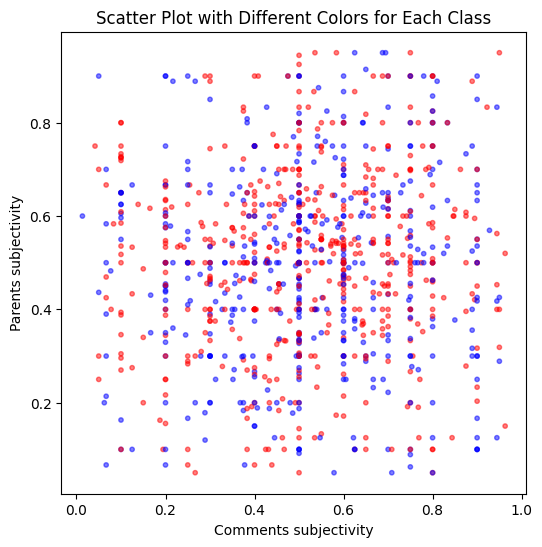

In [ ]:
df3 = df2[(df2['subjectivity_comment'] != 0) &
         (df2['subjectivity_comment'] != 1) &
         (df2['subjectivity_parent'] != 0) &
         (df2['subjectivity_parent'] != 1)].copy()

class_to_color = {
    1: 'red',
    0: 'blue',
}
sample_df3 = df3.sample(n=1000)
colors = sample_df3['label'].map(class_to_color)

plt.figure(figsize=(6, 6))

plt.scatter(sample_df3['subjectivity_comment'], sample_df3['subjectivity_parent'], alpha=0.5, s=10, c=colors)
plt.title('Scatter Plot with Different Colors for Each Class')
plt.xlabel('Comments subjectivity')
plt.ylabel('Parents subjectivity')
plt.show()

### 2.5.4 Clustered Bar Plots to check to see if - we can identify any patterns if we split the subjectivity of the comments by quantile

In [ ]:
# Split into suitable groups
df3['subjectivity_comment_thercile'] = pd.qcut(df3['subjectivity_comment'],
                                               3,
                                               labels=['c_obj', 'c_neut', 'c_subj'])

# Split into suitable groups
df3['subjectivity_parent_thercile'] = pd.qcut(df3['subjectivity_parent'],
                                              3,
                                              labels=['p_obj', 'p_neut', 'p_subj'])

# get a dataframe for subjectivity analysis
df_subjectivity = df3[['label', 'comment', 'subjectivity_comment', 'subjectivity_parent', 'subjectivity_comment_thercile','subjectivity_parent_thercile']]
subjectivity_analysis = df_subjectivity.groupby(['label', 'subjectivity_comment_thercile', 'subjectivity_parent_thercile'])['comment'].count().reset_index()

# Create a new column
subjectivity_analysis['subjectivity_comment_thercile'] = subjectivity_analysis['subjectivity_comment_thercile'].astype(str)
subjectivity_analysis['subjectivity_parent_thercile'] = subjectivity_analysis['subjectivity_parent_thercile'].astype(str)
subjectivity_analysis['grp'] = subjectivity_analysis['subjectivity_comment_thercile'] + ' & ' + subjectivity_analysis['subjectivity_parent_thercile']

#Compute the values
category_sums = subjectivity_analysis.groupby('grp')['comment'].transform('sum')
subjectivity_analysis['ratio'] = subjectivity_analysis['comment'] / category_sums


# Pivot the DataFrame to get categories as index and labels as columns
subjectivity_analysis_pivot = subjectivity_analysis.pivot_table(index='grp',
                                                          columns='label',
                                                          values='ratio',
                                                          aggfunc='first')

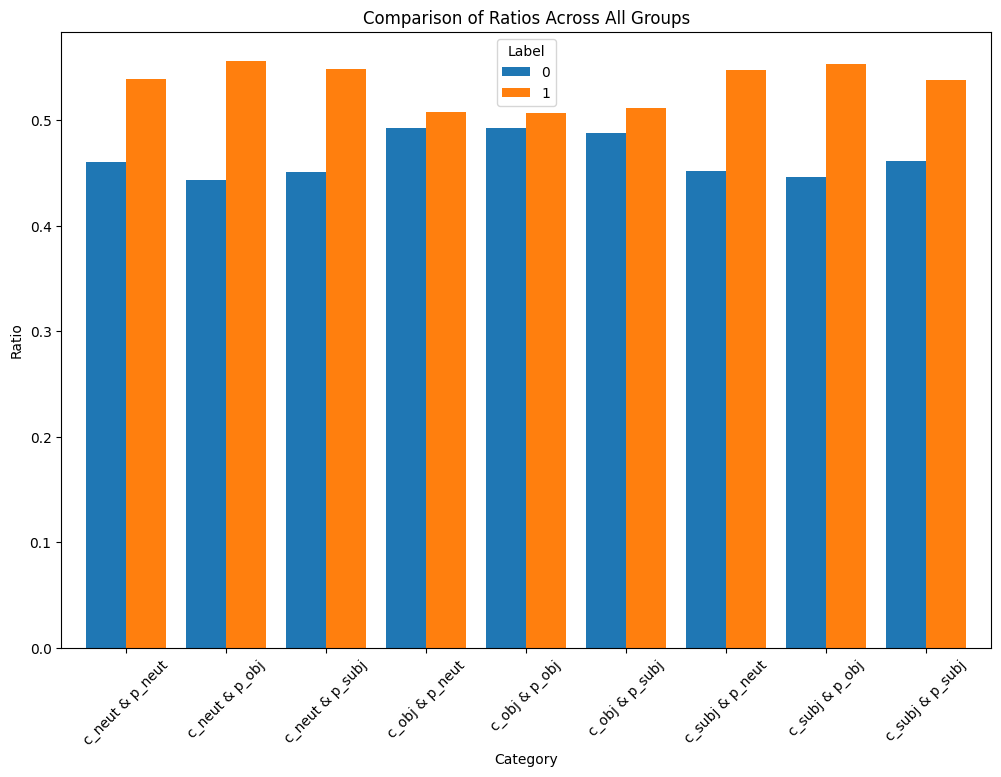

In [ ]:
# Plotting the grouped bar chart
subjectivity_analysis_pivot.plot(kind='bar', figsize=(12, 8), width=0.8)
plt.title('Comparison of Ratios Across All Groups')
plt.xlabel('Category')
plt.ylabel('Ratio')
plt.xticks(rotation=45)  # Rotate category labels for better readability
plt.legend(title='Label', labels=['0', '1'])
plt.show()

### 2.5.5 Creating the feature

In [ ]:
df3['subjectivity_category'] = (df3['subjectivity_comment_thercile']
                                 .apply(lambda x : 0 if x == 'c_obj' else 1))
df4 = df3[['label', 'comment', 'parent_comment', 'subjectivity_category']].copy()

In [ ]:
# THIS IS A MERGE CELL. RUN ONLY ONCE
comments_df = pd.merge(comments_df, df4, how='left', on=['comment', 'parent_comment'], validate = '1:1')
comments_df['subjectivity_category'] = comments_df['subjectivity_category'].fillna(0)

In [ ]:
comments_df = comments_df.drop('subjectivity_comment', axis = 1)
comments_df = comments_df.drop('subjectivity_parent', axis = 1)
comments_df = comments_df.drop('label_y', axis = 1)
comments_df = comments_df.rename(columns={'label_x': 'label'})
comments_df.head(3)

label                                            comment subreddit  score  \
0      0                                         NC and NH.  politics      2   
1      0  You do know west teams play against west teams...       nba     -4   
2      0  They were underdogs earlier today, but since G...       nfl      3   

   ups  downs                                     parent_comment  \
0   -1     -1  Yeah, I get that argument. At this point, I'd ...   
1   -1     -1  The blazers and Mavericks (The wests 5 and 6 s...   
2    3      0                            They're favored to win.   

   end_with_special_punctuation  sarcasm_prop  ln_comment_parent_ratio  \
0                             0      0.612595                -1.734601   
1                             1      0.530739                -0.656780   
2                             0      0.513177                 1.558145   

   subjectivity_category  
0                    0.0  
1                    1.0  
2                    1.0

## 2.6 Feature 5 Net Scores

  * Weak indicators of sarcasm. Probably not all that useful. We include it in the final dataframe just for completeness



### 2.6.1 MOTIVATION
  * Forums online indicate that Redditors have a tendency of being unncessarily sarcastic - potentially alluding that being sarcastic is a cultural norm of redditors
  * If that is the case, there is a possibiltiy that redditors positively reinforce this kind of behaviour - hence leading to the perpetuation of this culture
  * A method of positive reinforcement is upvotes / scores
  * Hence, we investigated whether we could find any patterns between comment score and sarcasm

### CONCLUSIONS
  * Net scores are weak indicators of sarcasm - they provide very little information
  * Even when conditioned on other variables like the level of "toxicity" within a subreddit, we find that net score difference between sarcastic and non-sarcastic comments are negligible

In [ ]:
# Helper functions
def remove_outliers(series, multiplier):
    q25, q75 = np.percentile(series, 25), np.percentile(series, 75)
    iqr = q75 - q25

    # Adjusting the series by removing outliers
    outlier_low = q25 - multiplier * iqr
    outlier_high = q75 + multiplier * iqr
    series_adj = series[(series > outlier_low) & (series < outlier_high)]
    return series_adj

def iqr_analysis(series, multiplier, series_name):
    # First, calculate IQR and identify outliers for sarcastic comments
    q25, q75 = np.percentile(series, 25), np.percentile(series, 75)
    iqr = q75 - q25

    # Adjusting the series by removing outliers
    outlier_low = q25 - multiplier * iqr
    outlier_high = q75 + multiplier * iqr
    series_adj = series[(series > outlier_low) & (series < outlier_high)]

    # Outlier scores for statistics (using the correct bounds as used for filtering)
    outlier_scores = pd.Series([x for x in series if x < outlier_low or x > outlier_high])

    # Printing Statistics
    print(f'after removing {outlier_scores.shape[0]} outliers, which is {round(outlier_scores.shape[0]/series.shape[0],2)*100}% original')
    print(f'which have a mean of {outlier_scores.mean()} & median of {outlier_scores.median()}')
    print(f'the mean score of {series_name} is {series_adj.mean()} & median is {series_adj.median()}')

### 2.6.2 Code to plot histograms of scores across sarcastic and non-sarcastic comments

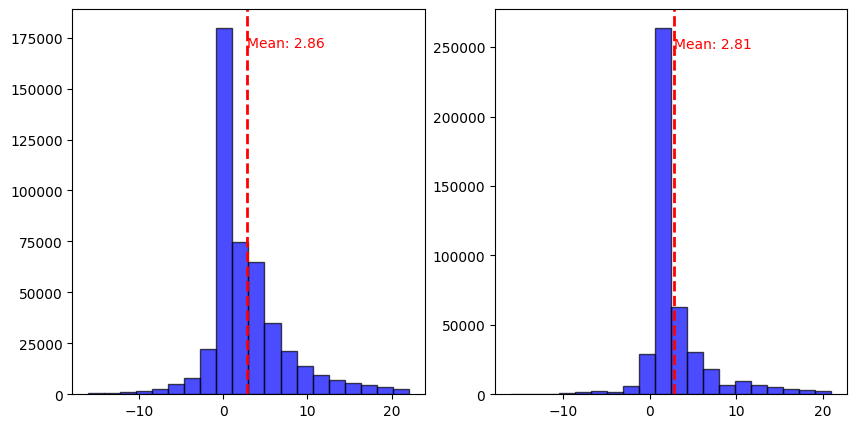

after removing 25846 outliers, which is 5.0% original
which have a mean of 68.75001934535325 & median of 39.0
the mean score of sarcastic comments is 2.8639075260819187 & median is 2.0
------------------------------------------------------------------------------------------
after removing 24611 outliers, which is 5.0% original
which have a mean of 92.26614115639349 & median of 41.0
the mean score of non-sarcastic comments is 2.8130128441656566 & median is 2.0


In [ ]:
# Split the data into sarcastic and non-sarcastic - and then remove outliers
sarc_df = comments_df[comments_df['label'] == 1]
nsarc_df = comments_df[comments_df['label'] == 0]
net_score_sarc = remove_outliers(sarc_df['score'], 4.5)
net_score_nsarc = remove_outliers(nsarc_df['score'], 6)

# Code to plot 1 x 2 grid
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
series_list = [net_score_sarc, net_score_nsarc]
axs_list = [axs[0], axs[1]]

for series, ax in zip(series_list, axs_list):
    # Calculate mean
    mean_value = np.mean(series)
    # Plot histogram
    ax.hist(series, bins=20, color='blue', edgecolor='black', alpha=0.7)
    # Plot mean line
    ax.axvline(mean_value, color='red', linestyle='dashed', linewidth=2)
    # Annotate mean value
    ax.text(mean_value, ax.get_ylim()[1] * 0.9, f'Mean: {mean_value:.2f}', color='red')
plt.show()


# additional code
iqr_analysis(sarc_df['score'], 4.5, 'sarcastic comments')
print('------------------------------------------------------------------------------------------')
iqr_analysis(nsarc_df['score'], 6, 'non-sarcastic comments')

### 2.6.3 Code to create dataframe for plotting

In [ ]:
crosswalk = subreddit_label_proportions[['subreddit', 'sarcasm_prop']].copy().reset_index(drop=True)

In [ ]:
# MERGE CELL for giving subreddits their
df5 = pd.merge(comments_df, crosswalk, on='subreddit', how='left')

In [ ]:
# Create the grouping
mean_val = df5['sarcasm_prop_x'].mean()
df5['sarcasm_prop_x'] = df5['sarcasm_prop_x'].fillna(mean_val)
df5['is_toxic'] = df5['sarcasm_prop_x'].apply(lambda x : 0 if x <= mean_val else 1)

### 2.6.4 The actual plots

In [ ]:
# Create the subgroups
toxic_df = df5[df5['is_toxic'] == 1]
toxic_sarcasm_df = toxic_df[toxic_df['label'] == 1]
toxic_nsarcasm_df = toxic_df[toxic_df['label'] == 0]

# Create the subgroups
wholesome_df = df5[df5['is_toxic'] == 0]
wholesome_sarcasm_df = wholesome_df[wholesome_df['label'] == 1]
wholesome_nsarcasm_df = wholesome_df[wholesome_df['label'] == 0]

# Create the series
toxic_sarcasm = remove_outliers(toxic_sarcasm_df['score'], 4.5)
toxic_nsarcasm = remove_outliers(toxic_nsarcasm_df['score'], 4.5)
wholesome_sarcasm = remove_outliers(wholesome_sarcasm_df['score'], 4.5)
wholesome_nsarcasm = remove_outliers(wholesome_nsarcasm_df['score'], 4.5)

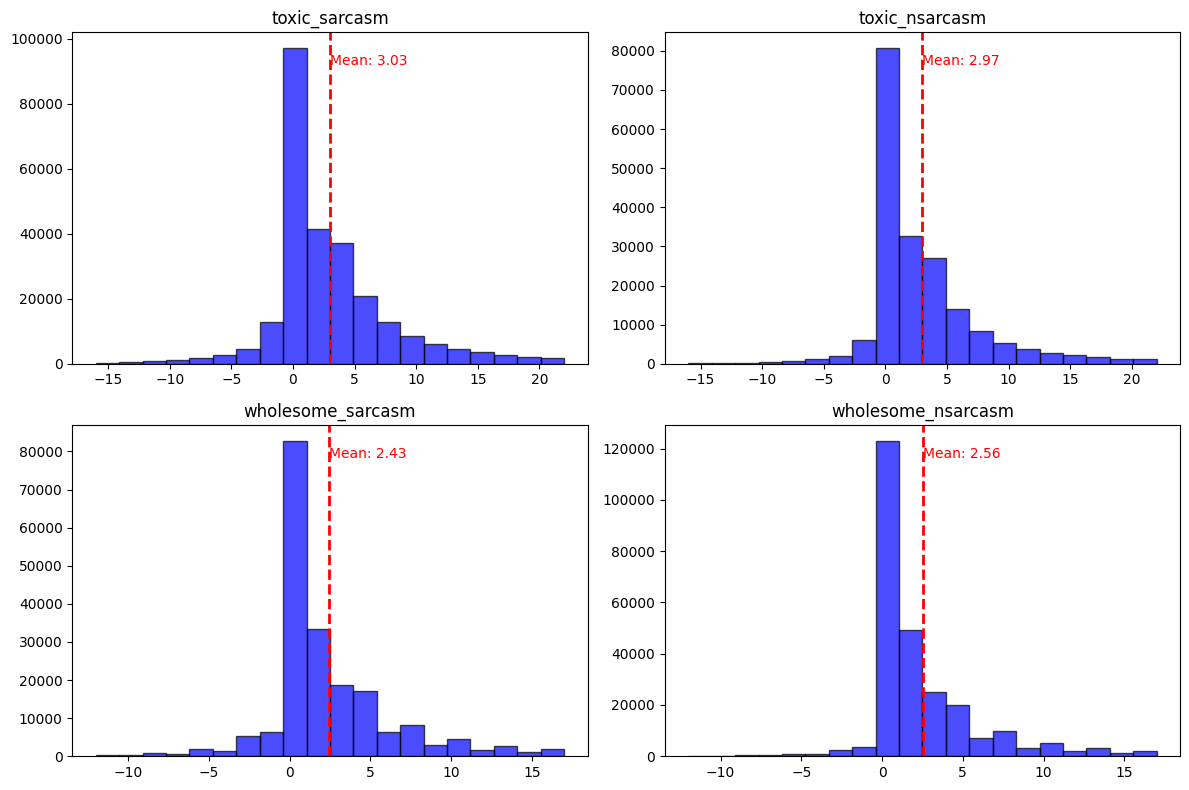

In [ ]:
# Plot

# Creating a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
series_list = [toxic_sarcasm , toxic_nsarcasm, wholesome_sarcasm , wholesome_nsarcasm]
axs_list = [axs[0, 0], axs[0, 1], axs[1, 0], axs[1, 1]]
names_list = ['toxic_sarcasm' , 'toxic_nsarcasm', 'wholesome_sarcasm' , 'wholesome_nsarcasm']

# Plot each series in its respective subplot
for series, ax, name in zip(series_list, axs_list, names_list):
    mean_value = np.mean(series)
    ax.hist(series, bins=20, color='blue', edgecolor='black', alpha=0.7)
    ax.axvline(mean_value, color='red', linestyle='dashed', linewidth=2)
    ax.text(mean_value, ax.get_ylim()[1] * 0.9, f'Mean: {mean_value:.2f}', color='red')
    ax.set_title(name)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

## 2.7 Final Dataframe with full list of features before word embeddings / TF-IDF

In [ ]:
final_df_features = comments_df.drop(['subreddit', 'ups', 'downs', 'parent_comment'], axis=1).reset_index(drop=True)
final_df_features.head(3)

label                                            comment  score  \
0      0                                         NC and NH.      2   
1      0  You do know west teams play against west teams...     -4   
2      0  They were underdogs earlier today, but since G...      3   

   end_with_special_punctuation  sarcasm_prop  ln_comment_parent_ratio  \
0                             0      0.612595                -1.734601   
1                             1      0.530739                -0.656780   
2                             0      0.513177                 1.558145   

   subjectivity_category  
0                    0.0  
1                    1.0  
2                    1.0

## 2.8 Doing some files saving so that we do not have to keep re-running code everytime & having to run different chunks

In [ ]:
# data pre-processing of comments df
comments_df = df.drop_duplicates().reset_index(drop=True)
comments_df = comments_df[ ['label', 'comment', 'subreddit', 'score', 'ups', 'downs']]
comments_df = comments_df.dropna(subset = ["comment"])
comments_df['comment_length'] = comments_df['comment'].apply(lambda x: len(x.split(" ")))

# remove outliers
q3, q1 = np.percentile(comments_df['comment_length'], [75 ,25])
iqr = q3 - q1

outliers = comments_df[((comments_df['comment_length']<(q1-1.5*iqr)) | (comments_df['comment_length']>(q3+1.5*iqr)))]
comments_df = comments_df[
    (comments_df['comment_length'] > (q1 - 1.5 * iqr)) &
    (comments_df['comment_length'] < (q3 + 1.5 * iqr))
]

y = comments_df['label']
x = comments_df['comment']

In [ ]:
# train our own custom Word2Vec to get word vectors
model = Word2Vec(sentences = x,
                 vector_size = 100,
                 window = 2,
                 min_count = 1,
                 workers = 2)

In [ ]:
# use this line to bring in the our own pre trained word2vec code
wv = model.wv

# function to combine all word vectors -> sentence vector
def get_sentenceVectors(sentences):
  vectors = []
  for sentence in sentences:
       #This line creates a list of word vectors for each word in the sentence that is in the Word2Vec model's vocabulary.
       sentence_vectors = [wv[word] for word in sentence if word in wv]

       if len(sentence_vectors) == 0:
           # If the sentence doesn't have any words that are in
           # the Word2Vec model's vocabulary, the sentence is represented by a vector of 100 zeros.
           vectors.append([0] * 100)

       else:
           vectors.append(np.mean(sentence_vectors, axis=0))
  return vectors

# get train & test data for the sentence vectors
train_vectors = get_sentenceVectors(train_sentences)
test_vectors = get_sentenceVectors(test_sentences)
print("vector of the first training sentence:", train_vectors[0])

In [ ]:
# code to use the loaded tf-idf matrix for later use
loaded_tfidf_matrix = joblib.load('tfidf_matrix.pkl')

# 3 Data analysis with machine learning

In this section, we shall only use NON-NEURAL NETWORK MODELS

In [ ]:
# imports
from sklearn.feature_extraction.text import TfidfVectorizer
# downloads needed so that this can be run independantly from the above

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

import joblib
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from matplotlib import pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 3.1 Baseline models & WordEmbeddings: TF-IDF & Word2Vec

We shall use Support Vector Machine, Logistic Regression (Baseline Model) & Decision Trees. We shall train the model and then do hyper parameter tuning with the validation set before finally testing on the test set to compare their performance

We shall tune a limited number of parameters as our dataset is big to reduce computational time

In [ ]:
import pandas as pd
!gdown "https://drive.google.com/uc?id=1LIR4Ks1J_e6ks75_g1Pzkz2n5Xnbjorq"

comments_df = pd.read_csv('cs3244_sarcasm_feature_df1.csv')

Mounted at /content/drive


In [ ]:
comments_df = comments_df[['label','comment']]
comments_df.head(2)

label                                            comment
0      0                                         NC and NH.
1      0  You do know west teams play against west teams...

In [ ]:
# store the labels and comments seperately
y = comments_df['label']
x = comments_df['comment']

from nltk.stem.porter import PorterStemmer
porter=PorterStemmer()

# function to tokenize the text -> porter stemmer
def tokenizer_porter(sentence):
    return [porter.stem(word) for word in sentence.split()]

### 3.1.1 TF-IDF


We will now use TF-IDF Vectorisation and use the Vector embeddings of the unigrams as features. Each word will be considered as a feature. TF-IDF considers both the frequency of a word in a document and rarity of the word in the corpus (aka how times it has appeared in each of the documents.)

This is better than the naive Bag of words model which does not consider that certain words like 'a' might not add any useful information. TF-IDF allows us to place higher importance on words that appear commonly in a document but rare in others as they might contain potentially useful information.

Get vector representations using TF-IDF

In [ ]:
# do not remove accents as it might contain useful nuances that can be used
# use l2 normlisation, and perform smoothing so that division with 0 can be avoided when calculating idf-weights
vectorizer=TfidfVectorizer(strip_accents=None,use_idf=True,tokenizer=tokenizer_porter,norm='l2',smooth_idf=True)
tf_idf_matrix = vectorizer.fit_transform(x)

# output tf_idf_matrix has td-idf values for 1,010,745 documents & 114,411 words
print("\nThe shape of the TF-IDF matrix is: ", tf_idf_matrix.shape)

# saves the tf-idf matrix
joblib.dump(tf_idf_matrix, 'tfidf_matrix.pkl')

# save the vocabulary of the tf-idf matrix along with the necessary  - incase we need it
vocab_df = pd.DataFrame(vectorizer.vocabulary_.items(), columns=['word', 'index'])
vocab_df.to_csv('vocabulary.csv', index=False)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(



The shape of the TF-IDF matrix is:  (973690, 352926)


In [ ]:
# code to use the loaded tf-idf matrix for later use
loaded_tfidf_matrix = joblib.load('tfidf_matrix.pkl')

In [ ]:
# split into train & test data
X_train,X_test,y_train,y_test=train_test_split(tf_idf_matrix,y,random_state=1,test_size=0.15,shuffle=True)

We change alpha to be used. The rationale for choosing:

alpha: regularisation paramter that balances the trade-off between maximizing the margin and minimizing the classification error. Higher values of C allow for more complex decision boundaries, potentially leading to overfitting, while lower values encourage a larger margin as it penalises missclassifcations less and may lead to underfitting.

In [ ]:
# use SVM
clf= SGDClassifier(loss='hinge', penalty='l2', alpha=0.0001, l1_ratio=0.15, fit_intercept=True)
# use hinge for loss means soft margin linear SVM

# Define the parameter grid to search
param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 1]
}

# Define custom cross-validation splitter with 68% training and 17% validation of the total dataset
custom_cv = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=custom_cv)
grid_search.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters found based on the training set:")
print(grid_search.best_params_)

# Evaluate the model on the test set
best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(X_test)

print("Test set accuracy is " + str(accuracy_score(y_test, y_pred))  + "%")
print("Test set precision is " + str(precision_score(y_test, y_pred))  + "%")
print("Test set recall is " + str(recall_score(y_test, y_pred))  + "%")

Best parameters found based on the training set:
{'alpha': 0.0001}
Test set accuracy is 0.668211757295247%
Test set precision is 0.7416673022652734%
Test set recall is 0.5269960843822402%


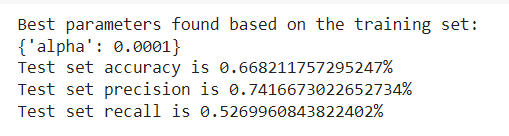

[[58699 13548]
 [34911 38896]]


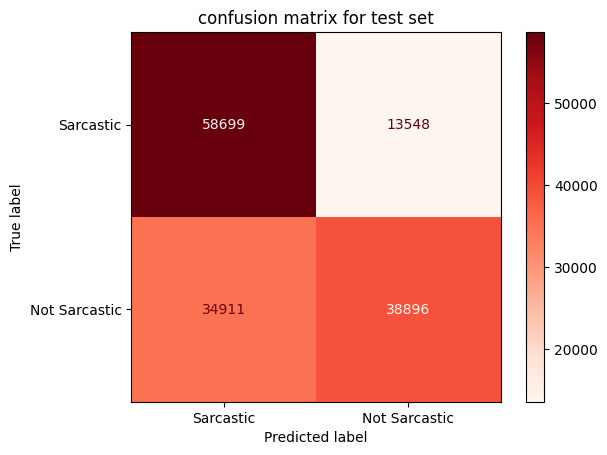

In [ ]:
c_matrix = confusion_matrix(y_test, y_pred)

print(c_matrix)
disp = ConfusionMatrixDisplay(confusion_matrix = c_matrix,display_labels=['Sarcastic','Not Sarcastic'])
disp.plot(cmap = "Reds")
plt.title("confusion matrix for test set")
plt.show()

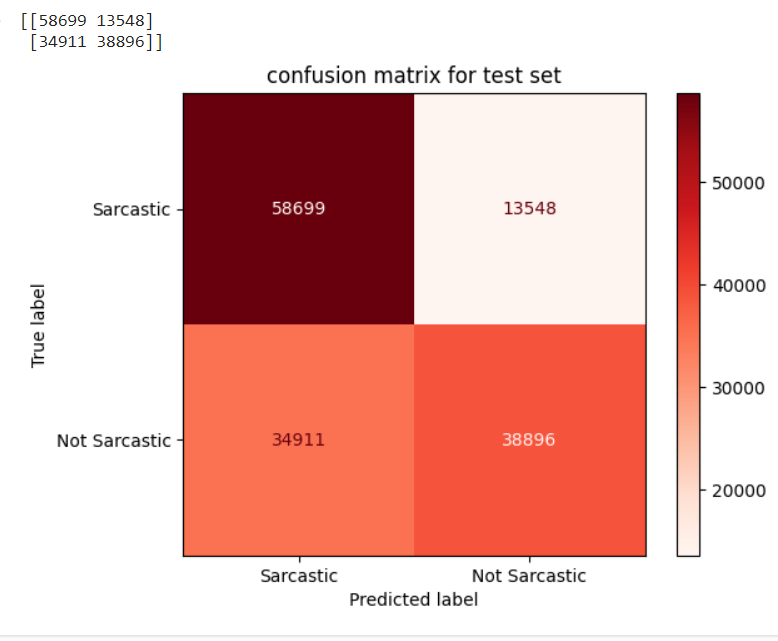

Now we shall use the baseline model of logistic regression where we shall tune the hyperparamter of alpha(regularisation) & type of penalty L1 or L2 to be used.

L1 promotes sparcity by bringing the feature coefficents to 0, thereby minimising overfitting which is an issue considering out high dimensional dataset

In [ ]:
clf= SGDClassifier(loss='log_loss', penalty='l2', alpha=0.0001,fit_intercept=True)
# use log for loss means logistic regression

# Define the parameter grid to search
param_grid = {
   'alpha': [0.0001, 0.001, 0.01],
    'penalty': ['l2', 'l1'],
}

# Define custom cross-validation splitter with 68% training and 17% validation of the total dataset

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=custom_cv)
grid_search.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters found based on the training set:")
print(grid_search.best_params_)

# Evaluate the model on the test set
best_log = grid_search.best_estimator_
y_pred = best_log.predict(X_test)

print("Test set accuracy is " + str(accuracy_score(y_test, y_pred))  + "%")
print("Test set precision is " + str(precision_score(y_test, y_pred))  + "%")
print("Test set recall is " + str(recall_score(y_test, y_pred))  + "%")

Best parameters found based on the training set:
{'alpha': 0.0001, 'penalty': 'l2'}
Test set accuracy is 0.6757774521752229%
Test set precision is 0.7065511048645272%
Test set recall is 0.6130041865947674%


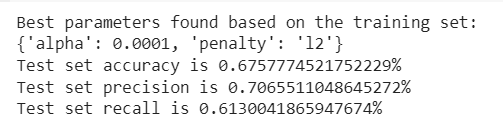

[[53456 18791]
 [28563 45244]]


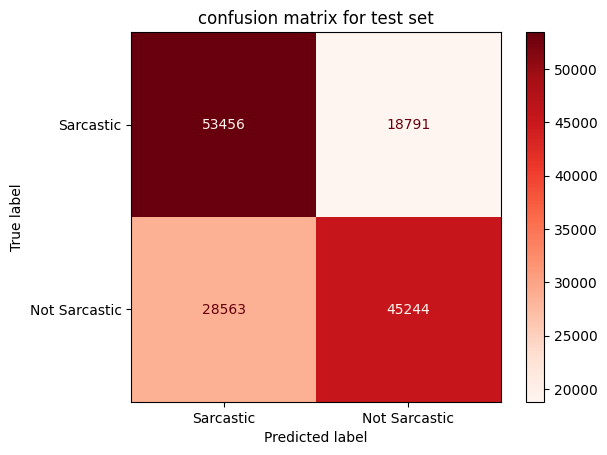

In [ ]:
c_matrix = confusion_matrix(y_test, y_pred)

print(c_matrix)
disp = ConfusionMatrixDisplay(confusion_matrix = c_matrix,display_labels=['Sarcastic','Not Sarcastic'])
disp.plot(cmap = "Reds")
plt.title("confusion matrix for test set")
plt.show()

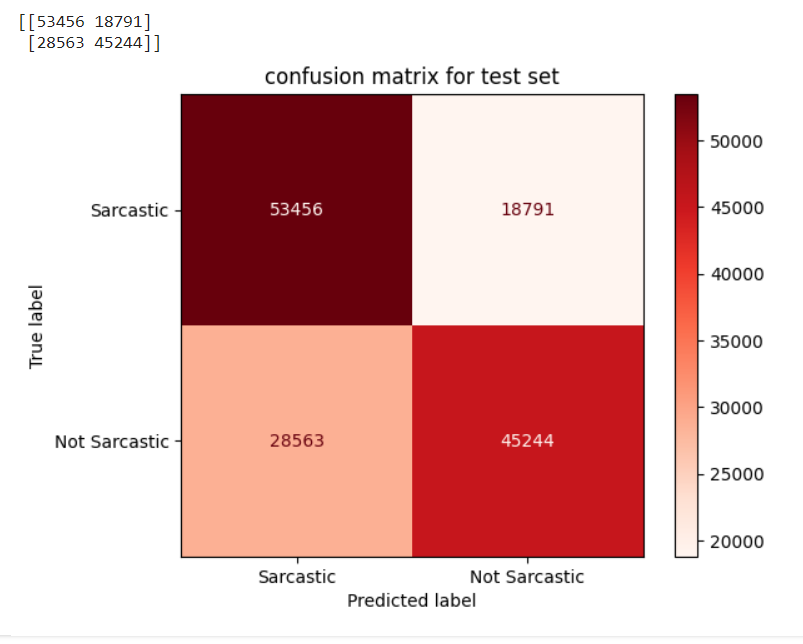

Naive Bayes is not used below for word2Vec due to the fact that some word embeddings may contain negative values, which makes it difficult for naive bayes to process it & hence we shall not consider it in our final results

In [ ]:
# use Naive Bayes
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6618298394611214


### 3.1.2 Dimensionality reduction of (TF-IDF) with extra features

From earlier analysis, we know that there are 83,820 unique sarcastic words & 95,450 unique not sarcastic words and 132,566 unqiue words in total. Hence, the feature space from Vectorising is likely to have a very high dimension.

So let's explore if reducing dimensionality will reduce overfitting and it will also allow us to include the extra features into the model to hopefully see if they are relevant in improving model performance

Imports & reading of dataset (done here so just have to run the code here to make it work)

In [ ]:
import joblib
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.decomposition import PCA # pca cannot be used for sparse matrix like TF-IDF
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from sklearn.linear_model import SGDClassifier
from sklearn import metrics

from sklearn.feature_extraction.text import TfidfVectorizer
# downloads needed so that this can be run independantly from the above
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

import regex as re


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# code to use the loaded tf-idf matrix for later use - MAKE SURE TO run tf_idf code on top
# IF IT IS THE FIRST TIME RUNNING THIS
tf_idf_matrix = joblib.load('tfidf_matrix.pkl')

In [ ]:
import pandas as pd
!gdown "https://drive.google.com/uc?id=1LIR4Ks1J_e6ks75_g1Pzkz2n5Xnbjorq"

# Loading the dataset
pca_df = pd.read_csv('cs3244_sarcasm_feature_df1.csv')

Downloading...
From: https://drive.google.com/uc?id=1LIR4Ks1J_e6ks75_g1Pzkz2n5Xnbjorq
To: /content/cs3244_sarcasm_feature_df1.csv
100% 99.5M/99.5M [00:00<00:00, 147MB/s]


**Approach**: We wanted to use PCA initially but PCA does not work on spase matrices. We tried to do sparse_matrice.toarray(), however as the dimension of our matrix was too large, the collab session crashed due to lack of available RAM to process a sparse matrix of 108693(words) * 973,690 (document).

We had even reduced the vocabulary size to 10,000 for the tf-idf but to not avail.

Hence, we opted to use TruncatedSVD that is used for sparse matrices instead.
1) We changed the max_vocab to 10,000 and peformed TruncatedSVD with 10,000 components (we did not remove any features) and then used 100 components.
2) The peformance of the second method lead to better scores than that of the first suggesting that dimensionality reduction helps with overfitting despite the longer training time.

We also **DID NOT USE GRID SEARCH FOR THIS due to the high computational time & because we could not use the full set of data anyways** but we used the same model parameters found from gridsearch above

**Conclusion**: Dimensionality redution helps with improved performance however we are unable to see if it is better than baseline model as we are unable to use all the words in the original corpus.


We then decided to see if the extra features processed would impove the model performance or not

In [ ]:
# apply svd directly (no need to standardise as tf-idf is already from 0 to 1) on the tf-idf matrix
X_train, X_test, y_train, y_test = train_test_split(tf_idf_matrix, pca_df['label'], test_size=0.15, random_state=42)
X_train2, X_test2, y_train2, y_test2 = train_test_split(pca_df[['end_with_special_punctuation','sarcasm_prop','ln_comment_parent_ratio','subjectivity_category']], pca_df['label'], test_size=0.15, random_state=42)

SVM with truncated SVD & (SVM with truncated SVD & extra features)

In [ ]:
clf= SGDClassifier(loss='hinge', penalty='l2', alpha=0.0001, l1_ratio=0.15, fit_intercept=True)

# use SVM
svd1 = TruncatedSVD(n_components = 100)
X_train_100 = svd1.fit_transform(X_train)
X_test_100 = svd1.transform(X_test)

# use hinge for loss means soft margin linear SVM
clf.fit(X_train_100, y_train)
y_pred = clf.predict(X_test_100)

print("Test set accuracy for SVM with svd ONLY for 100 components is " + str(accuracy_score(y_test, y_pred))  + "%")
print("Test set precision for SVM with svd ONLY for 100 components is " + str(precision_score(y_test, y_pred))  + "%")
print("Test set recall for SVM with svd ONLY for 100 components is " + str(recall_score(y_test, y_pred))  + "%")

# use all components - default is 10k matching total words set
svd2 = TruncatedSVD()
X_train_ = svd2.fit_transform(X_train)
X_test_ = svd2.transform(X_test)

clf= SGDClassifier(loss='hinge', penalty='l2', alpha=0.0001, l1_ratio=0.15, fit_intercept=True)
# use hinge for loss means soft margin linear SVM
clf.fit(X_train_, y_train)
y_pred = clf.predict(X_test_)

print("Test set accuracy for SVM with svd ONLY for ALL components is " + str(accuracy_score(y_test, y_pred))  + "%")
print("Test set precision for SVM with svd ONLY for ALL components is " + str(precision_score(y_test, y_pred))  + "%")
print("Test set recall for SVM with svd ONLY for ALL components is " + str(recall_score(y_test, y_pred))  + "%")

Test set accuracy for SVM with svd ONLY for 100 components is 0.6032357895025128%
Test set precision for SVM with svd ONLY for 100 components is 0.6934454825682812%
Test set recall for SVM with svd ONLY for 100 components is 0.3914216347450769%
Test set accuracy for SVM with svd ONLY for ALL components is 0.5161721007298671%
Test set precision for SVM with svd ONLY for ALL components is 0.529414752238907%
Test set recall for SVM with svd ONLY for ALL components is 0.42179660102508765%


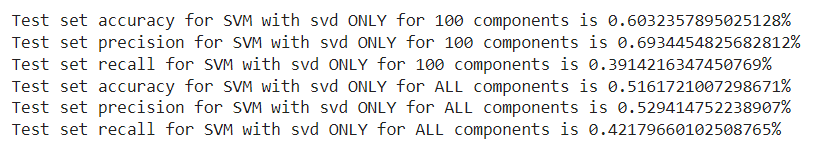

From below, it seems that it is difficult for truncated SVD to capture the large number of features into a smaller dimension.
Each component explains a very small amount of total variation leading to a poor performance, this could be becuase we did not capture all of the words and was only limited to 10k.

In [ ]:
# print out variance of each principal components so that we know which ones to keep
# this one is for 100 components
print(svd1.explained_variance_ratio_[:30])

[0.00414002 0.00538581 0.00425493 0.00393581 0.00334513 0.00308932
 0.00303705 0.00290898 0.00267784 0.00247698 0.00237027 0.00234074
 0.00231694 0.00229435 0.00223086 0.00219357 0.00215772 0.00214833
 0.00207659 0.00202543 0.00199674 0.00196915 0.00194129 0.00193223
 0.00187206 0.00186887 0.00183506 0.00179905 0.00176494 0.00173983]


**Adding new features generated earlier**

We first take the numpyd array from SVD and concat it with the new features by making it to a numpy array and then check if the features have been added. We then explore any improvements in performance with this new features.

In [ ]:
# extra_df = pd.DataFrame(X_train_100, columns=list(range(100)))
# extra_df.head(2)
# extra_test_df = pd.DataFrame(X_test_100, columns=list(range(100)))
# extra_test_df.head(2)

# training is a lot worse & slower this way
# df_train_concatenated = pd.concat([extra_df, X_train2.reset_index()], axis=1, ignore_index=True).values
# df_test_concatenated = pd.concat([extra_test_df, X_test2.reset_index()], axis=1, ignore_index=True).values

0         1         2         3         4         5         6   \
0  0.035687 -0.011923 -0.015943 -0.007137 -0.008080 -0.010936 -0.007218   
1  0.143209 -0.057158  0.218868  0.033223  0.005477  0.014892  0.029222   

         7         8         9   ...        90        91        92        93  \
0 -0.000477 -0.003443 -0.001641  ... -0.003113 -0.006932  0.012771 -0.002265   
1 -0.005582 -0.006853  0.002612  ... -0.012353  0.041888 -0.021715 -0.042435   

         94       95        96        97        98        99  
0 -0.009737 -0.00517  0.001979 -0.000514 -0.005081 -0.005962  
1 -0.048972 -0.08976  0.085746  0.078282  0.023348  0.048745  

[2 rows x 100 columns]

In [ ]:
df_train_concatenated = np.concatenate((X_train_100, X_train2.values), axis=1)
df_test_concatenated = np.concatenate((X_test_100, X_test2.values), axis=1)

NameError: name 'X_train_100' is not defined

In [ ]:
# use SVM
clf= SGDClassifier(loss='hinge', penalty='l2', alpha=0.0001, l1_ratio=0.15, fit_intercept=True)
# use hinge for loss means soft margin linear SVM
clf.fit(df_train_concatenated, y_train)
y_pred = clf.predict(df_test_concatenated)

print("Test set accuracy for SVM with svd & NEW FEATURES for 100 components is " + str(accuracy_score(y_test, y_pred))  + "%")
print("Test set precision for SVM with svd & NEW FEATURES for 100 components is " + str(precision_score(y_test, y_pred))  + "%")
print("Test set recall for SVM with svd & NEW FEATURES for 100 components is " + str(recall_score(y_test, y_pred))  + "%")

Test set accuracy for SVM with svd & NEW FEATURES for 100 components is 0.6247881769351642%
Test set precision for SVM with svd & NEW FEATURES for 100 components is 0.6669360304467963%
Test set recall for SVM with svd & NEW FEATURES for 100 components is 0.5185237728507154%


Lets see how important the new added features are. Note: the newly added features are from cols 100 - 104. As we can see feature 101 ('sarcasm_prop') has a lot of impact on the model followed by feature 100 ('end_with_special_punctuation'). The other features are not as important to the model's performance.

**Conclusion:** Furthermore, from the above results, we can tell that adding the new features has imporved the accuracy slightly and improved the recall by a significant margin. Hence, the added features are useful in aiding the model to better identify sarcasm

In [ ]:
# Get feature importances (coefficients)
coef_importance = clf.coef_[0]

# Map coefficients to feature names
feature_names = list(range(105))
importance_dict = dict(zip(feature_names, coef_importance))

# Sort features by importance
sorted_features = sorted(importance_dict.items(), key=lambda x: np.abs(x[1]), reverse=True)

# Print feature importance
print("Feature importance:")
for feature, importance in sorted_features:
    print(f"{feature}: {importance}")

Feature importance:
0: 5.296552768895067
101: 4.397600410947492
50: 3.5738733024045564
68: 3.418374922719817
36: 3.079487362981505
2: -2.8198858383612757
69: -2.7317951514583165
89: -2.709524598177025
5: 2.442895054031368
65: 2.348523901328394
9: -2.3465463925772125
24: 2.310553999863496
15: 2.2573938856942326
7: -2.1755533282043715
4: 2.1284239631644426
3: -2.000119844395066
31: 1.9760724058216446
40: 1.9479385107825467
45: -1.9242057654288018
44: 1.9137930610220408
84: -1.8342474905370143
96: 1.7873225467836862
85: -1.6919380174195753
56: -1.6869649136949008
20: 1.6098227948688477
88: 1.6013137588824862
90: 1.5851162413553141
37: -1.5683036500135967
52: 1.5202975475477105
94: -1.5106116883016996
64: 1.4851445697063284
41: 1.4804205497244693
54: -1.4527929142564022
22: -1.3912353790430276
26: 1.3741734369460914
11: -1.3072110176016902
55: 1.2712103097538987
42: -1.268815320721619
67: -1.231383414752288
1: 1.2028165975845098
48: -1.150520037646671
17: 1.1370624419228315
30: -1.09668830

**Lets check if this can be replicated with Logistic Regression as well**

We try with just the Truncated SVD first

In [ ]:
clf= SGDClassifier(loss='log_loss', penalty='l2', alpha=0.0001, l1_ratio=0.15, fit_intercept=True)

# use SVM
svd1 = TruncatedSVD(n_components = 100)
X_train_100 = svd1.fit_transform(X_train)
X_test_100 = svd1.transform(X_test)

# use hinge for loss means soft margin linear SVM
clf.fit(X_train_100, y_train)
y_pred = clf.predict(X_test_100)

print("Test set accuracy for Logistic Regression with SVD ONLY for 100 components is " + str(accuracy_score(y_test, y_pred))  + "%")
print("Test set precision for Logistic Regression with SVD ONLY for 100 components is " + str(precision_score(y_test, y_pred))  + "%")
print("Test set recall for Logistic Regression with SVD ONLY for 100 components is " + str(recall_score(y_test, y_pred))  + "%")

# use all components - default is 10k matching total words set
svd2 = TruncatedSVD()
X_train_ = svd2.fit_transform(X_train)
X_test_ = svd2.transform(X_test)

clf= SGDClassifier(loss='log_loss', penalty='l2', alpha=0.0001, l1_ratio=0.15, fit_intercept=True)
# use hinge for loss means soft margin linear SVM
clf.fit(X_train_, y_train)
y_pred = clf.predict(X_test_)

print("Test set accuracy for Logistic Regression with SVD ONLY for ALL components is " + str(accuracy_score(y_test, y_pred))  + "%")
print("Test set precision for Logistic Regression with SVD ONLY for ALL components is " + str(precision_score(y_test, y_pred))  + "%")
print("Test set recall for Logistic Regression with SVD ONLY for ALL components is " + str(recall_score(y_test, y_pred))  + "%")

Test set accuracy for Logistic Regression with SVD ONLY for 100 components is 0.6176071863831186%
Test set precision for Logistic Regression with SVD ONLY for 100 components is 0.6634203002144389%
Test set recall for Logistic Regression with SVD ONLY for 100 components is 0.5007418397626113%
Test set accuracy for Logistic Regression with SVD ONLY for ALL components is 0.5172128116997823%
Test set precision for Logistic Regression with SVD ONLY for ALL components is 0.5278592825869882%
Test set recall for Logistic Regression with SVD ONLY for ALL components is 0.4634610196924737%


With reduced dimension & new features

In [ ]:
df_train_concatenated = np.concatenate((X_train_100, X_train2.values), axis=1)
df_test_concatenated = np.concatenate((X_test_100, X_test2.values), axis=1)

In [ ]:
# use SVM
clf= SGDClassifier(loss='log_loss', penalty='l2', alpha=0.0001, l1_ratio=0.15, fit_intercept=True)
# use hinge for loss means soft margin linear SVM
clf.fit(df_train_concatenated, y_train)
y_pred = clf.predict(df_test_concatenated)

print("Test set accuracy for Logistic Regression with SVD  & NEW FEATURES for 100 components is " + str(accuracy_score(y_test, y_pred))  + "%")
print("Test set precision for Logistic Regression with SVD svd & NEW FEATURES for 100 components is " + str(precision_score(y_test, y_pred))  + "%")
print("Test set recall for Logistic Regression with SVD & NEW FEATURES for 100 components is " + str(recall_score(y_test, y_pred))  + "%")

Test set accuracy for Logistic Regression with SVD  & NEW FEATURES for 100 components is 0.6328823585797034%
Test set precision for Logistic Regression with SVD svd & NEW FEATURES for 100 components is 0.6457519496569456%
Test set recall for Logistic Regression with SVD & NEW FEATURES for 100 components is 0.6131507957917454%


### 3.1.3 Word2Vec

The downside of TF-IDF Vectors is that they do not consider the context (words surrounding the center word) causing certain nuances to be lost.

Hence, we try to explore using Word2Vec emebeddings. Word2Vec is a neural network that learns continuous word embeddings, capturing the semantic relationships between words like synonyms, antonyms, and analogies. Words with similar meanings have similar word embeddings, we hope that * consideration of the context this way leads to a better result even though the context size is small,2 *


We use the same random_state to ensure that the training & test sets are the same comments & the SGD classifiers with same parameters as above to ensure that changes are strictly due to using different WORD EMBEDDINGS.

In [ ]:
from nltk.tokenize import word_tokenize
import gensim
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, accuracy_score
from sklearn.metrics import accuracy_score,confusion_matrix,ConfusionMatrixDisplay


X_train,X_test,y_train,y_test=train_test_split(x,y,random_state=1,test_size=0.15,shuffle=True)

In [ ]:
train_sentences = X_train.apply(word_tokenize).tolist()
test_sentences = X_test.apply(word_tokenize).tolist()

In [ ]:
# we make our embedding dimension of size 100
# with a window of 2 to consider 2 words before and after the center word
model = Word2Vec(sentences = train_sentences,
                 vector_size = 100,
                 window = 2,
                 min_count = 1,
                 workers = 2)

# save the model so that we do not have to keep training it repeatedly
model.save("word2vec.bin")

In [ ]:
# # directly use the trained model from the second time onwards
# # SOME ISSUES WITH BINARY CONVERSION
# url = "https://drive.google.com/uc?id=1ppAiXLwjAQtN1ELEk0qn65GPXs2v7Ug0"
# output = 'model_vector.txt'
# gdown.download(url, output, quiet=False)
# wv = KeyedVectors.load_word2vec_format('model_vector.txt', binary=False)

In [ ]:
wv = model.wv
print(wv)
# Total number of the words
print(len(wv))
# Print the size of the word2vec vector for one word - we fixed it to 100
print("Length of the vector generated for a word")
print(len(wv['NC']))

Using the model on each word of the comment, we get the word embedding vectors for those words. However, our comment is not just a word but a sentence so we need to get the sentence vector which will be the average
of its word vectors. This vector is then added to the list of sentence vectors.

Each sentence vector represents 1 comment, we will use these vectors to identify any potential patterns between the 2 different comments (Sarcastic or not)

In [ ]:
def get_sentenceVectors(sentences):
  vectors = []
  for sentence in sentences:
       #This line creates a list of word vectors for each word in the sentence that is in the Word2Vec model's vocabulary.
       sentence_vectors = [wv[word] for word in sentence if word in wv]

       if len(sentence_vectors) == 0:
           # If the sentence doesn't have any words that are in
           # the Word2Vec model's vocabulary, the sentence is represented by a vector of 100 zeros.
           vectors.append([0] * 100)

       else:
           vectors.append(np.mean(sentence_vectors, axis=0))
  return vectors

In [ ]:
# split into train & test data
train_vectors = get_sentenceVectors(train_sentences)
test_vectors = get_sentenceVectors(test_sentences)
print("vector of the first training sentence:", train_vectors[0])

Now, we shall use the Embedded Vectors and run it in the same machine learning models earlier and compare the differences in performance

The accuracy of the model trained on custom trained Word2Vec embedded model is worse than the model trained on tf-idf model in terms of recall but has better precision. This tells me that it's does not misclassify its correct predictions but misses out on identifying some sarcastic sentences. It edges more on the safer side.

One possible reason could be that the feature space is must smaller in Word2Vec 300k VS ~1million used in TF-IDF. However, let us also explore using the google's pre-trained model to explore if there will be a performance improvement.

In [ ]:
# use SVM
clf= SGDClassifier(loss='hinge', penalty='l2', alpha=0.0001, l1_ratio=0.15, fit_intercept=True)
# use hinge for loss means soft margin linear SVM

# Define the parameter grid to search
param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 1]
}

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=custom_cv)
grid_search.fit(train_vectors, y_train)

# Print the best parameters found
print("Best parameters found based on the training set:")
print(grid_search.best_params_)

# Evaluate the model on the test set
best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(test_vectors)

print("Test set accuracy is " + str(accuracy_score(y_test, y_pred))  + "%")
print("Test set precision is " + str(precision_score(y_test, y_pred))  + "%")
print("Test set recall is " + str(recall_score(y_test, y_pred))  + "%")

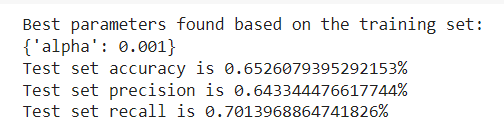

In [ ]:
c_matrix = confusion_matrix(y_test, y_pred)

print(c_matrix)
disp = ConfusionMatrixDisplay(confusion_matrix = c_matrix,display_labels=['Sarcastic','Not Sarcastic'])
disp.plot(cmap = "Blues")
plt.title("confusion matrix for test set")
plt.show()

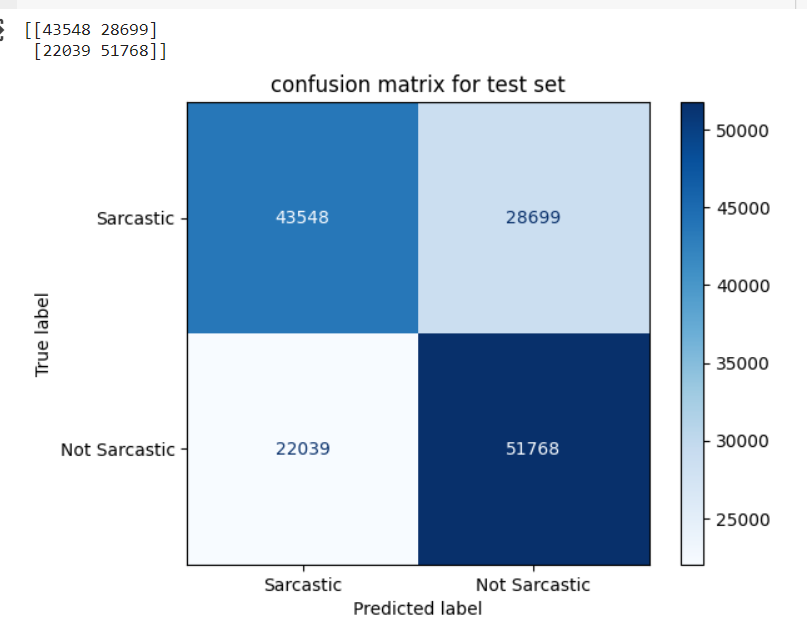

In [ ]:
clf= SGDClassifier(loss='log_loss', penalty='l2', alpha=0.0001,fit_intercept=True)
# use log for loss means logistic regression

# Define the parameter grid to search
param_grid = {
   'alpha': [0.0001, 0.001, 0.01],
    'penalty': ['l2', 'l1'],
}

# Define custom cross-validation splitter with 68% training and 17% validation of the total dataset

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=custom_cv)
grid_search.fit(train_vectors, y_train)

# Print the best parameters found
print("Best parameters found based on the training set:")
print(grid_search.best_params_)

# Evaluate the model on the test set
best_log = grid_search.best_estimator_
y_pred = best_log.predict(test_vectors)

print("Test set accuracy is " + str(accuracy_score(y_test, y_pred))  + "%")
print("Test set precision is " + str(precision_score(y_test, y_pred))  + "%")
print("Test set recall is " + str(recall_score(y_test, y_pred))  + "%")

Best parameters found based on the training set:
{'alpha': 0.001, 'penalty': 'l2'}
Test set accuracy is 0.6521355115231353%
Test set precision is 0.6476441134933881%
Test set recall is 0.6834717574213828%


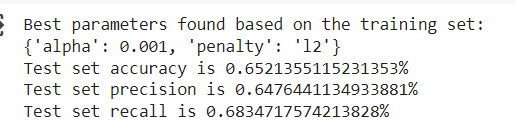

[[44802 27445]
 [23362 50445]]


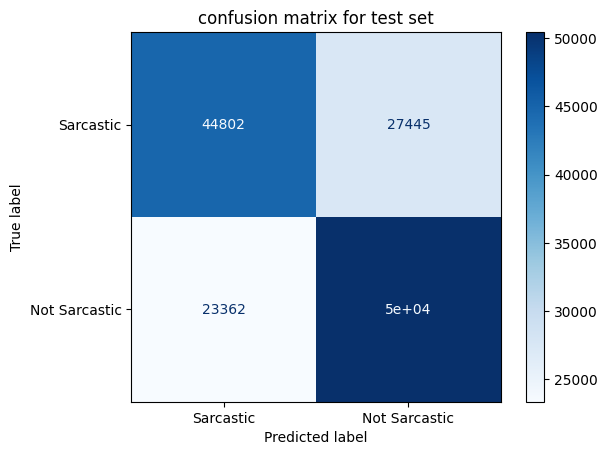

In [ ]:
c_matrix = confusion_matrix(y_test, y_pred)

print(c_matrix)
disp = ConfusionMatrixDisplay(confusion_matrix = c_matrix,display_labels=['Sarcastic','Not Sarcastic'])
disp.plot(cmap = "Blues")
plt.title("confusion matrix for test set")
plt.show()

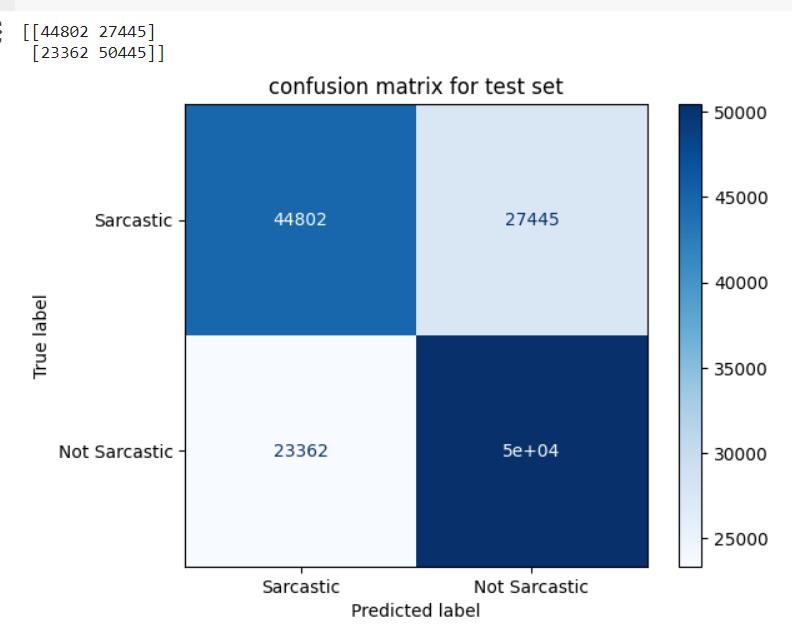

### 3.1.4 Pre-Trained Word2Vec

We also tried using pre-trained Word2Vec embeddings because they have been trained on vast amounts of text data and can capture general linguistic patterns. We hope that this would help to better capture nuances and identify sarcastic comments more effectively.

This can also save time and computational resources compared to training Word2Vec embeddings from scratch.

Importing the pre-trained word2Vec

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [ ]:
import gdown
file_id1 = '1nTrdlN6KAQZU6YzrJipkXa3J7JV6fQ_I'
url = f'https://drive.google.com/uc?id={file_id1}'
output = 'GoogleNews-vectors-negative300.bin'
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1nTrdlN6KAQZU6YzrJipkXa3J7JV6fQ_I
From (redirected): https://drive.google.com/uc?id=1nTrdlN6KAQZU6YzrJipkXa3J7JV6fQ_I&confirm=t&uuid=20165485-c0e1-4125-a63c-42ff21c2f3ba
To: /content/GoogleNews-vectors-negative300.bin
100%|██████████| 3.64G/3.64G [00:42<00:00, 86.5MB/s]


'GoogleNews-vectors-negative300.bin'

In [ ]:
# uses a vector size of 300
model2 = KeyedVectors.load_word2vec_format(output, binary=True)

In [ ]:
len(model2['NA'])
# to get size of word embedding

300

Repeating the same code as above

In [ ]:
import numpy as np
def get_sentenceVectors2(sentences):
  vectors = []
  for sentence in sentences:
       #This line creates a list of word vectors for each word in the sentence that is in the Word2Vec model's vocabulary.
       sentence_vectors = [model2[word] for word in sentence if word in model2]

       if len(sentence_vectors) == 0:
           # If the sentence doesn't have any words that are in
           # the Word2Vec model's vocabulary, the sentence is represented by a vector of 100 zeros.
           vectors.append([0] * 300)

       else:
           vectors.append(np.mean(sentence_vectors, axis=0))
  return vectors

In [ ]:
train_sentences = X_train.apply(word_tokenize).tolist()
test_sentences = X_test.apply(word_tokenize).tolist()

In [ ]:
# split into train & test data
train_vectors2 = get_sentenceVectors2(train_sentences)
test_vectors2 = get_sentenceVectors2(test_sentences)
print("vector of the first training sentence:", train_vectors2[0])

vector of the first training sentence: [-0.01127116  0.06266276  0.06827799 -0.02091471 -0.20833333  0.00227865
 -0.00557454 -0.03177897  0.08369955  0.10555013  0.04052734 -0.22957356
 -0.02807617  0.13020833  0.02229818  0.03645833 -0.06835938  0.08829752
 -0.14111328 -0.01676432 -0.13704427 -0.04361979 -0.02919515 -0.03564453
  0.0626297   0.02701823 -0.18855794  0.09635416  0.00317383 -0.16267903
 -0.03141276 -0.15527344 -0.0472819  -0.10058594  0.03881836 -0.02669271
 -0.12068685  0.03267415  0.11930338  0.11735026  0.04085286  0.03149414
  0.12569173 -0.03076172  0.07210287 -0.07495117 -0.11184692  0.01318359
 -0.03515625  0.02132162 -0.13515218  0.0859375  -0.07519531 -0.13053386
  0.06835938  0.06461588  0.06896973 -0.049764    0.13130696 -0.05485026
  0.02503967  0.07025146 -0.14697266  0.01245117 -0.12841797 -0.04313151
  0.00447591 -0.02124023 -0.14754231 -0.1406657   0.11405436  0.03035482
  0.17529297 -0.1138916  -0.07145182 -0.04361979  0.08235677 -0.04044596
  0.03833008

In [ ]:
# use SVM
clf= SGDClassifier(loss='hinge', penalty='l2', alpha=0.0001, l1_ratio=0.15, fit_intercept=True)
# use hinge for loss means soft margin linear SVM

# Define the parameter grid to search
param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 1]
}

# Define custom cross-validation splitter with 68% training and 17% validation of the total dataset
custom_cv = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=custom_cv)
grid_search.fit(train_vectors2, y_train)

# Print the best parameters found
print("Best parameters found based on the training set:")
print(grid_search.best_params_)

# Evaluate the model on the test set
best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(test_vectors2)

print("Test set accuracy is " + str(accuracy_score(y_test, y_pred))  + "%")
print("Test set precision is " + str(precision_score(y_test, y_pred))  + "%")
print("Test set recall is " + str(recall_score(y_test, y_pred))  + "%")

Best parameters found based on the training set:
{'alpha': 0.0001}
Test set accuracy is 0.6185588891779753%
Test set precision is 0.6054078613201612%
Test set recall is 0.7040931076998117%


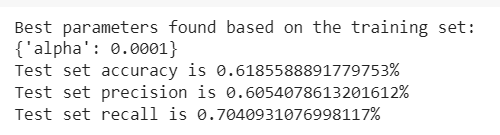

[[38376 33871]
 [21840 51967]]


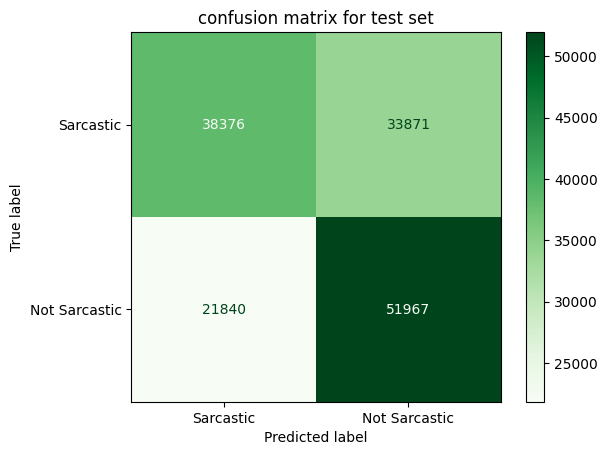

In [ ]:
from sklearn.metrics import accuracy_score,confusion_matrix,ConfusionMatrixDisplay
c_matrix = confusion_matrix(y_test, y_pred)

print(c_matrix)
disp = ConfusionMatrixDisplay(confusion_matrix = c_matrix,display_labels=['Sarcastic','Not Sarcastic'])
disp.plot(cmap = "Greens")
plt.title("confusion matrix for test set")
plt.show()

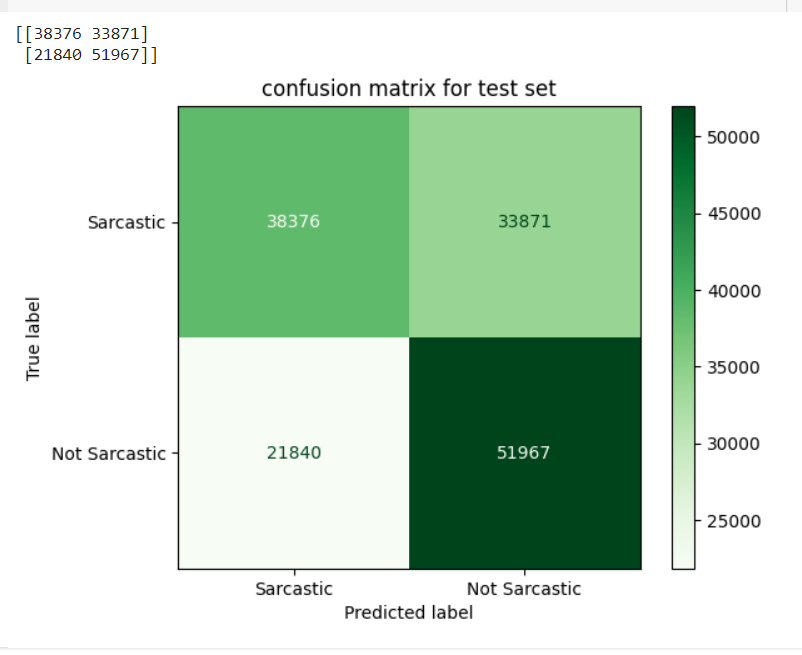

In [ ]:
clf= SGDClassifier(loss='log_loss', penalty='l2', alpha=0.0001,fit_intercept=True)
# use log for loss means logistic regression

# Define the parameter grid to search
param_grid = {
   'alpha': [0.0001, 0.001, 0.01],
    'penalty': ['l2', 'l1'],
}

# Define custom cross-validation splitter with 68% training and 17% validation of the total dataset

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=custom_cv)
grid_search.fit(train_vectors2, y_train)

# Print the best parameters found
print("Best parameters found based on the training set:")
print(grid_search.best_params_)

# Evaluate the model on the test set
best_log = grid_search.best_estimator_
y_pred = best_log.predict(test_vectors2)

print("Test set accuracy is " + str(accuracy_score(y_test, y_pred))  + "%")
print("Test set precision is " + str(precision_score(y_test, y_pred))  + "%")
print("Test set recall is " + str(recall_score(y_test, y_pred))  + "%")

Best parameters found based on the training set:
{'alpha': 0.0001, 'penalty': 'l2'}
Test set accuracy is 0.6218795787859285%
Test set precision is 0.6535746755930242%
Test set recall is 0.5356944463262292%


[[51290 20957]
 [34269 39538]]


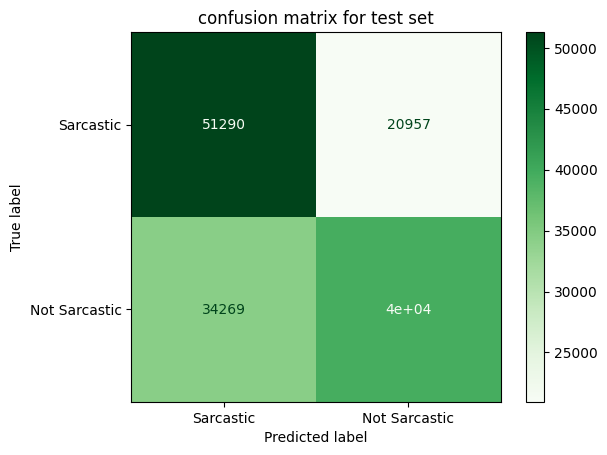

In [ ]:
from sklearn.metrics import accuracy_score,confusion_matrix,ConfusionMatrixDisplay
c_matrix = confusion_matrix(y_test, y_pred)

print(c_matrix)
disp = ConfusionMatrixDisplay(confusion_matrix = c_matrix,display_labels=['Sarcastic','Not Sarcastic'])
disp.plot(cmap = "Greens")
plt.title("confusion matrix for test set")
plt.show()

**Insights Gathered:**
Using the pretrained model performs suprisingly worse compared to the custom model.
However, with TF-IDF the results are mostly similar for accuracy & precision but Word2Vec has better recall
This means that what embedding we use is dependant on what we wish to prioritise (Eg: Very important to not misclassify sarcastic comments or not)

This could be due to Word2Vec being unable to handle out-of-vocabulary (OOV) words well, and cannot capture different meanings of a word when they are used in different contexts (polysemy), which is something that is important when it comes to identifying sarcasm. This could be a possible reason as to why it does not perform much better than TF-IDF as different words have different meanings in various contexts

Hence, we shall explore other machine learning models that can potentially capture these intricacies.

# 4 Utilise More Complex Deep Learning Frameworks

Motivation:
1. Deep learning frameworks are able to capture and more complex data patterns leading to better accuracy.

Downside:
1. Due to the lack of computational resouces, it is difficult to perform hyperparameter tuning especially for BERT to peform many epochs especially since
compute time(GPU) - 1.5h & (CPU) - 56h.



## 4.1 Bidirectional Encoder Representations from Transformers (BERT) - IGNORE

Not complete, session crashed



In [ ]:
# Preparing the neccesary packages for the BERT implementation
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset


In [ ]:
# Loading the dataset
bert_df = pd.read_csv('/cs3244_sarcasm_feature_df1.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/cs3244_sarcasm_feature_df1.csv'

In [ ]:
# Tokenize the text
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
encoded_data = tokenizer.batch_encode_plus(
    bert_df.comment.values,
    add_special_tokens=True,
    return_attention_mask=True,
    padding=True,
    truncation=True,
    max_length=256,
    return_tensors='pt'
)

input_ids = encoded_data['input_ids']
attention_masks = encoded_data['attention_mask']
labels = torch.tensor(bert_df.label.values)

In [ ]:
# Split the dataset into training and validation sets
dataset = TensorDataset(input_ids, attention_masks, labels)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])


In [ ]:
# Create data loaders
batch_size = 16
train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=batch_size
)
validation_dataloader = DataLoader(
    val_dataset,
    sampler=SequentialSampler(val_dataset),
    batch_size=batch_size
)

In [ ]:
# Load the BERT model for classification
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=len(df.label.unique()),
    output_attentions=False,
    output_hidden_states=False
)

In [ ]:
# Move the model to the GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define the optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

# Define the training loop
epochs = 4

for epoch in tqdm(range(1, epochs+1)):
    model.train()
    loss_train_total = 0

    progress_bar = tqdm(train_dataloader, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:
        model.zero_grad()
        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        outputs = model(**inputs)
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        optimizer.step()
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})

    # Evaluation step
    model.eval()

    val_loss = 0
    predictions, true_vals = [], []

    for batch in validation_dataloader:
        batch = tuple(b.to(device) for b in batch)

        inputs = {
            'input_ids':      batch[0],
            'attention_mask': batch[1]
        }
        with torch.no_grad():
            outputs = model(**inputs)

        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        label_ids = batch[2].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

In [ ]:
# Calculate the accuracy
predictions = np.concatenate(predictions, axis=0)
true_vals = np.concatenate(true_vals, axis=0)
preds_flat = np.argmax(predictions, axis=1).flatten()
true_flat = true_vals.flatten()
accuracy = accuracy_score(true_flat, preds_flat)

# Generate the confusion matrix and classification report
conf_mat = confusion_matrix(true_flat, preds_flat)
class_rep = classification_report(true_flat, preds_flat)

print(f'Accuracy: {accuracy}')
print(conf_mat)
print(class_rep)

To be done when my system stops crashing

## 4.2 Bidirectional Encoder Representations from Transformers (BERT)

Compared to LSTM(using RNN) which can only consider context in one direction, left to right, BERT can consider contexts in both directions.

Hence, we would like to explore if BERT would perform better in capturing nuances or will it overfit.

In [ ]:
 pip install torch_optimizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 1.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manyli

In [ ]:
import os
import torch
from torch import nn
import torch_optimizer as optim
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score
import pandas as pd
from tqdm import tqdm
from torch.nn import functional as F

In [ ]:
import pandas as pd
!gdown "https://drive.google.com/uc?id=1LIR4Ks1J_e6ks75_g1Pzkz2n5Xnbjorq"

# Loading the dataset
BERT_df = pd.read_csv('cs3244_sarcasm_feature_df1.csv')

Downloading...
From: https://drive.google.com/uc?id=1LIR4Ks1J_e6ks75_g1Pzkz2n5Xnbjorq
To: /content/cs3244_sarcasm_feature_df1.csv
100% 99.5M/99.5M [00:00<00:00, 110MB/s]


Process Data

In [ ]:
# BERT_df = BERT_df[:100000]
BERT_df = BERT_df[['label','comment']]
BERT_df.head(2)

label                                            comment
0      0                                         NC and NH.
1      0  You do know west teams play against west teams...

In [ ]:
# change type from numpy array to a list for easier processing later
labels = [1 if labelss == 1 else 0 for labelss in BERT_df['label'].tolist()]

Custom Dataset is created as BERT's encoder takes in text embedding & an attention mask (to process text b-directionally). This is so that BERT knows which tokens are padding and will ignore them. Each sample also needs a label of sarcastic or not as well.

We use a **pre-trained BERT model,**the base version of BERT, consisting of 12 transformer layers, 768 neurons in each hidden layer, and 12 self-attention heads. We used uncased to convert all text to lowercase before tokenization.


In [ ]:
class TextClassificationDataset(Dataset):
  def __init__(self, texts, labels, tokenizer, max_length):
      self.texts = texts
      self.labels = labels
      self.tokenizer = tokenizer
      self.max_length = max_length
  def __len__(self):
      return len(self.texts)
  def __getitem__(self, idx):
      text = self.texts[idx]
      label = self.labels[idx]
      # returns a the value as pyTorch tensors
      encoding = self.tokenizer(text, return_tensors='pt', max_length=self.max_length, padding='max_length', truncation=True)
      return {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(), 'label': torch.tensor(label)}

Setting of parameters

In [ ]:
# Paramters to be used
bert_model_name = 'bert-base-uncased'
# representing sarcastic / not sarcastic
num_classes = 2
# maximum length of comments as identified by EDA earlier
max_length = 27
batch_size = 16
num_epochs = 1
learning_rate = 2e-5

Splitting of data into train,test & validation sets & creation of dataloader to pass to model

In [ ]:
# split into train & test set - 15%
train_texts, test_texts, train_labels, test_labels = train_test_split(BERT_df['comment'].tolist(), labels, test_size=0.15, random_state=42)
# split into train & validation set - 15%
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=0.15, random_state=42)

# use bert's tokenizer
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer, max_length)
val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer, max_length)
test_dataset = TextClassificationDataset(test_texts, test_labels, tokenizer, max_length)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# This tells us that our code is correct - padding represented by 0 & 1 otherwise in attention_mask
train_dataset.__getitem__(2)

{'input_ids': tensor([  101,  2748,  2138,  2008,  1005,  1055,  1996, 12398,  2597,  2005,
          2273,  1010,  2002,  2442,  2022, 10439, 17298,  5732,  1012,   102,
             0,     0,     0,     0,     0,     0,     0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
         0, 0, 0]),
 'label': tensor(1)}

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

**Defining the Model**
We have a pre-trained BERT model with 10% dropout to reduce overfitting. We have a output layer to reduce the number of dimensions to 2 (nunmber of classes).

Since, BERT models typically output a probability distribution over classes & there is not a class imbalance, we used cross-entropy loss for optimizing the model parameters.

In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        x = self.dropout(pooled_output)
        logits = self.fc(x)
        return logits

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERTClassifier(bert_model_name, num_classes).to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

**Defining Train & Evaluation Functions**

In [ ]:
def train(model, data_loader, optimizer, scheduler, device):
    model.train()
    for batch in tqdm(data_loader, desc="Training", leave=True):
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

In [ ]:
def evaluate(model, data_loader, device):
    # to turn off dropout & gradient calculation
    model.eval()
    predictions = []
    actual_labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())
    return accuracy_score(actual_labels, predictions), classification_report(actual_labels, predictions), precision_score(actual_labels, predictions),  recall_score(actual_labels, predictions)

**Optimisation Approach**
Due to being able to only run this on google colllab's GPU, we were unable to use any libraries for hyper paramter tuning and manually did it.

We changed trained 2 models on 2 different optimiser -> evaluated using the validation set -> used the better model of AdamW optimiser on the test set

In [ ]:
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
for epoch in range(num_epochs):
        # print(f"Epoch {epoch + 1}/{num_epochs}")
        train(model, train_dataloader, optimizer, scheduler, device)
        accuracy, report, precision, recall  = evaluate(model, val_dataloader, device)
        print(f"Train Validation Accuracy: {accuracy:.4f}")
        print(report)

Training:  25%|██▍       | 10921/43969 [18:15<53:58, 10.20it/s]

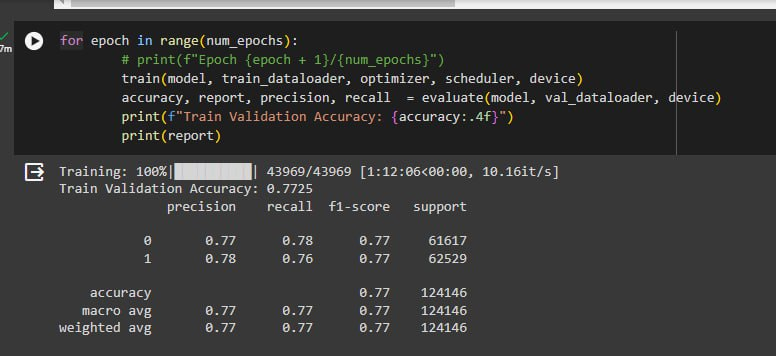

**Testing on the test dataset**

In [ ]:
for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        train(model, train_dataloader, optimizer, scheduler, device)
        accuracy, report, precision, recall  = evaluate(model, test_dataloader, device)
        print(f"Test Set Accuracy: {accuracy:.4f}")
        print(report)

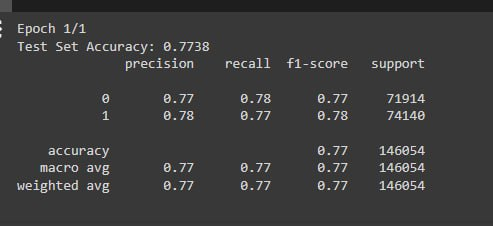

Hyper Parameter Tuning - using a different optimiser

In [ ]:
optimizer = optim.Adafactor(model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# training steps
for epoch in range(num_epochs):
        # print(f"Epoch {epoch + 1}/{num_epochs}")
        train(model, train_dataloader, optimizer, scheduler, device)
        accuracy, report, precision, recall  = evaluate(model, val_dataloader, device)
        print(f"Train Validation Accuracy: {accuracy:.4f}")

        accuracy, report, precision, recall  = evaluate(model, train_dataloader, device)
        print(f"Train Train Accuracy: {accuracy:.4f}")
        print(report)

Training: 100%|██████████| 43969/43969 [1:58:41<00:00,  6.17it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

Train Validation Accuracy: 0.5037


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Train Accuracy: 0.5058
              precision    recall  f1-score   support

           0       0.00      0.00      0.00    347675
           1       0.51      1.00      0.67    355815

    accuracy                           0.51    703490
   macro avg       0.25      0.50      0.34    703490
weighted avg       0.26      0.51      0.34    703490



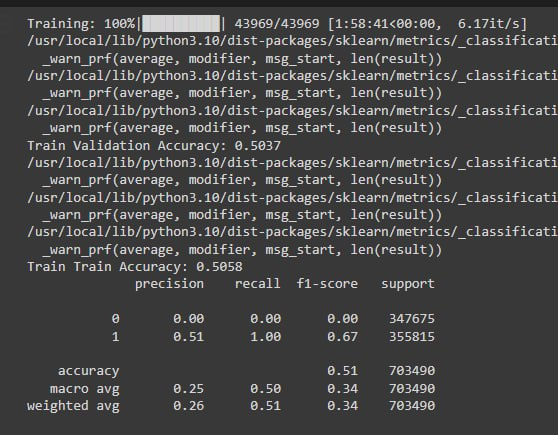

**Hence, we can conclude that AdamW optimiser is better than shall use that hyper paramter instead** to test on the test set

In [ ]:
for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        accuracy, report, precision, recall  = evaluate(model, test_dataloader, device)
        print(f"Test Set Accuracy: {accuracy:.4f}")
        print(report)

Epoch 1/1


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Set Accuracy: 0.5076
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     71914
           1       0.51      1.00      0.67     74140

    accuracy                           0.51    146054
   macro avg       0.25      0.50      0.34    146054
weighted avg       0.26      0.51      0.34    146054



### 4.2.1 Manual Hyper Parameter Tuning (Adding more hidden layers)

Adding more hidden layers however, seems to have caused the model to overfit, this could potentially be due to the model being too complex. Hence, we did not continue to tune this anymore

There is a slight possibility that more epoch is needed to run for the more complex model to reduce the loss however, due to computational limitations we decided not to pursue higher epochs

In [ ]:
class BERTClassifierr(nn.Module):
    def __init__(self, bert_model_name, num_classes):
        super(BERTClassifierr, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)

        # to reduce overfitting by turning off some neurons during training we use dropout
        # so that the model is less reliant on these neurons

        self.classifier = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, 300),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(300, 100),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 2)

        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = outputs['last_hidden_state'][:, 0, :]
        x = self.classifier(x)

        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = BERTClassifierr(bert_model_name, num_classes).to(device)

In [ ]:
optimizer = AdamW(model2.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * 1
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

for epoch in range(1):
        print(f"Epoch {epoch + 1}/{1}")
        train(model2, train_dataloader, optimizer, scheduler, device)

        accuracy, report, precision, recall = evaluate(model, train_dataloader, device)
        print(f"Validation Accuracy: {accuracy:.4f}")
        print(report)

accuracy, report, precision, recall = evaluate(model, val_dataloader, device)
print(f"Validation Accuracy: {accuracy:.4f}")
print(report)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/1


Training:   0%|          | 53/43969 [00:06<1:36:10,  7.61it/s]


KeyboardInterrupt: 

In [ ]:
for epoch in range(1):
        print(f"Epoch {epoch + 1}/{1}")
        accuracy, report, precision, recall  = evaluate(model2, test_dataloader, device)
        print(f"Test Set Accuracy: {accuracy:.4f}")
        print(report)

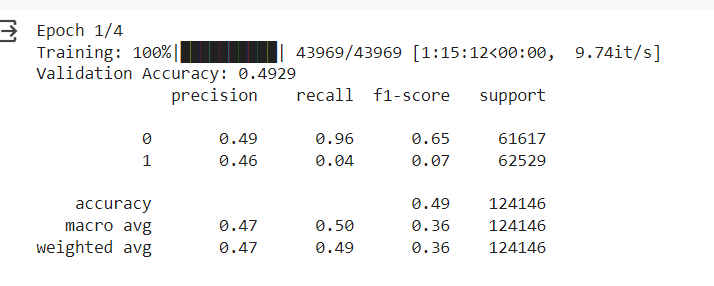

## 4.3 Model Implementation using CNN

In [ ]:
import pandas as pd
!gdown "https://drive.google.com/uc?id=1LIR4Ks1J_e6ks75_g1Pzkz2n5Xnbjorq"

# Read the CSV file
df = pd.read_csv('cs3244_sarcasm_feature_df1.csv')

# Display the first few rows of the DataFrame
print(df.head())
print("Dataframe Shape:", df.shape)

Downloading...
From: https://drive.google.com/uc?id=1LIR4Ks1J_e6ks75_g1Pzkz2n5Xnbjorq
To: /content/cs3244_sarcasm_feature_df1.csv
100% 99.5M/99.5M [00:00<00:00, 198MB/s]
   label                                            comment  score  \
0      0                                         NC and NH.      2   
1      0  You do know west teams play against west teams...     -4   
2      0  They were underdogs earlier today, but since G...      3   
3      0  This meme isn't funny none of the "new york ni...     -8   
4      0                    I could use one of those tools.      6   

   end_with_special_punctuation  sarcasm_prop  ln_comment_parent_ratio  \
0                             0      0.612595                -1.734601   
1                             1      0.530739                -0.656780   
2                             0      0.513177                 1.558145   
3                             0      0.378499                 0.875469   
4                             0      0.

In [ ]:
data = df[['label', 'comment']]

from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.15, random_state=42)


In [ ]:
print("First 5 sentences and their label",train_data.head())
print('\n Training input: {}\n'.format(train_data.shape))
print('\n Testing input: {}\n'.format(test_data.shape))

First 5 sentences and their label         label                                            comment
216572      1  Druid had to waste 4 slots to run double combo...
438041      1  But.. but I thought it was all about keeping l...
34930       0                                       Sounds good!
391982      0          What the hell is going on in this thread?
935221      1  I can't believe that bastard Jefferson played ...

 Training input: (827636, 2)


 Testing input: (146054, 2)



### 4.3.1 Word Preprocessing

In [ ]:
####################################
# get the stopword
stop_words = set(stopwords.words('english'))

def clean_text(text):
    #Converts all characters in text to lowercase.
    text = text.lower()

    #converts all characters in text to lowercase
    #replace all non-word characters (characters that are not a letter, digit, or underscore) in text with a space.
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\d', '', text)

    words = word_tokenize(text)
    #split the text into individual words.

    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

# Apply the clean_text function to the 'comment' column of the training and testing datasets
train_data['comment'] = train_data['comment'].apply(clean_text)
print("First 5 sentences and their label after cleaning",train_data.head())
test_data['comment'] = test_data['comment'].apply(clean_text)

train_sentences = train_data['comment'].apply(word_tokenize).tolist()
print("The first sentence", train_sentences[0])

test_sentences = test_data['comment'].apply(word_tokenize).tolist()


First 5 sentences and their label after cleaning         label                                     comment
216572      1   druid waste slots run double combo broken
438041      1           thought keeping little girls safe
34930       0                                 sounds good
391982      0                           hell going thread
935221      1  believe bastard jefferson played vs oregon
The first sentence ['druid', 'waste', 'slots', 'run', 'double', 'combo', 'broken']


### 4.3.2 Word2Vec embedding

In [ ]:
train=True

from gensim.models import Word2Vec

if train:
    # train Word2Vec model
    model = Word2Vec(sentences=train_sentences, vector_size=50, window=5, min_count=1, workers=4)
    model.save("word2vec_model_all_yours.bin")
    wv =model.wv
else:
    #or you can directly use the trained model
    #%cd /content/drive/My Drive/data
    wv = KeyedVectors.load_word2vec_format('model_in_vector_format.txt', binary=False)


def get_sentence_vectors(sentences):
    vectors = []
    for sentence in sentences:
        #This line creates a list of word vectors for each word in the sentence that is in the Word2Vec model's vocabulary.
        sentence_vectors = [wv[word] for word in sentence if word in wv]
        if len(sentence_vectors) == 0:
            vectors.append([0] * 50)  # If the sentence doesn't have any words that are in
            # the Word2Vec model's vocabulary, the sentence is represented by a vector of 50 zeros.
        else:
            vectors.append(np.mean(sentence_vectors, axis=0))  # Otherwise, the sentence vector is the average
            # of its word vectors. This vector is then added to the list of sentence vectors.
    return vectors

train_vectors = get_sentence_vectors(train_sentences)
print("vector of the first training sentence:", train_vectors[0])

test_vectors = get_sentence_vectors(test_sentences)

vector of the first training sentence: [-0.18711984 -0.18232246 -0.05938037 -0.698191   -1.1514766   0.9060775
 -0.5881583   1.2786877  -0.3002108   0.20215629 -0.1494842  -0.41984722
 -0.6027375   0.09365116 -0.66314304  0.3980562   0.96752447 -0.8370857
  0.07409399  0.21504237 -0.8219004   0.08546729  0.42178676 -0.11458801
  0.6229943   0.08307009 -0.81755257 -0.42287284 -1.1604159   0.45556387
  0.4617187   0.7537894  -0.60525036  0.06330504 -0.9721466   0.1911198
  0.01980844 -0.32485047  0.23154368 -0.2916072   1.5999956  -0.524914
 -0.7752103  -0.14840391  0.65282303 -0.2441536  -0.76225096 -1.2103733
  0.15921924  0.21533635]


### 4.3.3 Creating training and testing dataset

In [ ]:
# turn to tensor
train_vectors = torch.tensor(train_vectors)
#Reshape the train_vectors tensor. The value -1 is used to infer the batch size automatically,
#while (1,50) specifies that the input size is 50 with a single channel."
train_vectors = train_vectors.reshape(-1,1,50)
test_vectors = torch.tensor(test_vectors)
test_vectors = test_vectors.reshape(-1,1,50)
print("shape of training data", train_vectors.shape, "shape of testing data",test_vectors.shape)
# get the label
train_labels = torch.tensor(train_data['label'].values)
test_labels = torch.tensor(test_data['label'].values)

<ipython-input-15-75d9c5375554>:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  train_vectors = torch.tensor(train_vectors)


shape of training data torch.Size([827636, 1, 50]) shape of testing data torch.Size([146054, 1, 50])


### 4.3.4 Define Network Structure
Here, I use a 2-layer CNN for classification, the network structure is as followed:

```
conv1.weight 	 torch.Size([32, 1, 3])
conv1.bias 	 torch.Size([32])
Bn1.weight 	 torch.Size([32])
Bn1.bias 	 torch.Size([32])
Bn1.running_mean 	 torch.Size([32])
Bn1.running_var 	 torch.Size([32])
Bn1.num_batches_tracked 	 torch.Size([])
conv2.weight 	 torch.Size([32, 32, 3])
conv2.bias 	 torch.Size([32])
Bn2.weight 	 torch.Size([32])
Bn2.bias 	 torch.Size([32])
Bn2.running_mean 	 torch.Size([32])
Bn2.running_var 	 torch.Size([32])
Bn2.num_batches_tracked 	 torch.Size([])
fc1.weight 	 torch.Size([2, 384])
fc1.bias 	 torch.Size([2])
```

self.conv1 = nn.Conv1d(1, 32, 3, 1, 1, bias=True): The first layer is a 1D convolutional layer that takes an input with 1 channel and outputs 32 channels. The kernel size is 3, stride is 1 and padding is 1. If the input size to this layer is (batch_size, 1, L), the output size would be (batch_size, 32, L), given the padding is set to 1 to preserve the length of data. (L is 50 and batch_size is 640 here)

self.Bn1 = nn.BatchNorm1d(32): The next layer is a 1D batch normalization layer. Batch normalization helps to stabilize the learning process and reduces the number of training steps required. It achieves this by normalizing the output of the previous layer.

self.pool1 = nn.AvgPool1d(kernel_size=2, stride=2): This is an average pooling layer. Pooling is used to reduce the spatial dimensions of the data while preserving the most important features. It applies a 1D sliding window of size 2 (the kernel size) over the input, taking strides of 2, and returns the average value in each window.

self.fc1 = nn.Linear(32\*12, 5, bias=True): This is a fully connected (linear) layer that takes a 1D tensor with a length of 32*12 (the number of channels from the previous layer multiplied by the length of the data after two pooling operations) and outputs a tensor of length 5.

x = torch.flatten(x, 1): Before the output is passed to the fully connected layer, it needs to be flattened from a 3D tensor to a 2D tensor. This is because a fully connected layer expects inputs to be of shape (batch_size, num_features). Here, the flatten operation takes every 1D tensor in the batch (all dimensions except the first dimension), and flattens it into a single dimension.



In [ ]:
class Net(nn.Module):  # Defines a new neural network architecture as a class that inherits from the PyTorch base class nn.Module.
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, 3, 1,1, bias=True)
        # Define the first 1D convolution layer. Takes 1 input channel, outputs 32 channels, kernel size is 3, stride is 1, padding is 1.
        self.Bn1 = nn.BatchNorm1d(32)
        # Apply Batch Normalization to the output of the first convolutional layer.
        self.pool1 = nn.AvgPool1d(kernel_size=2, stride=2)
        # Apply 1D Average Pooling after the first Batch Normalization. The kernel size and stride are 2.

        self.conv2 = nn.Conv1d(32, 32, 3, 1,1, bias=True)
        self.Bn2 = nn.BatchNorm1d(32)
        self.pool2 = nn.AvgPool1d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(32*12, 2, bias=True)
        # Define a linear layer (fully connected layer). It takes 32*12 inputs and outputs 2 nodes.


    def forward(self, x):
        x = F.relu(self.Bn1(self.conv1(x)))
        # Pass the input through the first convolutional layer, then Batch Normalization, and then apply ReLU activation.
        x = self.pool1(x)
        # Apply Average Pooling to the output of the previous step.
        x = F.relu(self.Bn2(self.conv2(x)))
        x = self.pool2(x)
        x = torch.flatten(x, 1)
        # Flatten the output from the previous step. This is necessary because fully connected layers expect a 1D input.
        x = self.fc1(x)
        # Pass the flattened output through the fully connected layer. This is the output of the network.
        return x

In [ ]:
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    all_targets = []
    all_predictions = []

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(output.data, 1)
        all_targets.extend(target.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

    train_precision = precision_score(all_targets, all_predictions, average='macro')
    train_recall = recall_score(all_targets, all_predictions, average='macro')
    print(f'Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}')

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            _, predicted = torch.max(output.data, 1)
            all_targets.extend(target.view_as(predicted).cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    accuracy = np.mean(np.array(all_predictions) == np.array(all_targets))
    test_precision = precision_score(all_targets, all_predictions, average='macro')
    test_recall = recall_score(all_targets, all_predictions, average='macro')
    print('\nTest set: Average loss: {:.4f}, Accuracy: {:.4f} ({:.0f}%)\n'.format(
        test_loss, accuracy, 100. * accuracy))
    print(f'Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}')

    return accuracy, test_precision, test_recall



### 4.3.5 Hyperparameter

In [ ]:
class Args:
  epochs = 10
  lr = 1.0
  use_cuda=False
  gamma = 0.7
  log_interval = 10
  seed = 1

args = Args()

In [ ]:
print('\n Training input: {}\n'.format(train_vectors.shape))
print('\n Training label: {}\n'.format(train_labels.shape))
print('\n Testing input: {}\n'.format(train_vectors.shape))
print('\n Testing label: {}\n'.format(test_labels.shape))

print(test_vectors[1])
print(test_labels[1])


 Training input: torch.Size([827636, 1, 50])


 Training label: torch.Size([827636])


 Testing input: torch.Size([827636, 1, 50])


 Testing label: torch.Size([146054])

tensor([[ 0.5651, -0.7757,  0.7125,  0.1811, -1.2924, -0.3759,  0.8518,  0.7578,
         -1.1336, -0.4957, -0.5125, -0.2210, -0.7444,  0.2378, -0.3654,  0.7178,
          0.9499,  0.0530, -0.2509, -0.6306,  0.4389, -0.0494,  0.0708, -0.3913,
          0.4999,  0.0217, -0.0846,  0.3173, -0.8569,  0.2775,  0.0159,  1.2736,
          0.2036, -0.8405, -0.9103,  0.2519, -0.2614, -0.1494,  0.4040, -1.0796,
          0.8981, -0.4375, -0.3095, -0.5318, -0.2360,  0.3599, -0.5318,  0.0932,
          0.4566,  0.4548]])
tensor(1)


In [ ]:
torch.manual_seed(args.seed)

device = torch.device("cuda" if args.use_cuda else "cpu")
model = Net().to(device)

for param_tensor in model.state_dict():
        print(param_tensor, "\t", model.state_dict()[param_tensor].size())

#Form training and testing dataset
optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

train_dataset = torch.utils.data.TensorDataset(train_vectors, train_labels)
test_dataset = torch.utils.data.TensorDataset(test_vectors, test_labels)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=640, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=640, shuffle=False)
scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)

#Model training
best_acc = 0
best_recall = 0
best_precision = 0

for epoch in range(1, args.epochs + 1):
    train(args, model, device, train_loader, optimizer, epoch)
    acc, precision, recall = test(model, device, test_loader)
    if acc >= best_acc:
        best_acc = acc
        # torch.save(model.state_dict(), "Baseline_CNN.pt")
    if recall >= best_recall:
        best_recall = recall
    if precision >= best_precision:
        best_precision = precision
    scheduler.step()

print(f'Best Test Accuracy: {best_acc:.4f}')
print(f'Best Test Recall: {best_recall:.4f}')
print(f'Best Test Precision: {best_precision:.4f}')

conv1.weight 	 torch.Size([32, 1, 3])
conv1.bias 	 torch.Size([32])
Bn1.weight 	 torch.Size([32])
Bn1.bias 	 torch.Size([32])
Bn1.running_mean 	 torch.Size([32])
Bn1.running_var 	 torch.Size([32])
Bn1.num_batches_tracked 	 torch.Size([])
conv2.weight 	 torch.Size([32, 32, 3])
conv2.bias 	 torch.Size([32])
Bn2.weight 	 torch.Size([32])
Bn2.bias 	 torch.Size([32])
Bn2.running_mean 	 torch.Size([32])
Bn2.running_var 	 torch.Size([32])
Bn2.num_batches_tracked 	 torch.Size([])
fc1.weight 	 torch.Size([2, 384])
fc1.bias 	 torch.Size([2])
Train Epoch: 1 [0/827636 (0%)]	Loss: 0.739673
Train Epoch: 1 [6400/827636 (1%)]	Loss: 0.695835
Train Epoch: 1 [12800/827636 (2%)]	Loss: 0.644512
Train Epoch: 1 [19200/827636 (2%)]	Loss: 0.691197
Train Epoch: 1 [25600/827636 (3%)]	Loss: 0.679419
Train Epoch: 1 [32000/827636 (4%)]	Loss: 0.649236
Train Epoch: 1 [38400/827636 (5%)]	Loss: 0.632920
Train Epoch: 1 [44800/827636 (5%)]	Loss: 0.648076
Train Epoch: 1 [51200/827636 (6%)]	Loss: 0.692754
Train Epoch: 1 [5

Test Precision: 0.6512, Test Recall: 0.6512
Best Test Accuracy: 0.6509 (65%)
Best Test Recall: 0.6512
Best Test Precision: 0.6512

## 4.4 Model Implementation using Long Short-term Memory Networks (LSTM)

**Explanation on Choice of NN being LSTM:**  
For normal RNNs, later words that enter the neural network have more influence than earlier words, resulting in so-called memory loss over a sequence of words. Long Short-term Memory Networks are able to counter this by using recurrent cells that allow for preservation of information over a sequence of words.

In [ ]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Parameters
max_vocab_size = 5000
sequence_length = 100
batch_size = 128
embedding_dim = 128
hidden_dim = 25
num_layers = 1
num_epochs = 3
# learning_rate = 0.001

In [ ]:
import pandas as pd
!gdown "https://drive.google.com/uc?id=1LIR4Ks1J_e6ks75_g1Pzkz2n5Xnbjorq"

# Loading the dataset
nn_df = pd.read_csv('cs3244_sarcasm_feature_df1.csv')

Downloading...
From: https://drive.google.com/uc?id=1LIR4Ks1J_e6ks75_g1Pzkz2n5Xnbjorq
To: /content/cs3244_sarcasm_feature_df1.csv
100% 99.5M/99.5M [00:00<00:00, 102MB/s]


### 4.4.1 LSTM on Raw Comments

In [ ]:
# Tokenize text
tokenizer = Tokenizer(num_words=5000) # This sets a maximum number of words to keep
tokenizer.fit_on_texts(nn_df.comment)
sequences = tokenizer.texts_to_sequences(nn_df.comment)
data = pad_sequences(sequences, maxlen=sequence_length) # Pads sequences to the same length

# Prepare labels
labels = nn_df.label.values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Define the Keras model
model = Sequential()
model.add(Embedding(max_vocab_size, embedding_dim)) # Embedding layer
model.add(LSTM(hidden_dim, dropout=0.2, recurrent_dropout=0.2)) # LSTM layer
model.add(Dense(1, activation='sigmoid')) # Dense layer with sigmoid activation for binary classification

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=num_epochs, batch_size=batch_size, verbose=2)

# Evaluate the model
predictions = (model.predict(X_test) > 0.5).astype("int32")
accuracy = accuracy_score(y_test, predictions)
conf_mat = confusion_matrix(y_test, predictions)
class_rep = classification_report(y_test, predictions)

print(f'Accuracy: {accuracy}')
print(conf_mat)
print(class_rep)

Epoch 1/3
6086/6086 - 2072s - loss: 0.5689 - accuracy: 0.7007 - val_loss: 0.5530 - val_accuracy: 0.7136 - 2072s/epoch - 340ms/step
Epoch 2/3
6086/6086 - 2062s - loss: 0.5450 - accuracy: 0.7195 - val_loss: 0.5467 - val_accuracy: 0.7182 - 2062s/epoch - 339ms/step
Epoch 3/3
6086/6086 - 1935s - loss: 0.5340 - accuracy: 0.7274 - val_loss: 0.5458 - val_accuracy: 0.7197 - 1935s/epoch - 318ms/step
6086/6086 [==============================] - 191s 31ms/step
Accuracy: 0.7197362610276371
[[75013 21041]
 [33537 65147]]
              precision    recall  f1-score   support

           0       0.69      0.78      0.73     96054
           1       0.76      0.66      0.70     98684

    accuracy                           0.72    194738
   macro avg       0.72      0.72      0.72    194738
weighted avg       0.72      0.72      0.72    194738



### 4.4.2 LSTM on Processed Comments

1. Process comments by filtering for alphabetic tokens, removing stopwords and lemmatizing remaining words

In [ ]:
# Process comments by filtering for alphabetic tokens, removing stopwords and lemmatizing remaining words
nn_df['processed_comment'] = nn_df['comment'].apply(lambda x: process_text(x))
print(nn_df.head(3))

# Tokenize text into appropriate format for feeding into LSTM
tokenizer = Tokenizer(num_words=5000) # This sets a maximum number of words to keep
tokenizer.fit_on_texts(nn_df.processed_comment)
sequences = tokenizer.texts_to_sequences(nn_df.processed_comment)
data = pad_sequences(sequences, maxlen=sequence_length) # Pads sequences to the same length

# Prepare labels
labels = nn_df.label.values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Define the Keras model
model = Sequential()
model.add(Embedding(max_vocab_size, embedding_dim)) # Embedding layer
model.add(LSTM(hidden_dim, dropout=0.2, recurrent_dropout=0.2)) # LSTM layer
model.add(Dense(1, activation='sigmoid')) # Dense layer with sigmoid activation for binary classification

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=num_epochs, batch_size=batch_size, verbose=2)

# Evaluate the model
predictions = (model.predict(X_test) > 0.5).astype("int32")
accuracy = accuracy_score(y_test, predictions)
conf_mat = confusion_matrix(y_test, predictions)
class_rep = classification_report(y_test, predictions)

print(f'Accuracy: {accuracy}')
print(conf_mat)
print(class_rep)

   label                                            comment  score  \
0      0                                         NC and NH.      2   
1      0  You do know west teams play against west teams...     -4   
2      0  They were underdogs earlier today, but since G...      3   

   end_with_special_punctuation  sarcasm_prop  ln_comment_parent_ratio  \
0                             0      0.612595                -1.734601   
1                             1      0.530739                -0.656780   
2                             0      0.513177                 1.558145   

   subjectivity_category                                  processed_comment  
0                    0.0                                              nc nh  
1                    1.0      know west team play west team east team right  
2                    1.0  underdog earlier today since gronk announcemen...  
Epoch 1/3
6086/6086 - 1371s - loss: 0.5985 - accuracy: 0.6713 - val_loss: 0.5883 - val_accuracy: 0.6817 - 1371

2. Process comments by filtering for alphabetic tokens and lemmatizing remaining words only

In [ ]:
### Define function to process text by filtering for alphabetic tokens and lemmatizing remaining words only
def process_text_2(text):
    processed_text = ""
    text = text.lower()
    tokens = word_tokenize(text)
    alphabetic_tokens = []
    for token in tokens:
        if re.match("^[a-zA-Z]+$", token):
            alphabetic_tokens.append(token)
    # print(alphabetic_tokens)
    lemmatizer = WordNetLemmatizer()
    alphabetic_tokens = [lemmatizer.lemmatize(word) for word in alphabetic_tokens]
    # print(alphabetic_tokens)
    processed_text = ' '.join(alphabetic_tokens)
    return processed_text

In [ ]:
# Process comments by filtering for alphabetic tokens and lemmatizing remaining words only
nn_df['processed_comment_2'] = nn_df['comment'].apply(lambda x: process_text_2(x))
print(nn_df.head(3))

# Tokenize text into appropriate format for feeding into LSTM
tokenizer = Tokenizer(num_words=5000) # This sets a maximum number of words to keep
tokenizer.fit_on_texts(nn_df.processed_comment_2)
sequences = tokenizer.texts_to_sequences(nn_df.processed_comment_2)
data = pad_sequences(sequences, maxlen=sequence_length) # Pads sequences to the same length

# Prepare labels
labels = nn_df.label.values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Define the Keras model
model = Sequential()
model.add(Embedding(max_vocab_size, embedding_dim)) # Embedding layer
model.add(LSTM(hidden_dim, dropout=0.2, recurrent_dropout=0.2)) # LSTM layer
model.add(Dense(1, activation='sigmoid')) # Dense layer with sigmoid activation for binary classification

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=num_epochs, batch_size=batch_size, verbose=2)

# Evaluate the model
predictions = (model.predict(X_test) > 0.5).astype("int32")
accuracy = accuracy_score(y_test, predictions)
conf_mat = confusion_matrix(y_test, predictions)
class_rep = classification_report(y_test, predictions)

print(f'Accuracy for LSTM on Processed Comments(filtered for alphabetic and lemmatised): {accuracy}')
print(conf_mat)
print(class_rep)

   label                                            comment  score  \
0      0                                         NC and NH.      2   
1      0  You do know west teams play against west teams...     -4   
2      0  They were underdogs earlier today, but since G...      3   

   end_with_special_punctuation  sarcasm_prop  ln_comment_parent_ratio  \
0                             0      0.612595                -1.734601   
1                             1      0.530739                -0.656780   
2                             0      0.513177                 1.558145   

   subjectivity_category                                  processed_comment  \
0                    0.0                                              nc nh   
1                    1.0      know west team play west team east team right   
2                    1.0  underdog earlier today since gronk announcemen...   

                                 processed_comment_2  
0                                          nc and 

3. Process comments by lemmatizing words only

In [ ]:
### Define function to process text by lemmatizing words only
def process_text_3(text):
    processed_text = ""
    text = text.lower()
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # print(alphabetic_tokens)
    processed_text = ' '.join(tokens)
    return processed_text

In [ ]:
# Process comments by lemmatizing words only
nn_df['processed_comment_3'] = nn_df['comment'].apply(lambda x: process_text_3(x))
print(nn_df.head(3))

# Tokenize text into appropriate format for feeding into LSTM
tokenizer = Tokenizer(num_words=5000) # This sets a maximum number of words to keep
tokenizer.fit_on_texts(nn_df.processed_comment_3)
sequences = tokenizer.texts_to_sequences(nn_df.processed_comment_3)
data = pad_sequences(sequences, maxlen=sequence_length) # Pads sequences to the same length

# Prepare labels
labels = nn_df.label.values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Define the Keras model
model = Sequential()
model.add(Embedding(max_vocab_size, embedding_dim)) # Embedding layer
model.add(LSTM(hidden_dim, dropout=0.2, recurrent_dropout=0.2)) # LSTM layer
model.add(Dense(1, activation='sigmoid')) # Dense layer with sigmoid activation for binary classification

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=num_epochs, batch_size=batch_size, verbose=2)

# Evaluate the model
predictions = (model.predict(X_test) > 0.5).astype("int32")
accuracy = accuracy_score(y_test, predictions)
conf_mat = confusion_matrix(y_test, predictions)
class_rep = classification_report(y_test, predictions)

print(f'Accuracy for LSTM on Processed Comments(lemmatised): {accuracy}')
print(conf_mat)
print(class_rep)

   label                                            comment  score  \
0      0                                         NC and NH.      2   
1      0  You do know west teams play against west teams...     -4   
2      0  They were underdogs earlier today, but since G...      3   

   end_with_special_punctuation  sarcasm_prop  ln_comment_parent_ratio  \
0                             0      0.612595                -1.734601   
1                             1      0.530739                -0.656780   
2                             0      0.513177                 1.558145   

   subjectivity_category                                  processed_comment  \
0                    0.0                                              nc nh   
1                    1.0      know west team play west team east team right   
2                    1.0  underdog earlier today since gronk announcemen...   

                                 processed_comment_2  \
0                                          nc and

In [ ]:
df_train_concatenated = joblib.load('df_train_concatenated.pkl')

In [ ]:
df_test_concatenated = joblib.load('df_test_concatenated.pkl')

In [ ]:
df_y_train = joblib.load('df_y_train.pkl')

In [ ]:
df_y_test = joblib.load('df_y_test.pkl')

### 4.4.3 Hyperparameter tuning

In [ ]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 11.3 MB/s eta 0:00:00


In [ ]:
pip install tensorflow[and-cuda]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.8/417.8 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 54.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.4/23.4 MB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 845.8/845.8 kB 46.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 720.1/720.1 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.9/124.9 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.3/195.3 MB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.2/20.2 MB 72.4 MB/s eta 0:00:00
  Preparing metadata (s

In [ ]:
import pandas as pd
!gdown "https://drive.google.com/uc?id=1LIR4Ks1J_e6ks75_g1Pzkz2n5Xnbjorq"

Saving cs3244_sarcasm_feature_df1.csv to cs3244_sarcasm_feature_df1.csv


Range Setting:  
Keeping in mind constraints of the CPU/GPU/TPU, we set the ranges for which the hyperparameters are able to fall in, and allowed for only 10 trials. Hence, the increase in accuracy from the hyperparameter tuning is limited by the above constraints.

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import optuna
import io

# Define objective function for Optuna
def objective(trial):
    # Define hyperparameters to tune
    max_vocab_size = trial.suggest_categorical('max_vocab_size', [5000, 7500, 10000])
    sequence_length = trial.suggest_int('sequence_length', 100, 256)
    embedding_dim = trial.suggest_int('embedding_dim', 64, 128)
    hidden_dim = trial.suggest_int('hidden_dim', 10, 25)
    num_layers = 2
    learning_rate = 0.001

    # Loading the dataset
    # using google.colab drive.mount
    nn_df = pd.read_csv('cs3244_sarcasm_feature_df1.csv')
    # using google.colab files.upload
    # nn_df = pd.read_csv(io.BytesIO(uploaded["cs3244_sarcasm_feature_df1.csv"]))
    # using local runtime
    # nn_df = pd.read_csv(r"C:\Users\jliaw\Downloads\Telegram Desktop\cs3244_sarcasm_feature_df1.csv")
    tokenizer = Tokenizer(num_words=max_vocab_size)
    tokenizer.fit_on_texts(nn_df.comment)
    sequences = tokenizer.texts_to_sequences(nn_df.comment)
    data = pad_sequences(sequences, maxlen=sequence_length)

    labels = nn_df.label.values

    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

    model = Sequential()
    model.add(Embedding(max_vocab_size, embedding_dim))
    # for _ in range(num_layers):
    #     model.add(LSTM(hidden_dim, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
    model.add(LSTM(hidden_dim, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=128, verbose=0)

    predictions = (model.predict(X_test) > 0.5).astype("int32")
    accuracy = accuracy_score(y_test, predictions)

    return accuracy

# Run Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# Get the best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", best_params)

[I 2024-04-08 16:11:14,083] A new study created in memory with name: no-name-eaab7862-d951-4760-9ae0-2e9e1a37c281
[W 2024-04-08 16:38:34,263] Trial 0 failed with parameters: {'max_vocab_size': 10000, 'sequence_length': 124, 'embedding_dim': 98, 'hidden_dim': 22} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-6-7dc91bb60e47>", line 45, in objective
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=128, verbose=0)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 325, in fit
    logs = self.train_function(iterator)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow

KeyboardInterrupt: 

**Output from running on local runtime:**  
  
[I 2024-04-08 22:38:10,016] A new study created in memory with name: no-name-80e4e9c9-df95-45dd-a21b-9b5cea77a7a1  
6086/6086 ━━━━━━━━━━━━━━━━━━━━ 35s 6ms/step  
[I 2024-04-08 22:49:16,197] Trial 0 finished with value: 0.72068112027442 and parameters: {'max_vocab_size': 10000, 'sequence_length': 140, 'embedding_dim': 64, 'hidden_dim': 13}. Best is trial 0 with value: 0.72068112027442.  
6086/6086 ━━━━━━━━━━━━━━━━━━━━ 58s 9ms/step  
[I 2024-04-08 23:21:56,665] Trial 1 finished with value: 0.7211381445840052 and parameters: {'max_vocab_size': 7500, 'sequence_length': 217, 'embedding_dim': 115, 'hidden_dim': 25}. Best is trial 1 with value: 0.7211381445840052.  
6086/6086 ━━━━━━━━━━━━━━━━━━━━ 36s 6ms/step  
[I 2024-04-08 23:35:20,186] Trial 2 finished with value: 0.7208813893539011 and parameters: {'max_vocab_size': 7500, 'sequence_length': 130, 'embedding_dim': 74, 'hidden_dim': 24}. Best is trial 1 with value: 0.7211381445840052.  
6086/6086 ━━━━━━━━━━━━━━━━━━━━ 69s 11ms/step  
[I 2024-04-09 00:04:29,760] Trial 3 finished with value: 0.7209840914459428 and parameters: {'max_vocab_size': 10000, 'sequence_length': 232, 'embedding_dim': 97, 'hidden_dim': 16}. Best is trial 1 with value: 0.7211381445840052.  
6086/6086 ━━━━━━━━━━━━━━━━━━━━ 53s 9ms/step  
[I 2024-04-09 00:23:45,462] Trial 4 finished with value: 0.7192073452536228 and parameters: {'max_vocab_size': 5000, 'sequence_length': 158, 'embedding_dim': 101, 'hidden_dim': 22}. Best is trial 1 with value: 0.7211381445840052.  
6086/6086 ━━━━━━━━━━━━━━━━━━━━ 71s 12ms/step  
[I 2024-04-09 00:51:13,969] Trial 5 finished with value: 0.720496256508745 and parameters: {'max_vocab_size': 10000, 'sequence_length': 255, 'embedding_dim': 82, 'hidden_dim': 11}. Best is trial 1 with value: 0.7211381445840052.  
6086/6086 ━━━━━━━━━━━━━━━━━━━━ 52s 9ms/step  
[I 2024-04-09 01:08:13,392] Trial 6 finished with value: 0.7210867935379843 and parameters: {'max_vocab_size': 10000, 'sequence_length': 150, 'embedding_dim': 88, 'hidden_dim': 24}. Best is trial 1 with value: 0.7211381445840052.  
6086/6086 ━━━━━━━━━━━━━━━━━━━━ 47s 8ms/step  
[I 2024-04-09 01:25:47,591] Trial 7 finished with value: 0.7184987008185356 and parameters: {'max_vocab_size': 7500, 'sequence_length': 164, 'embedding_dim': 77, 'hidden_dim': 11}. Best is trial 1 with value: 0.7211381445840052.  
6086/6086 ━━━━━━━━━━━━━━━━━━━━ 64s 11ms/step  
[I 2024-04-09 01:56:07,178] Trial 8 finished with value: 0.7201573396050077 and parameters: {'max_vocab_size': 7500, 'sequence_length': 234, 'embedding_dim': 69, 'hidden_dim': 14}. Best is trial 1 with value: 0.7211381445840052.  
6086/6086 ━━━━━━━━━━━━━━━━━━━━ 74s 12ms/step  
[I 2024-04-09 02:26:13,493] Trial 9 finished with value: 0.7194897760067372 and parameters: {'max_vocab_size': 5000, 'sequence_length': 241, 'embedding_dim': 99, 'hidden_dim': 20}. Best is trial 1 with value: 0.7211381445840052.  
**Best hyperparameters**: {'max_vocab_size': 7500, 'sequence_length': 217, 'embedding_dim': 115, 'hidden_dim': 25}

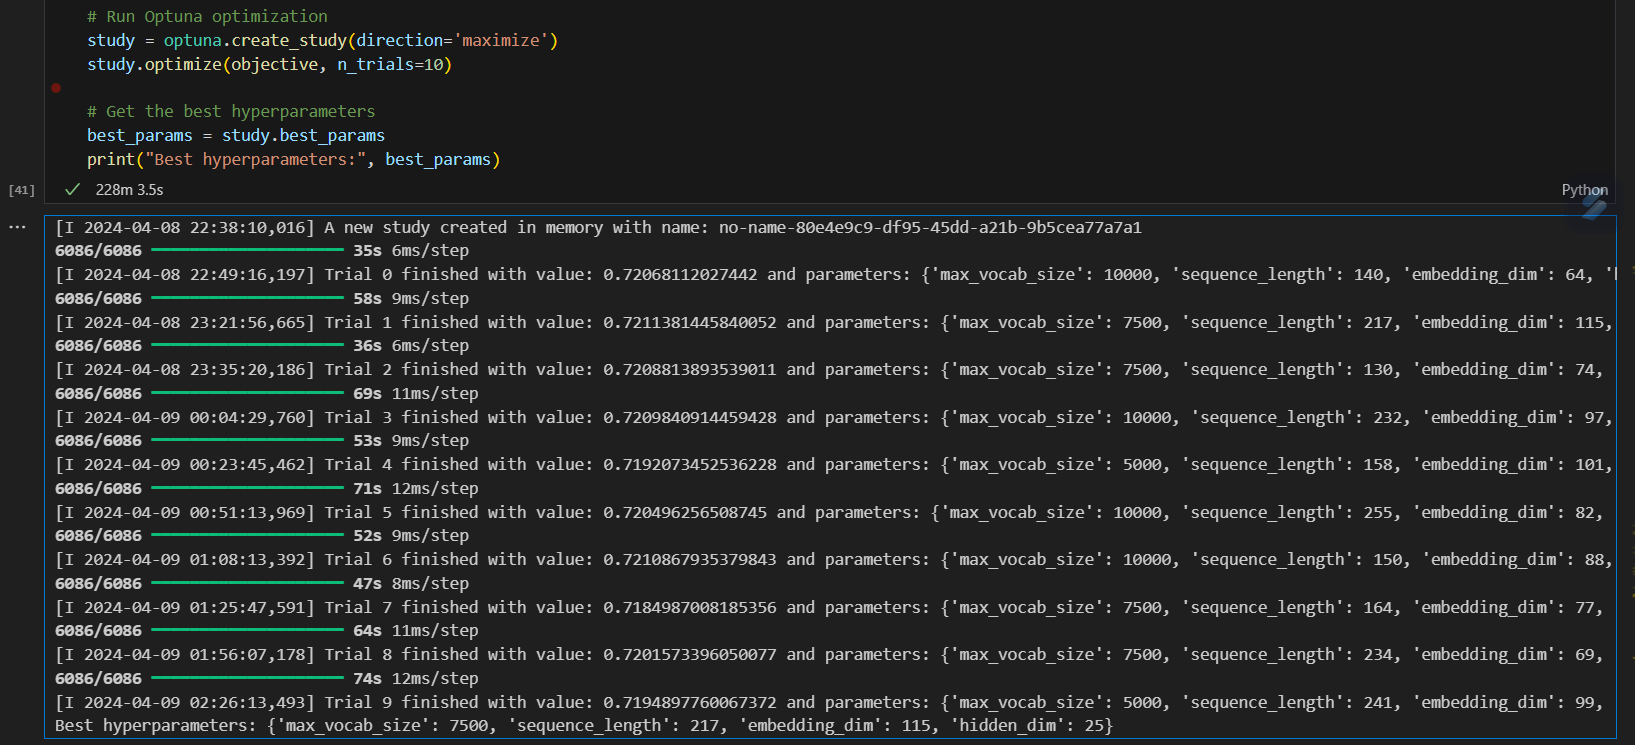

# 5 Results Analysis and Reflections


**Results Analysis**: Upon analyzing the performance of all the models the team ran as reflected in the table below, it was identified that the BERT model had the best performance, at 0.7738, while the CNN had the worst performance, at 0.6509.

Further scrutiny reveals that the worst and best performing models were both of neural network types, demonstrating the volatility of the performance of highly abstracted neural network models.


**Relfections**: The team postulated that BERT, being a deep contextualized language model, was able to capture the intricate linguistic nuances, while the CNN model was unable to understand the hidden, duplicate and/or highly contextual meaning behind sarcastic text.
